In [1]:
%load_ext autoreload
%autoreload 2

In [68]:
# ==========================
# This is to run the base model
# ==========================

import sys
sys.path.append('./..')
sys.path.append('./../..')
import pandas as pd
import yaml
from torch import FloatTensor as FT
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
from utils import *
from tqdm import tqdm
import torch
from sklearn.metrics import auc
from pprint import pprint
try:
    from .data_fetcher import data_fetcher
except:
    from data_fetcher import data_fetcher
try:
    from .base_DAGMM_v2 import DaGMM
except:
    from base_DAGMM_v2 import DaGMM

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print('Current device  >> ', DEVICE)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")

print('Current device  >> ', DEVICE)
try:
    from .base_DAGMM_v2 import DaGMM
except:
    from base_DAGMM_v2 import DaGMM
    
    
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# DEVICE = torch.device("cpu")
print('Current device  >> ', DEVICE)
try:
    from .base_DAGMM_v2 import DaGMM
except:
    from base_DAGMM_v2 import DaGMM

Current device  >>  cuda
Current device  >>  cuda
Current device  >>  cuda


In [3]:
# ============================
#  create config for DAGMM_base
# ============================


def create_config(
        data_set
):
    # Should return :
    # data_dict
    # meta_data_df [column, dimension]

    config_file = 'architecture_config.yaml'

    with open(config_file, 'r') as fh:
        config = yaml.safe_load(fh)

    data_dict, meta_data_df = data_fetcher.get_data(data_set, one_hot=True)

    # discrete_columns : { column_name : num_categories }
    discrete_column_dims = {
        k: v for k, v in
        zip(list(meta_data_df['column']), list(meta_data_df['dimension']))
    }

    num_discrete_columns = 0
    for column,dim in discrete_column_dims.items():
        if dim == 2:
            num_discrete_columns+=1
        else:
            num_discrete_columns+= dim
            
    num_real_columns = len(data_dict['train'].columns) - num_discrete_columns
    print('Num real columns :: ', num_real_columns)
    print('Num discrete columns ::', num_discrete_columns)
    
    latent_dim = config[data_set]['ae_latent_dimension']

    encoder_structure_config = {}
    encoder_structure_config['discrete_column_dims'] = discrete_column_dims
    encoder_structure_config['num_discrete'] = num_discrete_columns
    encoder_structure_config['num_real'] = num_real_columns
    encoder_structure_config['encoder_layers'] = {
        'activation': config[data_set]['encoder_layers']['activation'],
        'layer_dims': config[data_set]['encoder_layers']['layer_dims'] + [latent_dim]
    }

    # ======================================================
    # Set decoder structure
    # =========

    decoder_structure_config = {}
    final_op_dims = num_real_columns 
    for k,v in discrete_column_dims.items():
        if v == 2:
            v = 1
        final_op_dims +=  v
        
    decoder_structure_config['discrete_column_dims'] = discrete_column_dims
    decoder_structure_config['num_discrete'] = num_discrete_columns
    decoder_structure_config['num_real'] = num_real_columns
    decoder_structure_config['decoder_layers'] = {
        'activation': config[data_set]['decoder_layers']['activation'],
        'layer_dims': [latent_dim] + config[data_set]['decoder_layers']['layer_dims'] + [final_op_dims]
    }
    decoder_structure_config['final_output_dim'] = final_op_dims

    # =====================
    # GMM
    # =====================
    gmm_input_dims = latent_dim + 2
    activation = config[data_set]['gmm']['FC_layer']['activation']
    num_components = config[data_set]['gmm']['num_components']
    FC_layer_dims = [gmm_input_dims] + config[data_set]['gmm']['FC_layer']['dims'] + [num_components]
    FC_dropout = config[data_set]['gmm']['FC_dropout']
    gmm_structure_config = {
        'num_components': num_components,
        'FC_layer_dims': FC_layer_dims,
        'FC_dropout': FC_dropout,
        'FC_activation': activation

    }
    loss_structure_config = []

    for column, dim in discrete_column_dims.items():
        loss_structure_config.append(
            {
                'dim': dim,
                'type': 'onehot'
            }
        )
    loss_structure_config.append(
        {
            'dim': num_real_columns,
            'type': 'real'
        }
    )

    return encoder_structure_config, decoder_structure_config, gmm_structure_config, loss_structure_config, latent_dim


In [4]:
def train(
        dagmm_obj,
        data,
        num_epochs,
        batch_size=256,
        LR=0.0001
):
    optimizer = torch.optim.Adam(dagmm_obj.parameters(), lr=LR)
    dagmm_obj.train()
    log_interval = 50
    for epoch in tqdm(range(num_epochs)):
        num_batches = data.shape[0] // batch_size + 1
        epoch_losses = []
        np.random.shuffle(data)
        X = FT(data).to(DEVICE)
        lambda_energy = 0.1
        lambda_cov_diag = 0.005
        for b in range(num_batches):
            optimizer.zero_grad()
            input_data = X[b * batch_size: (b + 1) * batch_size]
            enc, dec, z, gamma = dagmm_obj(input_data)
            total_loss, sample_energy, recon_error, cov_diag = dagmm_obj.loss_function(
                input_data, dec, z, gamma,
                lambda_energy,
                lambda_cov_diag
            )

            dagmm_obj.zero_grad()
            total_loss = Variable(total_loss, requires_grad=True)
            total_loss.backward()
            epoch_losses.append(total_loss.cpu().data.numpy())
            torch.nn.utils.clip_grad_norm_(dagmm_obj.parameters(), 5)
            optimizer.step()

            loss = {}
            loss['total_loss'] = total_loss.data.item()
            loss['sample_energy'] = sample_energy.item()
            loss['recon_error'] = recon_error.item()
            loss['cov_diag'] = cov_diag.item()

            if (b + 1) % log_interval == 0:
                log = ' '
                for tag, value in loss.items():
                    log += ", {}: {:.4f}".format(tag, value)
                print(log)
        print('Epoch loss ::', np.mean(epoch_losses))
    return dagmm_obj

# =================================== #

In [71]:
def test(
    dagmm_obj,
    train_X,
    test_X,
    anom_X
):
    global DEVICE
    print("======================TEST MODE======================")
    dagmm_obj.eval()
    N = 0
    mu_sum = 0
    cov_sum = 0
    gamma_sum = 0

    train_X = data_dict['train'].values
    batch_size = 500
    num_batches = train_X.shape[0]//batch_size + 1
    
    for b in range(num_batches):
        input_data = train_X[b * batch_size: (b + 1) * batch_size]
        input_data = FT(input_data).to(DEVICE)
        enc, dec, z, gamma = dagmm_obj(input_data)
        phi, mu, cov = dagmm_obj.compute_gmm_params(z, gamma)
        batch_gamma_sum = torch.sum(gamma, dim=0)
        gamma_sum += batch_gamma_sum
        mu_sum += mu * batch_gamma_sum.unsqueeze(-1)  # keep sums of the numerator only
        cov_sum += cov * batch_gamma_sum.unsqueeze(-1).unsqueeze(-1)  # keep sums of the numerator only
        N += input_data.size(0)


    train_phi = gamma_sum / N
    train_mu = mu_sum / gamma_sum.unsqueeze(-1)
    train_cov = cov_sum / gamma_sum.unsqueeze(-1).unsqueeze(-1)

    print("N:", N)
    print("phi :", train_phi)
    print("mu : ", train_mu)
    print("covariance :", train_cov)

    # ============================ #
    # Get sample energy for test set
    # ============================ #
    test_energy = []
    train_labels = []
    train_z = []

   
    num_batches = test_X.shape[0] // batch_size + 1
    print('Size of test ', test_X.shape[0])
    
    for b in range(num_batches):
        input_data = test_X[b * batch_size: (b + 1) * batch_size]
        input_data = FT(input_data).to(DEVICE)
        enc, dec, z, gamma = dagmm_obj(input_data)
        sample_energy, cov_diag = dagmm_obj.compute_energy(
            z,
            phi=train_phi,
            mu=train_mu,
            cov=train_cov,
            size_average=False
        )
        test_energy.append(sample_energy.data.cpu().numpy())
        # train_z.append(z.data.cpu().numpy())
        # train_labels.append(labels.numpy())
    
    test_energy = np.concatenate(test_energy, axis=0)
    print('test_energy',test_energy.shape)
    test_labels = [0 for _ in range(test_X.shape[0])]
    auc_list = []
    # ===========
    # Get per sample energy of the anomalies
    # ===========
    num_anom_sets = 1
    F1 = 0
    for idx in range(1):
        anom_labels = [1 for _ in range(anom_X.shape[0])]
        anom_energy = []
        num_batches = anom_X.shape[0] // batch_size + 1

        for b in range(num_batches):
            input_data = anom_X[b * batch_size: (b + 1) * batch_size]
            input_data = FT(input_data).to(DEVICE)
            enc, dec, z, gamma = dagmm_obj(input_data)
            sample_energy, cov_diag = dagmm_obj.compute_energy(
                z,
                phi=train_phi,
                mu=train_mu,
                cov=train_cov,
                size_average=False
            )
            anom_energy.append(sample_energy.data.cpu().numpy())

        anom_energy = np.concatenate(anom_energy,axis=0)
#         print(anom_energy.shape)
        combined_energy = np.concatenate([anom_energy, test_energy], axis=0)
        combined_labels = np.concatenate([anom_labels, test_labels], axis=0)
#         print(
#             combined_energy.shape,
#             combined_labels.shape
#         )
        res_data = []
        for i,j in zip(combined_energy, combined_labels):
            res_data.append((i,j))
        res_df = pd.DataFrame(res_data, columns=['score','label'] )
        #  Normalize values
        def _normalize_(val, _min,_max):
            return (val -_min)/(_max - _min)

        _max = max(combined_energy)
        _min = min(combined_energy)

        res_df['score'] = res_df['score'].parallel_apply(
            _normalize_,
            args=(_min,_max, )
        )

        res_df = res_df.sort_values(by=['score'],ascending = False)
        _max = max(res_df['score'])
        _min = min(res_df['score'])
        #         print('Min, Max', _min, _max)
        
        thresh =  np.percentile(res_df['score'], 100 - 20)
        sel = res_df.loc[res_df['score'] >= thresh]
        correct = sel.loc[sel['label'] == 1 ]
        
        num_anomalies = anom_X.shape[0]
#         print('Num selected ', len(sel))
        prec = len(correct)/ len(sel)
        rec = len(correct)/num_anomalies
        F1 = (2 * prec * rec) / (prec + rec + 0.000001)
        print('Precision {}  Recall {}'.format(prec,rec), ' F1 >>',F1)
        
        step = (_max - _min)/ 100
        # Vary the threshold
        thresh = _max - step
        num_anomalies = anom_X.shape[0]
        P = []
        R = []

        while thresh > _min:

            sel = res_df.loc[res_df['score'] >= thresh]
            if len(sel) == 0 :
                thresh -= step
                continue
            correct = sel.loc[sel['label'] == 1 ]
            prec = len(correct)/ len(sel)
            rec = len(correct)/num_anomalies
            P.append(prec)
            R.append(rec)
            thresh -= step

        from sklearn.metrics import auc
        pr_auc = auc(R, P)
#         auc_list.append(pr_auc)

        print("AUC : {:0.4f} ".format(pr_auc))
        try:
            plt.figure()
            plt.title('PR Curve' + str(pr_auc))
            plt.plot(R, P)
            plt.show()
        except:
            pass
#     print(' Mean AUC ',np.mean(auc_list))
#     print(' AUC std', np.std(auc_list))
    return F1, pr_auc



    

In [5]:
try:
    from .base_DAGMM_v2 import DaGMM
except:
    from base_DAGMM_v2 import DaGMM
 

In [55]:
# =================================== #
data_set = 'kddcup'
data_dict, _ = data_fetcher.get_data(data_set,one_hot=True,num_anom_sets=1,anomaly_ratio=1)
train_df = data_dict['train']
train_X = train_df.values

In [56]:
all_data = data_dict['train'].append(data_dict['test'],ignore_index=True)

In [57]:
len(all_data)

97278

In [58]:
anom_data =  data_dict['anom_1']
len(anom_data)

29184

In [59]:
encoder_structure_config, decoder_structure_config, gmm_structure_config, _, latent_dim = create_config(
    data_set
)
pprint(encoder_structure_config)
pprint(decoder_structure_config)
# =================================== #

Num real columns ::  34
Num discrete columns :: 83
{'discrete_column_dims': {'flag': 11,
                          'is_guest_login': 2,
                          'land': 2,
                          'logged_in': 2,
                          'protocol_type': 3,
                          'service': 66},
 'encoder_layers': {'activation': 'tanh', 'layer_dims': [60, 30, 10, 1]},
 'num_discrete': 83,
 'num_real': 34}
{'decoder_layers': {'activation': 'tanh', 'layer_dims': [1, 10, 30, 60, 117]},
 'discrete_column_dims': {'flag': 11,
                          'is_guest_login': 2,
                          'land': 2,
                          'logged_in': 2,
                          'protocol_type': 3,
                          'service': 66},
 'final_output_dim': 117,
 'num_discrete': 83,
 'num_real': 34}


In [60]:
   

print(dagmm_obj)

DaGMM(
  (encoder): AE_encoder(
    (FC_z): Sequential(
      (0): Linear(in_features=117, out_features=60, bias=True)
      (1): Tanh()
      (2): Linear(in_features=60, out_features=30, bias=True)
      (3): Tanh()
      (4): Linear(in_features=30, out_features=10, bias=True)
      (5): Tanh()
      (6): Linear(in_features=10, out_features=1, bias=True)
    )
  )
  (decoder): AE_decoder(
    (FC_z): Sequential(
      (0): Linear(in_features=1, out_features=10, bias=True)
      (1): Tanh()
      (2): Linear(in_features=10, out_features=30, bias=True)
      (3): Tanh()
      (4): Linear(in_features=30, out_features=60, bias=True)
      (5): Tanh()
      (6): Linear(in_features=60, out_features=117, bias=True)
      (7): Tanh()
    )
  )
  (estimation): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): Tanh()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=10, out_features=2, bias=True)
    (4): Softmax(dim=1)
  )
)


  0%|          | 1/400 [00:01<06:57,  1.05s/it]

Epoch loss :: 83.45555


  0%|          | 2/400 [00:02<07:04,  1.07s/it]

Epoch loss :: 83.3882


  1%|          | 3/400 [00:03<07:10,  1.09s/it]

Epoch loss :: 83.496056


  1%|          | 4/400 [00:04<07:12,  1.09s/it]

Epoch loss :: 83.411766


  1%|▏         | 5/400 [00:05<06:49,  1.04s/it]

Epoch loss :: 83.40484


  2%|▏         | 6/400 [00:06<06:51,  1.04s/it]

Epoch loss :: 83.49476


  2%|▏         | 7/400 [00:07<07:13,  1.10s/it]

Epoch loss :: 83.529785


  2%|▏         | 8/400 [00:08<07:30,  1.15s/it]

Epoch loss :: 83.40637


  2%|▏         | 9/400 [00:10<07:47,  1.19s/it]

Epoch loss :: 83.50329


  2%|▎         | 10/400 [00:11<07:55,  1.22s/it]

Epoch loss :: 83.486


  3%|▎         | 11/400 [00:12<07:58,  1.23s/it]

Epoch loss :: 83.492516


  3%|▎         | 12/400 [00:13<08:03,  1.25s/it]

Epoch loss :: 83.62615


  3%|▎         | 13/400 [00:15<08:03,  1.25s/it]

Epoch loss :: 83.457726


  4%|▎         | 14/400 [00:16<07:53,  1.23s/it]

Epoch loss :: 83.458336


  4%|▍         | 15/400 [00:17<07:34,  1.18s/it]

Epoch loss :: 83.56948


  4%|▍         | 16/400 [00:18<07:18,  1.14s/it]

Epoch loss :: 83.40029


  4%|▍         | 17/400 [00:19<07:28,  1.17s/it]

Epoch loss :: 83.590225


  4%|▍         | 18/400 [00:20<07:31,  1.18s/it]

Epoch loss :: 83.56196


  5%|▍         | 19/400 [00:22<07:40,  1.21s/it]

Epoch loss :: 83.48271


  5%|▌         | 20/400 [00:23<08:00,  1.26s/it]

Epoch loss :: 83.387024


  5%|▌         | 21/400 [00:25<08:14,  1.30s/it]

Epoch loss :: 83.50906


  6%|▌         | 22/400 [00:26<08:08,  1.29s/it]

Epoch loss :: 83.434296


  6%|▌         | 23/400 [00:27<07:56,  1.26s/it]

Epoch loss :: 83.635796


  6%|▌         | 24/400 [00:28<07:57,  1.27s/it]

Epoch loss :: 83.49088


  6%|▋         | 25/400 [00:30<07:52,  1.26s/it]

Epoch loss :: 83.395805


  6%|▋         | 26/400 [00:31<07:42,  1.24s/it]

Epoch loss :: 83.34832


  7%|▋         | 27/400 [00:32<07:42,  1.24s/it]

Epoch loss :: 83.4744


  7%|▋         | 28/400 [00:33<07:51,  1.27s/it]

Epoch loss :: 83.57075


  7%|▋         | 29/400 [00:34<07:30,  1.21s/it]

Epoch loss :: 83.474144


  8%|▊         | 30/400 [00:35<07:18,  1.18s/it]

Epoch loss :: 83.68811


  8%|▊         | 31/400 [00:37<07:13,  1.17s/it]

Epoch loss :: 83.53182


  8%|▊         | 32/400 [00:38<06:52,  1.12s/it]

Epoch loss :: 83.49259


  8%|▊         | 33/400 [00:39<06:40,  1.09s/it]

Epoch loss :: 83.4316


  8%|▊         | 34/400 [00:40<06:54,  1.13s/it]

Epoch loss :: 83.467186


  9%|▉         | 35/400 [00:41<06:58,  1.15s/it]

Epoch loss :: 83.61967


  9%|▉         | 36/400 [00:42<07:07,  1.18s/it]

Epoch loss :: 83.65658


  9%|▉         | 37/400 [00:44<07:19,  1.21s/it]

Epoch loss :: 83.51866


 10%|▉         | 38/400 [00:45<07:23,  1.22s/it]

Epoch loss :: 83.433075


 10%|▉         | 39/400 [00:46<07:23,  1.23s/it]

Epoch loss :: 83.58306


 10%|█         | 40/400 [00:47<07:26,  1.24s/it]

Epoch loss :: 83.55563


 10%|█         | 41/400 [00:49<07:15,  1.21s/it]

Epoch loss :: 83.59646


 10%|█         | 42/400 [00:50<07:27,  1.25s/it]

Epoch loss :: 83.45724


 11%|█         | 43/400 [00:51<07:31,  1.26s/it]

Epoch loss :: 83.513435


 11%|█         | 44/400 [00:52<07:27,  1.26s/it]

Epoch loss :: 83.46017


 11%|█▏        | 45/400 [00:54<07:30,  1.27s/it]

Epoch loss :: 83.56372


 12%|█▏        | 46/400 [00:55<07:41,  1.30s/it]

Epoch loss :: 83.53352


 12%|█▏        | 47/400 [00:56<07:21,  1.25s/it]

Epoch loss :: 83.413445


 12%|█▏        | 48/400 [00:57<07:22,  1.26s/it]

Epoch loss :: 83.40729


 12%|█▏        | 49/400 [00:59<06:58,  1.19s/it]

Epoch loss :: 83.60017


 12%|█▎        | 50/400 [01:00<07:14,  1.24s/it]

Epoch loss :: 83.49443


 13%|█▎        | 51/400 [01:01<07:08,  1.23s/it]

Epoch loss :: 83.5799


 13%|█▎        | 52/400 [01:02<07:03,  1.22s/it]

Epoch loss :: 83.445435


 13%|█▎        | 53/400 [01:04<07:26,  1.29s/it]

Epoch loss :: 83.63095


 14%|█▎        | 54/400 [01:05<07:06,  1.23s/it]

Epoch loss :: 83.55859


 14%|█▍        | 55/400 [01:06<07:02,  1.22s/it]

Epoch loss :: 83.53272


 14%|█▍        | 56/400 [01:07<07:05,  1.24s/it]

Epoch loss :: 83.529655


 14%|█▍        | 57/400 [01:08<06:47,  1.19s/it]

Epoch loss :: 83.45341


 14%|█▍        | 58/400 [01:10<06:53,  1.21s/it]

Epoch loss :: 83.48303


 15%|█▍        | 59/400 [01:11<07:07,  1.25s/it]

Epoch loss :: 83.528114


 15%|█▌        | 60/400 [01:12<07:02,  1.24s/it]

Epoch loss :: 83.58975


 15%|█▌        | 61/400 [01:13<06:56,  1.23s/it]

Epoch loss :: 83.383415


 16%|█▌        | 62/400 [01:15<07:10,  1.27s/it]

Epoch loss :: 83.475


 16%|█▌        | 63/400 [01:16<07:13,  1.29s/it]

Epoch loss :: 83.489784


 16%|█▌        | 64/400 [01:17<07:04,  1.26s/it]

Epoch loss :: 83.45646


 16%|█▋        | 65/400 [01:18<06:56,  1.24s/it]

Epoch loss :: 83.503784


 16%|█▋        | 66/400 [01:20<06:50,  1.23s/it]

Epoch loss :: 83.43458


 17%|█▋        | 67/400 [01:21<07:00,  1.26s/it]

Epoch loss :: 83.453674


 17%|█▋        | 68/400 [01:22<07:00,  1.27s/it]

Epoch loss :: 83.42736


 17%|█▋        | 69/400 [01:23<06:48,  1.23s/it]

Epoch loss :: 83.562996


 18%|█▊        | 70/400 [01:25<06:36,  1.20s/it]

Epoch loss :: 83.58672


 18%|█▊        | 71/400 [01:26<06:47,  1.24s/it]

Epoch loss :: 83.56713


 18%|█▊        | 72/400 [01:27<06:56,  1.27s/it]

Epoch loss :: 83.469185


 18%|█▊        | 73/400 [01:29<06:59,  1.28s/it]

Epoch loss :: 83.4257


 18%|█▊        | 74/400 [01:30<06:53,  1.27s/it]

Epoch loss :: 83.418335


 19%|█▉        | 75/400 [01:31<06:31,  1.21s/it]

Epoch loss :: 83.46789


 19%|█▉        | 76/400 [01:32<06:39,  1.23s/it]

Epoch loss :: 83.599884


 19%|█▉        | 77/400 [01:33<06:24,  1.19s/it]

Epoch loss :: 83.400276


 20%|█▉        | 78/400 [01:35<06:43,  1.25s/it]

Epoch loss :: 83.59542


 20%|█▉        | 79/400 [01:36<06:48,  1.27s/it]

Epoch loss :: 83.51742


 20%|██        | 80/400 [01:37<06:53,  1.29s/it]

Epoch loss :: 83.40333


 20%|██        | 81/400 [01:38<06:40,  1.26s/it]

Epoch loss :: 83.56418


 20%|██        | 82/400 [01:40<06:25,  1.21s/it]

Epoch loss :: 83.47725


 21%|██        | 83/400 [01:41<06:16,  1.19s/it]

Epoch loss :: 83.4141


 21%|██        | 84/400 [01:42<06:19,  1.20s/it]

Epoch loss :: 83.367836


 21%|██▏       | 85/400 [01:43<06:05,  1.16s/it]

Epoch loss :: 83.445274


 22%|██▏       | 86/400 [01:44<06:12,  1.19s/it]

Epoch loss :: 83.60327


 22%|██▏       | 87/400 [01:46<06:17,  1.21s/it]

Epoch loss :: 83.55212


 22%|██▏       | 88/400 [01:47<06:13,  1.20s/it]

Epoch loss :: 83.48346


 22%|██▏       | 89/400 [01:48<06:05,  1.17s/it]

Epoch loss :: 83.46052


 22%|██▎       | 90/400 [01:49<06:07,  1.18s/it]

Epoch loss :: 83.60465


 23%|██▎       | 91/400 [01:50<06:06,  1.19s/it]

Epoch loss :: 83.54404


 23%|██▎       | 92/400 [01:51<06:13,  1.21s/it]

Epoch loss :: 83.56975


 23%|██▎       | 93/400 [01:53<06:13,  1.22s/it]

Epoch loss :: 83.472916


 24%|██▎       | 94/400 [01:54<06:16,  1.23s/it]

Epoch loss :: 83.41699


 24%|██▍       | 95/400 [01:55<06:06,  1.20s/it]

Epoch loss :: 83.387024


 24%|██▍       | 96/400 [01:56<06:15,  1.24s/it]

Epoch loss :: 83.4458


 24%|██▍       | 97/400 [01:58<06:28,  1.28s/it]

Epoch loss :: 83.61057


 24%|██▍       | 98/400 [01:59<06:16,  1.25s/it]

Epoch loss :: 83.43656


 25%|██▍       | 99/400 [02:00<06:23,  1.27s/it]

Epoch loss :: 83.56634


 25%|██▌       | 100/400 [02:01<06:07,  1.22s/it]

Epoch loss :: 83.389565


 25%|██▌       | 101/400 [02:03<06:22,  1.28s/it]

Epoch loss :: 83.50878


 26%|██▌       | 102/400 [02:04<06:27,  1.30s/it]

Epoch loss :: 83.42543


 26%|██▌       | 103/400 [02:06<06:36,  1.33s/it]

Epoch loss :: 83.512184


 26%|██▌       | 104/400 [02:07<06:25,  1.30s/it]

Epoch loss :: 83.52439


 26%|██▋       | 105/400 [02:08<06:11,  1.26s/it]

Epoch loss :: 83.62502


 26%|██▋       | 106/400 [02:09<06:15,  1.28s/it]

Epoch loss :: 83.507576


 27%|██▋       | 107/400 [02:11<06:20,  1.30s/it]

Epoch loss :: 83.43801


 27%|██▋       | 108/400 [02:12<06:03,  1.24s/it]

Epoch loss :: 83.4916


 27%|██▋       | 109/400 [02:13<05:53,  1.21s/it]

Epoch loss :: 83.54377


 28%|██▊       | 110/400 [02:14<05:59,  1.24s/it]

Epoch loss :: 83.422


 28%|██▊       | 111/400 [02:16<06:04,  1.26s/it]

Epoch loss :: 83.53046


 28%|██▊       | 112/400 [02:17<06:02,  1.26s/it]

Epoch loss :: 83.4024


 28%|██▊       | 113/400 [02:18<05:55,  1.24s/it]

Epoch loss :: 83.503716


 28%|██▊       | 114/400 [02:19<05:46,  1.21s/it]

Epoch loss :: 83.539696


 29%|██▉       | 115/400 [02:20<05:54,  1.24s/it]

Epoch loss :: 83.417244


 29%|██▉       | 116/400 [02:22<06:07,  1.29s/it]

Epoch loss :: 83.46481


 29%|██▉       | 117/400 [02:23<05:54,  1.25s/it]

Epoch loss :: 83.41712


 30%|██▉       | 118/400 [02:24<05:54,  1.26s/it]

Epoch loss :: 83.59937


 30%|██▉       | 119/400 [02:26<05:55,  1.26s/it]

Epoch loss :: 83.417274


 30%|███       | 120/400 [02:27<05:49,  1.25s/it]

Epoch loss :: 83.801956


 30%|███       | 121/400 [02:28<05:43,  1.23s/it]

Epoch loss :: 83.49842


 30%|███       | 122/400 [02:29<05:47,  1.25s/it]

Epoch loss :: 83.42083


 31%|███       | 123/400 [02:31<05:47,  1.25s/it]

Epoch loss :: 83.55264


 31%|███       | 124/400 [02:32<05:50,  1.27s/it]

Epoch loss :: 83.50705


 31%|███▏      | 125/400 [02:33<05:58,  1.30s/it]

Epoch loss :: 83.4392


 32%|███▏      | 126/400 [02:34<05:50,  1.28s/it]

Epoch loss :: 83.483604


 32%|███▏      | 127/400 [02:36<05:47,  1.27s/it]

Epoch loss :: 83.480156


 32%|███▏      | 128/400 [02:37<05:54,  1.30s/it]

Epoch loss :: 83.65268


 32%|███▏      | 129/400 [02:39<06:06,  1.35s/it]

Epoch loss :: 83.68924


 32%|███▎      | 130/400 [02:40<06:03,  1.35s/it]

Epoch loss :: 83.42552


 33%|███▎      | 131/400 [02:41<05:58,  1.33s/it]

Epoch loss :: 83.41442


 33%|███▎      | 132/400 [02:43<05:59,  1.34s/it]

Epoch loss :: 83.429214


 33%|███▎      | 133/400 [02:44<06:00,  1.35s/it]

Epoch loss :: 83.44837


 34%|███▎      | 134/400 [02:45<05:51,  1.32s/it]

Epoch loss :: 83.53248


 34%|███▍      | 135/400 [02:46<05:42,  1.29s/it]

Epoch loss :: 83.56716


 34%|███▍      | 136/400 [02:48<05:40,  1.29s/it]

Epoch loss :: 83.66607


 34%|███▍      | 137/400 [02:49<05:24,  1.23s/it]

Epoch loss :: 83.41603


 34%|███▍      | 138/400 [02:50<05:13,  1.20s/it]

Epoch loss :: 83.448


 35%|███▍      | 139/400 [02:51<05:09,  1.19s/it]

Epoch loss :: 83.47085


 35%|███▌      | 140/400 [02:52<05:15,  1.22s/it]

Epoch loss :: 83.42661


 35%|███▌      | 141/400 [02:54<05:18,  1.23s/it]

Epoch loss :: 83.58982


 36%|███▌      | 142/400 [02:55<05:12,  1.21s/it]

Epoch loss :: 83.47488


 36%|███▌      | 143/400 [02:56<04:53,  1.14s/it]

Epoch loss :: 83.50522


 36%|███▌      | 144/400 [02:57<04:51,  1.14s/it]

Epoch loss :: 83.5044


 36%|███▋      | 145/400 [02:58<04:55,  1.16s/it]

Epoch loss :: 83.48001


 36%|███▋      | 146/400 [02:59<04:56,  1.17s/it]

Epoch loss :: 83.37377


 37%|███▋      | 147/400 [03:01<05:03,  1.20s/it]

Epoch loss :: 83.504036


 37%|███▋      | 148/400 [03:02<05:09,  1.23s/it]

Epoch loss :: 83.60093


 37%|███▋      | 149/400 [03:03<05:04,  1.21s/it]

Epoch loss :: 83.46192


 38%|███▊      | 150/400 [03:04<04:52,  1.17s/it]

Epoch loss :: 83.64148


 38%|███▊      | 151/400 [03:05<04:49,  1.16s/it]

Epoch loss :: 83.48922


 38%|███▊      | 152/400 [03:06<04:55,  1.19s/it]

Epoch loss :: 83.48531


 38%|███▊      | 153/400 [03:08<04:58,  1.21s/it]

Epoch loss :: 83.703835


 38%|███▊      | 154/400 [03:09<05:00,  1.22s/it]

Epoch loss :: 83.429756


 39%|███▉      | 155/400 [03:10<04:54,  1.20s/it]

Epoch loss :: 83.57346


 39%|███▉      | 156/400 [03:11<04:53,  1.20s/it]

Epoch loss :: 83.52972


 39%|███▉      | 157/400 [03:13<04:52,  1.20s/it]

Epoch loss :: 83.56662


 40%|███▉      | 158/400 [03:14<05:01,  1.24s/it]

Epoch loss :: 83.57679


 40%|███▉      | 159/400 [03:15<05:10,  1.29s/it]

Epoch loss :: 83.550476


 40%|████      | 160/400 [03:16<04:58,  1.24s/it]

Epoch loss :: 83.53979


 40%|████      | 161/400 [03:18<05:08,  1.29s/it]

Epoch loss :: 83.52122


 40%|████      | 162/400 [03:19<05:07,  1.29s/it]

Epoch loss :: 83.39423


 41%|████      | 163/400 [03:20<05:02,  1.28s/it]

Epoch loss :: 83.408035


 41%|████      | 164/400 [03:22<04:53,  1.24s/it]

Epoch loss :: 83.45586


 41%|████▏     | 165/400 [03:23<04:58,  1.27s/it]

Epoch loss :: 83.54833


 42%|████▏     | 166/400 [03:24<04:53,  1.26s/it]

Epoch loss :: 83.427086


 42%|████▏     | 167/400 [03:25<04:48,  1.24s/it]

Epoch loss :: 83.55829


 42%|████▏     | 168/400 [03:27<04:49,  1.25s/it]

Epoch loss :: 83.5394


 42%|████▏     | 169/400 [03:28<04:57,  1.29s/it]

Epoch loss :: 83.43649


 42%|████▎     | 170/400 [03:29<04:52,  1.27s/it]

Epoch loss :: 83.4244


 43%|████▎     | 171/400 [03:30<04:52,  1.28s/it]

Epoch loss :: 83.47919


 43%|████▎     | 172/400 [03:32<04:47,  1.26s/it]

Epoch loss :: 83.40308


 43%|████▎     | 173/400 [03:33<04:37,  1.22s/it]

Epoch loss :: 83.56512


 44%|████▎     | 174/400 [03:34<04:40,  1.24s/it]

Epoch loss :: 83.47049


 44%|████▍     | 175/400 [03:35<04:31,  1.21s/it]

Epoch loss :: 83.49363


 44%|████▍     | 176/400 [03:36<04:31,  1.21s/it]

Epoch loss :: 83.48438


 44%|████▍     | 177/400 [03:38<04:35,  1.24s/it]

Epoch loss :: 83.540955


 44%|████▍     | 178/400 [03:39<04:39,  1.26s/it]

Epoch loss :: 83.42535


 45%|████▍     | 179/400 [03:40<04:42,  1.28s/it]

Epoch loss :: 83.51008


 45%|████▌     | 180/400 [03:41<04:30,  1.23s/it]

Epoch loss :: 83.55172


 45%|████▌     | 181/400 [03:43<04:19,  1.19s/it]

Epoch loss :: 83.46787


 46%|████▌     | 182/400 [03:44<04:21,  1.20s/it]

Epoch loss :: 83.43067


 46%|████▌     | 183/400 [03:45<04:18,  1.19s/it]

Epoch loss :: 83.479866


 46%|████▌     | 184/400 [03:46<04:09,  1.16s/it]

Epoch loss :: 83.530174


 46%|████▋     | 185/400 [03:47<04:15,  1.19s/it]

Epoch loss :: 83.545525


 46%|████▋     | 186/400 [03:49<04:19,  1.21s/it]

Epoch loss :: 83.42808


 47%|████▋     | 187/400 [03:50<04:12,  1.19s/it]

Epoch loss :: 83.59757


 47%|████▋     | 188/400 [03:51<04:17,  1.21s/it]

Epoch loss :: 83.37748


 47%|████▋     | 189/400 [03:52<04:14,  1.21s/it]

Epoch loss :: 83.61328


 48%|████▊     | 190/400 [03:53<04:05,  1.17s/it]

Epoch loss :: 83.55918


 48%|████▊     | 191/400 [03:54<04:03,  1.16s/it]

Epoch loss :: 83.530464


 48%|████▊     | 192/400 [03:56<04:08,  1.20s/it]

Epoch loss :: 83.528496


 48%|████▊     | 193/400 [03:57<04:16,  1.24s/it]

Epoch loss :: 83.440285


 48%|████▊     | 194/400 [03:58<04:14,  1.24s/it]

Epoch loss :: 83.475945


 49%|████▉     | 195/400 [04:00<04:15,  1.25s/it]

Epoch loss :: 83.4609


 49%|████▉     | 196/400 [04:01<04:16,  1.26s/it]

Epoch loss :: 83.57544


 49%|████▉     | 197/400 [04:02<04:11,  1.24s/it]

Epoch loss :: 83.53243


 50%|████▉     | 198/400 [04:03<04:08,  1.23s/it]

Epoch loss :: 83.51242


 50%|████▉     | 199/400 [04:04<04:06,  1.23s/it]

Epoch loss :: 83.614006


 50%|█████     | 200/400 [04:06<04:08,  1.24s/it]

Epoch loss :: 83.59232


 50%|█████     | 201/400 [04:07<04:08,  1.25s/it]

Epoch loss :: 83.43983


 50%|█████     | 202/400 [04:08<04:09,  1.26s/it]

Epoch loss :: 83.445366


 51%|█████     | 203/400 [04:09<04:06,  1.25s/it]

Epoch loss :: 83.59505


 51%|█████     | 204/400 [04:11<04:10,  1.28s/it]

Epoch loss :: 83.44083


 51%|█████▏    | 205/400 [04:12<04:04,  1.26s/it]

Epoch loss :: 83.50051


 52%|█████▏    | 206/400 [04:13<03:52,  1.20s/it]

Epoch loss :: 83.539505


 52%|█████▏    | 207/400 [04:14<03:47,  1.18s/it]

Epoch loss :: 83.50723


 52%|█████▏    | 208/400 [04:15<03:38,  1.14s/it]

Epoch loss :: 83.426025


 52%|█████▏    | 209/400 [04:17<03:43,  1.17s/it]

Epoch loss :: 83.35067


 52%|█████▎    | 210/400 [04:18<03:46,  1.19s/it]

Epoch loss :: 83.45057


 53%|█████▎    | 211/400 [04:19<03:49,  1.21s/it]

Epoch loss :: 83.53694


 53%|█████▎    | 212/400 [04:20<03:55,  1.25s/it]

Epoch loss :: 83.449394


 53%|█████▎    | 213/400 [04:22<04:03,  1.30s/it]

Epoch loss :: 83.593636


 54%|█████▎    | 214/400 [04:23<04:04,  1.32s/it]

Epoch loss :: 83.6188


 54%|█████▍    | 215/400 [04:25<04:11,  1.36s/it]

Epoch loss :: 83.61104


 54%|█████▍    | 216/400 [04:26<04:00,  1.31s/it]

Epoch loss :: 83.41154


 54%|█████▍    | 217/400 [04:27<03:58,  1.30s/it]

Epoch loss :: 83.4578


 55%|█████▍    | 218/400 [04:28<04:04,  1.34s/it]

Epoch loss :: 83.55579


 55%|█████▍    | 219/400 [04:30<03:59,  1.32s/it]

Epoch loss :: 83.43341


 55%|█████▌    | 220/400 [04:31<03:57,  1.32s/it]

Epoch loss :: 83.55478


 55%|█████▌    | 221/400 [04:33<04:03,  1.36s/it]

Epoch loss :: 83.507286


 56%|█████▌    | 222/400 [04:34<04:03,  1.37s/it]

Epoch loss :: 83.55781


 56%|█████▌    | 223/400 [04:35<04:02,  1.37s/it]

Epoch loss :: 83.436584


 56%|█████▌    | 224/400 [04:37<03:52,  1.32s/it]

Epoch loss :: 83.64771


 56%|█████▋    | 225/400 [04:38<03:44,  1.28s/it]

Epoch loss :: 83.476845


 56%|█████▋    | 226/400 [04:39<03:43,  1.28s/it]

Epoch loss :: 83.436165


 57%|█████▋    | 227/400 [04:40<03:39,  1.27s/it]

Epoch loss :: 83.46632


 57%|█████▋    | 228/400 [04:41<03:37,  1.27s/it]

Epoch loss :: 83.42213


 57%|█████▋    | 229/400 [04:43<03:35,  1.26s/it]

Epoch loss :: 83.62141


 57%|█████▊    | 230/400 [04:44<03:24,  1.20s/it]

Epoch loss :: 83.444725


 58%|█████▊    | 231/400 [04:45<03:16,  1.16s/it]

Epoch loss :: 83.41836


 58%|█████▊    | 232/400 [04:46<03:25,  1.22s/it]

Epoch loss :: 83.50373


 58%|█████▊    | 233/400 [04:48<03:30,  1.26s/it]

Epoch loss :: 83.52085


 58%|█████▊    | 234/400 [04:49<03:30,  1.27s/it]

Epoch loss :: 83.50473


 59%|█████▉    | 235/400 [04:50<03:33,  1.29s/it]

Epoch loss :: 83.397285


 59%|█████▉    | 236/400 [04:51<03:29,  1.28s/it]

Epoch loss :: 83.49236


 59%|█████▉    | 237/400 [04:53<03:27,  1.27s/it]

Epoch loss :: 83.54273


 60%|█████▉    | 238/400 [04:54<03:32,  1.31s/it]

Epoch loss :: 83.445


 60%|█████▉    | 239/400 [04:55<03:32,  1.32s/it]

Epoch loss :: 83.447266


 60%|██████    | 240/400 [04:57<03:18,  1.24s/it]

Epoch loss :: 83.65449


 60%|██████    | 241/400 [04:58<03:17,  1.24s/it]

Epoch loss :: 83.34529


 60%|██████    | 242/400 [04:59<03:17,  1.25s/it]

Epoch loss :: 83.475365


 61%|██████    | 243/400 [05:00<03:16,  1.25s/it]

Epoch loss :: 83.530945


 61%|██████    | 244/400 [05:01<03:11,  1.23s/it]

Epoch loss :: 83.38517


 61%|██████▏   | 245/400 [05:03<03:10,  1.23s/it]

Epoch loss :: 83.52374


 62%|██████▏   | 246/400 [05:04<03:08,  1.22s/it]

Epoch loss :: 83.64236


 62%|██████▏   | 247/400 [05:05<03:16,  1.28s/it]

Epoch loss :: 83.378395


 62%|██████▏   | 248/400 [05:07<03:15,  1.29s/it]

Epoch loss :: 83.373184


 62%|██████▏   | 249/400 [05:08<03:10,  1.26s/it]

Epoch loss :: 83.611046


 62%|██████▎   | 250/400 [05:09<03:04,  1.23s/it]

Epoch loss :: 83.55431


 63%|██████▎   | 251/400 [05:10<03:08,  1.26s/it]

Epoch loss :: 83.397255


 63%|██████▎   | 252/400 [05:12<03:10,  1.29s/it]

Epoch loss :: 83.46249


 63%|██████▎   | 253/400 [05:13<03:11,  1.30s/it]

Epoch loss :: 83.58108


 64%|██████▎   | 254/400 [05:14<03:08,  1.29s/it]

Epoch loss :: 83.50843


 64%|██████▍   | 255/400 [05:16<03:09,  1.31s/it]

Epoch loss :: 83.54757


 64%|██████▍   | 256/400 [05:17<03:06,  1.29s/it]

Epoch loss :: 83.434975


 64%|██████▍   | 257/400 [05:18<03:02,  1.28s/it]

Epoch loss :: 83.48562


 64%|██████▍   | 258/400 [05:19<02:52,  1.21s/it]

Epoch loss :: 83.52688


 65%|██████▍   | 259/400 [05:20<02:49,  1.20s/it]

Epoch loss :: 83.557076


 65%|██████▌   | 260/400 [05:22<02:48,  1.20s/it]

Epoch loss :: 83.49692


 65%|██████▌   | 261/400 [05:23<02:51,  1.23s/it]

Epoch loss :: 83.47803


 66%|██████▌   | 262/400 [05:24<02:41,  1.17s/it]

Epoch loss :: 83.40629


 66%|██████▌   | 263/400 [05:25<02:42,  1.19s/it]

Epoch loss :: 83.42174


 66%|██████▌   | 264/400 [05:26<02:44,  1.21s/it]

Epoch loss :: 83.51411


 66%|██████▋   | 265/400 [05:28<02:45,  1.22s/it]

Epoch loss :: 83.372765


 66%|██████▋   | 266/400 [05:29<02:42,  1.21s/it]

Epoch loss :: 83.505066


 67%|██████▋   | 267/400 [05:30<02:37,  1.18s/it]

Epoch loss :: 83.57907


 67%|██████▋   | 268/400 [05:31<02:38,  1.20s/it]

Epoch loss :: 83.455215


 67%|██████▋   | 269/400 [05:32<02:35,  1.19s/it]

Epoch loss :: 83.40916


 68%|██████▊   | 270/400 [05:33<02:26,  1.13s/it]

Epoch loss :: 83.67161


 68%|██████▊   | 271/400 [05:35<02:30,  1.17s/it]

Epoch loss :: 83.4726


 68%|██████▊   | 272/400 [05:36<02:32,  1.20s/it]

Epoch loss :: 83.48351


 68%|██████▊   | 273/400 [05:37<02:32,  1.20s/it]

Epoch loss :: 83.724556


 68%|██████▊   | 274/400 [05:38<02:33,  1.22s/it]

Epoch loss :: 83.44402


 69%|██████▉   | 275/400 [05:39<02:29,  1.20s/it]

Epoch loss :: 83.46122


 69%|██████▉   | 276/400 [05:41<02:30,  1.21s/it]

Epoch loss :: 83.586006


 69%|██████▉   | 277/400 [05:42<02:26,  1.19s/it]

Epoch loss :: 83.5747


 70%|██████▉   | 278/400 [05:43<02:25,  1.19s/it]

Epoch loss :: 83.42777


 70%|██████▉   | 279/400 [05:44<02:21,  1.17s/it]

Epoch loss :: 83.59418


 70%|███████   | 280/400 [05:45<02:16,  1.14s/it]

Epoch loss :: 83.43233


 70%|███████   | 281/400 [05:46<02:16,  1.15s/it]

Epoch loss :: 83.439766


 70%|███████   | 282/400 [05:48<02:15,  1.15s/it]

Epoch loss :: 83.462105


 71%|███████   | 283/400 [05:49<02:23,  1.22s/it]

Epoch loss :: 83.50388


 71%|███████   | 284/400 [05:50<02:23,  1.24s/it]

Epoch loss :: 83.4386


 71%|███████▏  | 285/400 [05:52<02:25,  1.26s/it]

Epoch loss :: 83.42251


 72%|███████▏  | 286/400 [05:53<02:23,  1.26s/it]

Epoch loss :: 83.53696


 72%|███████▏  | 287/400 [05:54<02:21,  1.25s/it]

Epoch loss :: 83.533165


 72%|███████▏  | 288/400 [05:55<02:22,  1.28s/it]

Epoch loss :: 83.48371


 72%|███████▏  | 289/400 [05:57<02:19,  1.25s/it]

Epoch loss :: 83.390396


 72%|███████▎  | 290/400 [05:58<02:18,  1.26s/it]

Epoch loss :: 83.42382


 73%|███████▎  | 291/400 [05:59<02:13,  1.22s/it]

Epoch loss :: 83.44934


 73%|███████▎  | 292/400 [06:00<02:12,  1.22s/it]

Epoch loss :: 83.490005


 73%|███████▎  | 293/400 [06:01<02:09,  1.21s/it]

Epoch loss :: 83.64689


 74%|███████▎  | 294/400 [06:03<02:10,  1.24s/it]

Epoch loss :: 83.5666


 74%|███████▍  | 295/400 [06:04<02:12,  1.26s/it]

Epoch loss :: 83.418625


 74%|███████▍  | 296/400 [06:05<02:02,  1.18s/it]

Epoch loss :: 83.42927


 74%|███████▍  | 297/400 [06:06<02:00,  1.17s/it]

Epoch loss :: 83.41912


 74%|███████▍  | 298/400 [06:07<01:59,  1.18s/it]

Epoch loss :: 83.54542


 75%|███████▍  | 299/400 [06:08<01:56,  1.15s/it]

Epoch loss :: 83.55402


 75%|███████▌  | 300/400 [06:10<01:57,  1.18s/it]

Epoch loss :: 83.38111


 75%|███████▌  | 301/400 [06:11<02:01,  1.23s/it]

Epoch loss :: 83.46537


 76%|███████▌  | 302/400 [06:12<02:00,  1.23s/it]

Epoch loss :: 83.57879


 76%|███████▌  | 303/400 [06:13<01:56,  1.20s/it]

Epoch loss :: 83.40583


 76%|███████▌  | 304/400 [06:15<01:59,  1.25s/it]

Epoch loss :: 83.429054


 76%|███████▋  | 305/400 [06:16<01:58,  1.25s/it]

Epoch loss :: 83.54364


 76%|███████▋  | 306/400 [06:17<02:02,  1.30s/it]

Epoch loss :: 83.639824


 77%|███████▋  | 307/400 [06:19<02:00,  1.30s/it]

Epoch loss :: 83.4129


 77%|███████▋  | 308/400 [06:20<01:56,  1.27s/it]

Epoch loss :: 83.52912


 77%|███████▋  | 309/400 [06:21<01:56,  1.28s/it]

Epoch loss :: 83.45389


 78%|███████▊  | 310/400 [06:22<01:54,  1.28s/it]

Epoch loss :: 83.60444


 78%|███████▊  | 311/400 [06:24<01:51,  1.25s/it]

Epoch loss :: 83.531456


 78%|███████▊  | 312/400 [06:25<01:48,  1.23s/it]

Epoch loss :: 83.3498


 78%|███████▊  | 313/400 [06:26<01:47,  1.24s/it]

Epoch loss :: 83.53506


 78%|███████▊  | 314/400 [06:27<01:49,  1.28s/it]

Epoch loss :: 83.38938


 79%|███████▉  | 315/400 [06:29<01:47,  1.27s/it]

Epoch loss :: 83.57419


 79%|███████▉  | 316/400 [06:30<01:43,  1.23s/it]

Epoch loss :: 83.4798


 79%|███████▉  | 317/400 [06:31<01:40,  1.21s/it]

Epoch loss :: 83.661476


 80%|███████▉  | 318/400 [06:32<01:39,  1.21s/it]

Epoch loss :: 83.65385


 80%|███████▉  | 319/400 [06:33<01:37,  1.21s/it]

Epoch loss :: 83.59223


 80%|████████  | 320/400 [06:35<01:37,  1.21s/it]

Epoch loss :: 83.61095


 80%|████████  | 321/400 [06:36<01:33,  1.18s/it]

Epoch loss :: 83.63993


 80%|████████  | 322/400 [06:37<01:32,  1.19s/it]

Epoch loss :: 83.413315


 81%|████████  | 323/400 [06:38<01:32,  1.20s/it]

Epoch loss :: 83.43924


 81%|████████  | 324/400 [06:39<01:29,  1.18s/it]

Epoch loss :: 83.42335


 81%|████████▏ | 325/400 [06:40<01:25,  1.15s/it]

Epoch loss :: 83.43146


 82%|████████▏ | 326/400 [06:42<01:28,  1.19s/it]

Epoch loss :: 83.439606


 82%|████████▏ | 327/400 [06:43<01:26,  1.19s/it]

Epoch loss :: 83.6202


 82%|████████▏ | 328/400 [06:44<01:21,  1.13s/it]

Epoch loss :: 83.52203


 82%|████████▏ | 329/400 [06:45<01:24,  1.18s/it]

Epoch loss :: 83.42798


 82%|████████▎ | 330/400 [06:46<01:23,  1.19s/it]

Epoch loss :: 83.44546


 83%|████████▎ | 331/400 [06:48<01:21,  1.18s/it]

Epoch loss :: 83.55324


 83%|████████▎ | 332/400 [06:49<01:19,  1.17s/it]

Epoch loss :: 83.654655


 83%|████████▎ | 333/400 [06:50<01:18,  1.17s/it]

Epoch loss :: 83.60952


 84%|████████▎ | 334/400 [06:51<01:19,  1.20s/it]

Epoch loss :: 83.57116


 84%|████████▍ | 335/400 [06:52<01:19,  1.23s/it]

Epoch loss :: 83.60554


 84%|████████▍ | 336/400 [06:54<01:18,  1.23s/it]

Epoch loss :: 83.725586


 84%|████████▍ | 337/400 [06:55<01:14,  1.19s/it]

Epoch loss :: 83.35788


 84%|████████▍ | 338/400 [06:56<01:12,  1.17s/it]

Epoch loss :: 83.57394


 85%|████████▍ | 339/400 [06:57<01:12,  1.19s/it]

Epoch loss :: 83.40323


 85%|████████▌ | 340/400 [06:58<01:12,  1.20s/it]

Epoch loss :: 83.40117


 85%|████████▌ | 341/400 [07:00<01:12,  1.22s/it]

Epoch loss :: 83.485985


 86%|████████▌ | 342/400 [07:01<01:10,  1.22s/it]

Epoch loss :: 83.45196


 86%|████████▌ | 343/400 [07:02<01:11,  1.26s/it]

Epoch loss :: 83.534676


 86%|████████▌ | 344/400 [07:03<01:10,  1.26s/it]

Epoch loss :: 83.59373


 86%|████████▋ | 345/400 [07:05<01:07,  1.22s/it]

Epoch loss :: 83.56921


 86%|████████▋ | 346/400 [07:06<01:04,  1.19s/it]

Epoch loss :: 83.39285


 87%|████████▋ | 347/400 [07:07<01:00,  1.14s/it]

Epoch loss :: 83.56518


 87%|████████▋ | 348/400 [07:08<00:59,  1.14s/it]

Epoch loss :: 83.496994


 87%|████████▋ | 349/400 [07:09<01:00,  1.18s/it]

Epoch loss :: 83.48139


 88%|████████▊ | 350/400 [07:10<00:58,  1.16s/it]

Epoch loss :: 83.528


 88%|████████▊ | 351/400 [07:12<00:58,  1.19s/it]

Epoch loss :: 83.494


 88%|████████▊ | 352/400 [07:13<00:59,  1.24s/it]

Epoch loss :: 83.510956


 88%|████████▊ | 353/400 [07:14<01:00,  1.29s/it]

Epoch loss :: 83.44857


 88%|████████▊ | 354/400 [07:16<01:01,  1.34s/it]

Epoch loss :: 83.360466


 89%|████████▉ | 355/400 [07:17<01:01,  1.37s/it]

Epoch loss :: 83.55367


 89%|████████▉ | 356/400 [07:18<00:58,  1.33s/it]

Epoch loss :: 83.56999


 89%|████████▉ | 357/400 [07:20<00:57,  1.34s/it]

Epoch loss :: 83.44598


 90%|████████▉ | 358/400 [07:21<00:55,  1.33s/it]

Epoch loss :: 83.52564


 90%|████████▉ | 359/400 [07:22<00:53,  1.30s/it]

Epoch loss :: 83.43253


 90%|█████████ | 360/400 [07:24<00:52,  1.31s/it]

Epoch loss :: 83.44586


 90%|█████████ | 361/400 [07:25<00:52,  1.33s/it]

Epoch loss :: 83.42268


 90%|█████████ | 362/400 [07:26<00:48,  1.28s/it]

Epoch loss :: 83.62183


 91%|█████████ | 363/400 [07:27<00:47,  1.28s/it]

Epoch loss :: 83.4272


 91%|█████████ | 364/400 [07:29<00:44,  1.24s/it]

Epoch loss :: 83.585655


 91%|█████████▏| 365/400 [07:30<00:42,  1.21s/it]

Epoch loss :: 83.52235


 92%|█████████▏| 366/400 [07:31<00:41,  1.22s/it]

Epoch loss :: 83.45322


 92%|█████████▏| 367/400 [07:32<00:38,  1.15s/it]

Epoch loss :: 83.68548


 92%|█████████▏| 368/400 [07:33<00:38,  1.20s/it]

Epoch loss :: 83.55353


 92%|█████████▏| 369/400 [07:34<00:37,  1.20s/it]

Epoch loss :: 83.515785


 92%|█████████▎| 370/400 [07:36<00:36,  1.22s/it]

Epoch loss :: 83.53563


 93%|█████████▎| 371/400 [07:37<00:33,  1.16s/it]

Epoch loss :: 83.50613


 93%|█████████▎| 372/400 [07:38<00:32,  1.18s/it]

Epoch loss :: 83.42574


 93%|█████████▎| 373/400 [07:39<00:32,  1.20s/it]

Epoch loss :: 83.40586


 94%|█████████▎| 374/400 [07:41<00:32,  1.25s/it]

Epoch loss :: 83.58845


 94%|█████████▍| 375/400 [07:42<00:30,  1.24s/it]

Epoch loss :: 83.44724


 94%|█████████▍| 376/400 [07:43<00:30,  1.28s/it]

Epoch loss :: 83.40555


 94%|█████████▍| 377/400 [07:44<00:28,  1.22s/it]

Epoch loss :: 83.50084


 94%|█████████▍| 378/400 [07:46<00:28,  1.28s/it]

Epoch loss :: 83.46517


 95%|█████████▍| 379/400 [07:47<00:27,  1.29s/it]

Epoch loss :: 83.61987


 95%|█████████▌| 380/400 [07:48<00:25,  1.27s/it]

Epoch loss :: 83.46598


 95%|█████████▌| 381/400 [07:50<00:24,  1.29s/it]

Epoch loss :: 83.56558


 96%|█████████▌| 382/400 [07:51<00:23,  1.29s/it]

Epoch loss :: 83.58362


 96%|█████████▌| 383/400 [07:52<00:22,  1.31s/it]

Epoch loss :: 83.51477


 96%|█████████▌| 384/400 [07:53<00:20,  1.26s/it]

Epoch loss :: 83.55489


 96%|█████████▋| 385/400 [07:54<00:18,  1.21s/it]

Epoch loss :: 83.41944


 96%|█████████▋| 386/400 [07:56<00:17,  1.22s/it]

Epoch loss :: 83.53164


 97%|█████████▋| 387/400 [07:57<00:15,  1.20s/it]

Epoch loss :: 83.530464


 97%|█████████▋| 388/400 [07:58<00:14,  1.22s/it]

Epoch loss :: 83.5808


 97%|█████████▋| 389/400 [07:59<00:13,  1.22s/it]

Epoch loss :: 83.58611


 98%|█████████▊| 390/400 [08:00<00:11,  1.14s/it]

Epoch loss :: 83.4082


 98%|█████████▊| 391/400 [08:02<00:11,  1.25s/it]

Epoch loss :: 83.5108


 98%|█████████▊| 392/400 [08:03<00:10,  1.25s/it]

Epoch loss :: 83.45523


 98%|█████████▊| 393/400 [08:05<00:09,  1.31s/it]

Epoch loss :: 83.45002


 98%|█████████▊| 394/400 [08:06<00:07,  1.32s/it]

Epoch loss :: 83.46743


 99%|█████████▉| 395/400 [08:07<00:06,  1.30s/it]

Epoch loss :: 83.463066


 99%|█████████▉| 396/400 [08:08<00:05,  1.28s/it]

Epoch loss :: 83.45965


 99%|█████████▉| 397/400 [08:10<00:03,  1.26s/it]

Epoch loss :: 83.49609


100%|█████████▉| 398/400 [08:11<00:02,  1.29s/it]

Epoch loss :: 83.42436


100%|█████████▉| 399/400 [08:12<00:01,  1.29s/it]

Epoch loss :: 83.4616


100%|██████████| 400/400 [08:13<00:00,  1.23s/it]

Epoch loss :: 83.51157
======================TEST MODE======================


N: 68094
phi : tensor([0.4747, 0.5253], device='cuda:0', grad_fn=<DivBackward0>)
mu :  tensor([[0.2322, 1.1518, 0.0608],
        [0.2323, 1.1514, 0.0614]], device='cuda:0', grad_fn=<DivBackward0>)
covariance : tensor([[[ 0.0001, -0.0003,  0.0004],
         [-0.0003,  0.0015, -0.0013],
         [ 0.0004, -0.0013,  0.0022]],

        [[ 0.0001, -0.0003,  0.0004],
         [-0.0003,  0.0014, -0.0013],
         [ 0.0004, -0.0013,  0.0021]]], device='cuda:0',
       grad_fn=<DivBackward0>)
Size of test  48639
test_energy (48639,)
Precision 0.7740953947368421  Recall 0.7741590591331524  F1 >> 0.7741267256263775
AUC : 0.7032 


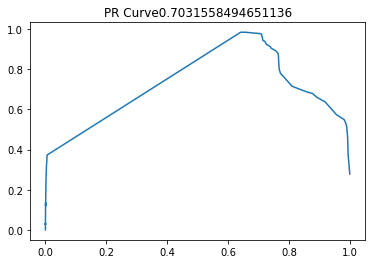

  0%|          | 1/400 [00:01<07:28,  1.12s/it]

Epoch loss :: 151.21736


  0%|          | 2/400 [00:02<07:51,  1.18s/it]

Epoch loss :: 151.3603


  1%|          | 3/400 [00:03<08:08,  1.23s/it]

Epoch loss :: 151.46288


  1%|          | 4/400 [00:05<08:39,  1.31s/it]

Epoch loss :: 151.52284


  1%|▏         | 5/400 [00:06<08:25,  1.28s/it]

Epoch loss :: 150.8683


  2%|▏         | 6/400 [00:07<08:00,  1.22s/it]

Epoch loss :: 151.11705


  2%|▏         | 7/400 [00:08<07:58,  1.22s/it]

Epoch loss :: 151.0807


  2%|▏         | 8/400 [00:09<07:51,  1.20s/it]

Epoch loss :: 151.40886


  2%|▏         | 9/400 [00:11<07:46,  1.19s/it]

Epoch loss :: 150.62518


  2%|▎         | 10/400 [00:12<07:43,  1.19s/it]

Epoch loss :: 150.92274


  3%|▎         | 11/400 [00:13<07:48,  1.20s/it]

Epoch loss :: 151.30817


  3%|▎         | 12/400 [00:14<07:51,  1.22s/it]

Epoch loss :: 151.07005


  3%|▎         | 13/400 [00:15<07:49,  1.21s/it]

Epoch loss :: 150.45813


  4%|▎         | 14/400 [00:17<07:46,  1.21s/it]

Epoch loss :: 150.78937


  4%|▍         | 15/400 [00:18<07:34,  1.18s/it]

Epoch loss :: 151.21417


  4%|▍         | 16/400 [00:19<07:16,  1.14s/it]

Epoch loss :: 151.3529


  4%|▍         | 17/400 [00:20<07:21,  1.15s/it]

Epoch loss :: 151.30962


  4%|▍         | 18/400 [00:21<07:29,  1.18s/it]

Epoch loss :: 150.89299


  5%|▍         | 19/400 [00:23<07:38,  1.20s/it]

Epoch loss :: 151.39731


  5%|▌         | 20/400 [00:24<07:32,  1.19s/it]

Epoch loss :: 151.09644


  5%|▌         | 21/400 [00:25<07:18,  1.16s/it]

Epoch loss :: 151.22066


  6%|▌         | 22/400 [00:26<07:14,  1.15s/it]

Epoch loss :: 151.12018


  6%|▌         | 23/400 [00:27<07:23,  1.18s/it]

Epoch loss :: 150.80463


  6%|▌         | 24/400 [00:28<07:11,  1.15s/it]

Epoch loss :: 151.03612


  6%|▋         | 25/400 [00:29<07:10,  1.15s/it]

Epoch loss :: 151.16728


  6%|▋         | 26/400 [00:31<07:21,  1.18s/it]

Epoch loss :: 151.05568


  7%|▋         | 27/400 [00:32<07:23,  1.19s/it]

Epoch loss :: 151.02098


  7%|▋         | 28/400 [00:33<07:26,  1.20s/it]

Epoch loss :: 150.97136


  7%|▋         | 29/400 [00:34<07:09,  1.16s/it]

Epoch loss :: 151.07129


  8%|▊         | 30/400 [00:35<07:15,  1.18s/it]

Epoch loss :: 151.51776


  8%|▊         | 31/400 [00:37<07:15,  1.18s/it]

Epoch loss :: 150.90541


  8%|▊         | 32/400 [00:38<07:06,  1.16s/it]

Epoch loss :: 150.72594


  8%|▊         | 33/400 [00:39<07:08,  1.17s/it]

Epoch loss :: 151.27592


  8%|▊         | 34/400 [00:40<07:21,  1.21s/it]

Epoch loss :: 151.15837


  9%|▉         | 35/400 [00:41<07:11,  1.18s/it]

Epoch loss :: 151.47717


  9%|▉         | 36/400 [00:42<07:02,  1.16s/it]

Epoch loss :: 150.75237


  9%|▉         | 37/400 [00:44<07:16,  1.20s/it]

Epoch loss :: 150.89053


 10%|▉         | 38/400 [00:45<07:26,  1.23s/it]

Epoch loss :: 151.01598


 10%|▉         | 39/400 [00:46<07:08,  1.19s/it]

Epoch loss :: 151.06458


 10%|█         | 40/400 [00:47<06:53,  1.15s/it]

Epoch loss :: 150.96806


 10%|█         | 41/400 [00:48<06:54,  1.16s/it]

Epoch loss :: 151.17526


 10%|█         | 42/400 [00:49<06:33,  1.10s/it]

Epoch loss :: 151.17949


 11%|█         | 43/400 [00:50<06:42,  1.13s/it]

Epoch loss :: 151.16081


 11%|█         | 44/400 [00:52<06:41,  1.13s/it]

Epoch loss :: 151.17776


 11%|█▏        | 45/400 [00:53<06:56,  1.17s/it]

Epoch loss :: 150.87892


 12%|█▏        | 46/400 [00:54<06:48,  1.15s/it]

Epoch loss :: 150.83856


 12%|█▏        | 47/400 [00:55<06:51,  1.17s/it]

Epoch loss :: 150.93413


 12%|█▏        | 48/400 [00:56<07:02,  1.20s/it]

Epoch loss :: 151.03552


 12%|█▏        | 49/400 [00:57<06:37,  1.13s/it]

Epoch loss :: 150.7828


 12%|█▎        | 50/400 [00:58<06:29,  1.11s/it]

Epoch loss :: 150.96194


 13%|█▎        | 51/400 [01:00<06:50,  1.18s/it]

Epoch loss :: 151.07765


 13%|█▎        | 52/400 [01:01<06:45,  1.17s/it]

Epoch loss :: 151.1008


 13%|█▎        | 53/400 [01:02<06:45,  1.17s/it]

Epoch loss :: 151.23206


 14%|█▎        | 54/400 [01:03<07:00,  1.21s/it]

Epoch loss :: 150.96405


 14%|█▍        | 55/400 [01:05<07:16,  1.26s/it]

Epoch loss :: 151.31015


 14%|█▍        | 56/400 [01:06<07:23,  1.29s/it]

Epoch loss :: 151.03401


 14%|█▍        | 57/400 [01:08<07:28,  1.31s/it]

Epoch loss :: 151.11003


 14%|█▍        | 58/400 [01:09<07:15,  1.27s/it]

Epoch loss :: 150.683


 15%|█▍        | 59/400 [01:10<07:24,  1.30s/it]

Epoch loss :: 150.96501


 15%|█▌        | 60/400 [01:11<07:11,  1.27s/it]

Epoch loss :: 151.61551


 15%|█▌        | 61/400 [01:12<07:04,  1.25s/it]

Epoch loss :: 150.77213


 16%|█▌        | 62/400 [01:14<07:01,  1.25s/it]

Epoch loss :: 150.87651


 16%|█▌        | 63/400 [01:15<07:02,  1.25s/it]

Epoch loss :: 150.88507


 16%|█▌        | 64/400 [01:16<06:52,  1.23s/it]

Epoch loss :: 150.6956


 16%|█▋        | 65/400 [01:18<07:13,  1.29s/it]

Epoch loss :: 150.9782


 16%|█▋        | 66/400 [01:19<06:59,  1.25s/it]

Epoch loss :: 151.25108


 17%|█▋        | 67/400 [01:20<06:54,  1.25s/it]

Epoch loss :: 151.28299


 17%|█▋        | 68/400 [01:21<06:52,  1.24s/it]

Epoch loss :: 151.15845


 17%|█▋        | 69/400 [01:23<06:57,  1.26s/it]

Epoch loss :: 151.0501


 18%|█▊        | 70/400 [01:24<06:52,  1.25s/it]

Epoch loss :: 150.9268


 18%|█▊        | 71/400 [01:25<06:49,  1.24s/it]

Epoch loss :: 150.67458


 18%|█▊        | 72/400 [01:26<06:49,  1.25s/it]

Epoch loss :: 150.71465


 18%|█▊        | 73/400 [01:28<06:57,  1.28s/it]

Epoch loss :: 150.8618


 18%|█▊        | 74/400 [01:29<06:57,  1.28s/it]

Epoch loss :: 151.31985


 19%|█▉        | 75/400 [01:30<06:26,  1.19s/it]

Epoch loss :: 150.60776


 19%|█▉        | 76/400 [01:31<06:31,  1.21s/it]

Epoch loss :: 151.10779


 19%|█▉        | 77/400 [01:32<06:10,  1.15s/it]

Epoch loss :: 151.1576


 20%|█▉        | 78/400 [01:33<06:02,  1.12s/it]

Epoch loss :: 150.8896


 20%|█▉        | 79/400 [01:35<06:20,  1.19s/it]

Epoch loss :: 151.0517


 20%|██        | 80/400 [01:36<06:16,  1.18s/it]

Epoch loss :: 151.28389


 20%|██        | 81/400 [01:37<06:06,  1.15s/it]

Epoch loss :: 150.85197


 20%|██        | 82/400 [01:38<05:57,  1.12s/it]

Epoch loss :: 151.2462


 21%|██        | 83/400 [01:39<06:04,  1.15s/it]

Epoch loss :: 150.98932


 21%|██        | 84/400 [01:40<06:08,  1.17s/it]

Epoch loss :: 150.72652


 21%|██▏       | 85/400 [01:41<06:06,  1.16s/it]

Epoch loss :: 151.24269


 22%|██▏       | 86/400 [01:43<06:15,  1.20s/it]

Epoch loss :: 150.70992


 22%|██▏       | 87/400 [01:44<06:14,  1.20s/it]

Epoch loss :: 150.74901


 22%|██▏       | 88/400 [01:45<06:13,  1.20s/it]

Epoch loss :: 151.14348


 22%|██▏       | 89/400 [01:46<06:12,  1.20s/it]

Epoch loss :: 150.62749


 22%|██▎       | 90/400 [01:47<05:58,  1.16s/it]

Epoch loss :: 151.23454


 23%|██▎       | 91/400 [01:48<05:57,  1.16s/it]

Epoch loss :: 150.87991


 23%|██▎       | 92/400 [01:50<05:58,  1.16s/it]

Epoch loss :: 150.87114


 23%|██▎       | 93/400 [01:51<06:04,  1.19s/it]

Epoch loss :: 150.7136


 24%|██▎       | 94/400 [01:52<06:03,  1.19s/it]

Epoch loss :: 150.73994


 24%|██▍       | 95/400 [01:53<06:04,  1.20s/it]

Epoch loss :: 151.30495


 24%|██▍       | 96/400 [01:55<06:07,  1.21s/it]

Epoch loss :: 150.84343


 24%|██▍       | 97/400 [01:56<06:07,  1.21s/it]

Epoch loss :: 151.00285


 24%|██▍       | 98/400 [01:57<06:30,  1.29s/it]

Epoch loss :: 150.83218


 25%|██▍       | 99/400 [01:58<06:24,  1.28s/it]

Epoch loss :: 151.19234


 25%|██▌       | 100/400 [02:00<06:22,  1.28s/it]

Epoch loss :: 150.68147


 25%|██▌       | 101/400 [02:01<06:08,  1.23s/it]

Epoch loss :: 151.09503


 26%|██▌       | 102/400 [02:02<06:02,  1.22s/it]

Epoch loss :: 150.81519


 26%|██▌       | 103/400 [02:03<06:19,  1.28s/it]

Epoch loss :: 151.17686


 26%|██▌       | 104/400 [02:05<06:32,  1.33s/it]

Epoch loss :: 150.77496


 26%|██▋       | 105/400 [02:06<06:30,  1.32s/it]

Epoch loss :: 150.85616


 26%|██▋       | 106/400 [02:07<06:22,  1.30s/it]

Epoch loss :: 151.12071


 27%|██▋       | 107/400 [02:09<06:04,  1.24s/it]

Epoch loss :: 151.15172


 27%|██▋       | 108/400 [02:10<06:01,  1.24s/it]

Epoch loss :: 150.8438


 27%|██▋       | 109/400 [02:11<05:54,  1.22s/it]

Epoch loss :: 151.10052


 28%|██▊       | 110/400 [02:12<05:43,  1.18s/it]

Epoch loss :: 151.51099


 28%|██▊       | 111/400 [02:13<05:48,  1.21s/it]

Epoch loss :: 150.96568


 28%|██▊       | 112/400 [02:15<05:59,  1.25s/it]

Epoch loss :: 150.95589


 28%|██▊       | 113/400 [02:16<05:57,  1.25s/it]

Epoch loss :: 150.84328


 28%|██▊       | 114/400 [02:17<06:07,  1.28s/it]

Epoch loss :: 150.66466


 29%|██▉       | 115/400 [02:18<05:31,  1.16s/it]

Epoch loss :: 151.29976


 29%|██▉       | 116/400 [02:19<05:31,  1.17s/it]

Epoch loss :: 151.158


 29%|██▉       | 117/400 [02:20<05:26,  1.15s/it]

Epoch loss :: 150.8055


 30%|██▉       | 118/400 [02:22<05:39,  1.20s/it]

Epoch loss :: 150.99654


 30%|██▉       | 119/400 [02:23<05:35,  1.19s/it]

Epoch loss :: 151.31108


 30%|███       | 120/400 [02:24<05:36,  1.20s/it]

Epoch loss :: 151.1029


 30%|███       | 121/400 [02:25<05:31,  1.19s/it]

Epoch loss :: 151.05653


 30%|███       | 122/400 [02:27<05:49,  1.26s/it]

Epoch loss :: 151.17273


 31%|███       | 123/400 [02:28<05:34,  1.21s/it]

Epoch loss :: 150.89249


 31%|███       | 124/400 [02:29<05:36,  1.22s/it]

Epoch loss :: 151.2595


 31%|███▏      | 125/400 [02:30<05:37,  1.23s/it]

Epoch loss :: 151.21164


 32%|███▏      | 126/400 [02:32<05:35,  1.22s/it]

Epoch loss :: 150.75885


 32%|███▏      | 127/400 [02:33<05:37,  1.23s/it]

Epoch loss :: 151.0212


 32%|███▏      | 128/400 [02:34<05:30,  1.22s/it]

Epoch loss :: 150.92725


 32%|███▏      | 129/400 [02:35<05:27,  1.21s/it]

Epoch loss :: 151.03395


 32%|███▎      | 130/400 [02:36<05:22,  1.20s/it]

Epoch loss :: 151.0566


 33%|███▎      | 131/400 [02:38<05:21,  1.19s/it]

Epoch loss :: 150.94322


 33%|███▎      | 132/400 [02:39<05:17,  1.19s/it]

Epoch loss :: 150.77925


 33%|███▎      | 133/400 [02:40<05:30,  1.24s/it]

Epoch loss :: 150.4847


 34%|███▎      | 134/400 [02:41<05:38,  1.27s/it]

Epoch loss :: 151.26648


 34%|███▍      | 135/400 [02:43<05:31,  1.25s/it]

Epoch loss :: 150.99825


 34%|███▍      | 136/400 [02:44<05:30,  1.25s/it]

Epoch loss :: 150.75864


 34%|███▍      | 137/400 [02:45<05:26,  1.24s/it]

Epoch loss :: 151.00763


 34%|███▍      | 138/400 [02:46<05:21,  1.23s/it]

Epoch loss :: 151.13782


 35%|███▍      | 139/400 [02:48<05:23,  1.24s/it]

Epoch loss :: 151.1576


 35%|███▌      | 140/400 [02:49<05:19,  1.23s/it]

Epoch loss :: 151.1144


 35%|███▌      | 141/400 [02:50<05:23,  1.25s/it]

Epoch loss :: 150.97453


 36%|███▌      | 142/400 [02:51<05:19,  1.24s/it]

Epoch loss :: 151.01521


 36%|███▌      | 143/400 [02:52<05:07,  1.20s/it]

Epoch loss :: 151.13509


 36%|███▌      | 144/400 [02:53<04:57,  1.16s/it]

Epoch loss :: 150.88528


 36%|███▋      | 145/400 [02:54<04:44,  1.12s/it]

Epoch loss :: 151.54375


 36%|███▋      | 146/400 [02:56<04:57,  1.17s/it]

Epoch loss :: 151.16063


 37%|███▋      | 147/400 [02:57<05:03,  1.20s/it]

Epoch loss :: 151.255


 37%|███▋      | 148/400 [02:58<05:06,  1.22s/it]

Epoch loss :: 151.02065


 37%|███▋      | 149/400 [03:00<05:07,  1.23s/it]

Epoch loss :: 151.0825


 38%|███▊      | 150/400 [03:01<05:16,  1.26s/it]

Epoch loss :: 150.96935


 38%|███▊      | 151/400 [03:02<05:19,  1.28s/it]

Epoch loss :: 150.83989


 38%|███▊      | 152/400 [03:03<05:14,  1.27s/it]

Epoch loss :: 150.70729


 38%|███▊      | 153/400 [03:05<05:16,  1.28s/it]

Epoch loss :: 151.33957


 38%|███▊      | 154/400 [03:06<05:14,  1.28s/it]

Epoch loss :: 150.75182


 39%|███▉      | 155/400 [03:07<05:09,  1.26s/it]

Epoch loss :: 151.17213


 39%|███▉      | 156/400 [03:09<05:09,  1.27s/it]

Epoch loss :: 151.04088


 39%|███▉      | 157/400 [03:10<05:04,  1.25s/it]

Epoch loss :: 150.90828


 40%|███▉      | 158/400 [03:11<04:59,  1.24s/it]

Epoch loss :: 151.02339


 40%|███▉      | 159/400 [03:12<04:54,  1.22s/it]

Epoch loss :: 151.29103


 40%|████      | 160/400 [03:13<04:49,  1.20s/it]

Epoch loss :: 151.18094


 40%|████      | 161/400 [03:15<04:47,  1.20s/it]

Epoch loss :: 150.65678


 40%|████      | 162/400 [03:16<04:54,  1.24s/it]

Epoch loss :: 151.0248


 41%|████      | 163/400 [03:17<04:55,  1.24s/it]

Epoch loss :: 150.71973


 41%|████      | 164/400 [03:18<04:38,  1.18s/it]

Epoch loss :: 150.9694


 41%|████▏     | 165/400 [03:19<04:43,  1.20s/it]

Epoch loss :: 150.9112


 42%|████▏     | 166/400 [03:21<04:46,  1.22s/it]

Epoch loss :: 151.19908


 42%|████▏     | 167/400 [03:22<04:31,  1.16s/it]

Epoch loss :: 150.79924


 42%|████▏     | 168/400 [03:23<04:49,  1.25s/it]

Epoch loss :: 150.97478


 42%|████▏     | 169/400 [03:24<04:51,  1.26s/it]

Epoch loss :: 150.9257


 42%|████▎     | 170/400 [03:26<04:49,  1.26s/it]

Epoch loss :: 150.82268


 43%|████▎     | 171/400 [03:27<04:50,  1.27s/it]

Epoch loss :: 151.16644


 43%|████▎     | 172/400 [03:28<04:58,  1.31s/it]

Epoch loss :: 151.12006


 43%|████▎     | 173/400 [03:29<04:31,  1.20s/it]

Epoch loss :: 150.69078


 44%|████▎     | 174/400 [03:30<04:30,  1.20s/it]

Epoch loss :: 150.95091


 44%|████▍     | 175/400 [03:32<04:27,  1.19s/it]

Epoch loss :: 151.03162


 44%|████▍     | 176/400 [03:33<04:25,  1.19s/it]

Epoch loss :: 150.85078


 44%|████▍     | 177/400 [03:34<04:08,  1.11s/it]

Epoch loss :: 151.15439


 44%|████▍     | 178/400 [03:35<04:14,  1.15s/it]

Epoch loss :: 150.88655


 45%|████▍     | 179/400 [03:36<04:20,  1.18s/it]

Epoch loss :: 151.04607


 45%|████▌     | 180/400 [03:37<04:20,  1.18s/it]

Epoch loss :: 150.85876


 45%|████▌     | 181/400 [03:39<04:26,  1.22s/it]

Epoch loss :: 151.18388


 46%|████▌     | 182/400 [03:40<04:26,  1.22s/it]

Epoch loss :: 151.15741


 46%|████▌     | 183/400 [03:41<04:27,  1.23s/it]

Epoch loss :: 151.08838


 46%|████▌     | 184/400 [03:42<04:21,  1.21s/it]

Epoch loss :: 151.16255


 46%|████▋     | 185/400 [03:44<04:22,  1.22s/it]

Epoch loss :: 151.01955


 46%|████▋     | 186/400 [03:45<04:19,  1.21s/it]

Epoch loss :: 151.18248


 47%|████▋     | 187/400 [03:46<04:22,  1.23s/it]

Epoch loss :: 150.83998


 47%|████▋     | 188/400 [03:47<04:22,  1.24s/it]

Epoch loss :: 150.88383


 47%|████▋     | 189/400 [03:49<04:20,  1.23s/it]

Epoch loss :: 151.44041


 48%|████▊     | 190/400 [03:50<04:20,  1.24s/it]

Epoch loss :: 151.00404


 48%|████▊     | 191/400 [03:51<04:22,  1.25s/it]

Epoch loss :: 150.74348


 48%|████▊     | 192/400 [03:52<04:18,  1.24s/it]

Epoch loss :: 150.961


 48%|████▊     | 193/400 [03:54<04:17,  1.25s/it]

Epoch loss :: 150.72682


 48%|████▊     | 194/400 [03:55<04:19,  1.26s/it]

Epoch loss :: 151.17819


 49%|████▉     | 195/400 [03:56<04:21,  1.27s/it]

Epoch loss :: 150.99133


 49%|████▉     | 196/400 [03:58<04:21,  1.28s/it]

Epoch loss :: 151.12364


 49%|████▉     | 197/400 [03:59<04:17,  1.27s/it]

Epoch loss :: 151.11855


 50%|████▉     | 198/400 [04:00<04:17,  1.27s/it]

Epoch loss :: 150.92442


 50%|████▉     | 199/400 [04:01<04:09,  1.24s/it]

Epoch loss :: 150.96092


 50%|█████     | 200/400 [04:02<04:07,  1.24s/it]

Epoch loss :: 151.04051


 50%|█████     | 201/400 [04:04<04:10,  1.26s/it]

Epoch loss :: 150.76862


 50%|█████     | 202/400 [04:05<04:10,  1.27s/it]

Epoch loss :: 151.13033


 51%|█████     | 203/400 [04:06<04:04,  1.24s/it]

Epoch loss :: 151.09366


 51%|█████     | 204/400 [04:07<04:00,  1.23s/it]

Epoch loss :: 150.77931


 51%|█████▏    | 205/400 [04:09<04:08,  1.27s/it]

Epoch loss :: 151.18056


 52%|█████▏    | 206/400 [04:10<04:04,  1.26s/it]

Epoch loss :: 150.9369


 52%|█████▏    | 207/400 [04:11<04:07,  1.28s/it]

Epoch loss :: 151.01433


 52%|█████▏    | 208/400 [04:13<04:06,  1.28s/it]

Epoch loss :: 151.16383


 52%|█████▏    | 209/400 [04:14<04:01,  1.27s/it]

Epoch loss :: 151.14783


 52%|█████▎    | 210/400 [04:15<03:55,  1.24s/it]

Epoch loss :: 151.2073


 53%|█████▎    | 211/400 [04:16<04:02,  1.28s/it]

Epoch loss :: 151.07796


 53%|█████▎    | 212/400 [04:18<03:59,  1.27s/it]

Epoch loss :: 151.16908


 53%|█████▎    | 213/400 [04:19<03:52,  1.24s/it]

Epoch loss :: 150.87947


 54%|█████▎    | 214/400 [04:20<03:48,  1.23s/it]

Epoch loss :: 150.80833


 54%|█████▍    | 215/400 [04:21<03:47,  1.23s/it]

Epoch loss :: 151.37157


 54%|█████▍    | 216/400 [04:22<03:44,  1.22s/it]

Epoch loss :: 150.7135


 54%|█████▍    | 217/400 [04:24<03:36,  1.19s/it]

Epoch loss :: 151.10408


 55%|█████▍    | 218/400 [04:25<03:27,  1.14s/it]

Epoch loss :: 151.08864


 55%|█████▍    | 219/400 [04:26<03:26,  1.14s/it]

Epoch loss :: 151.14253


 55%|█████▌    | 220/400 [04:27<03:25,  1.14s/it]

Epoch loss :: 151.13293


 55%|█████▌    | 221/400 [04:28<03:30,  1.18s/it]

Epoch loss :: 150.92093


 56%|█████▌    | 222/400 [04:29<03:25,  1.15s/it]

Epoch loss :: 151.02327


 56%|█████▌    | 223/400 [04:30<03:16,  1.11s/it]

Epoch loss :: 150.8637


 56%|█████▌    | 224/400 [04:32<03:24,  1.16s/it]

Epoch loss :: 150.81459


 56%|█████▋    | 225/400 [04:33<03:29,  1.19s/it]

Epoch loss :: 150.9561


 56%|█████▋    | 226/400 [04:34<03:25,  1.18s/it]

Epoch loss :: 150.7519


 57%|█████▋    | 227/400 [04:35<03:28,  1.21s/it]

Epoch loss :: 151.05214


 57%|█████▋    | 228/400 [04:36<03:15,  1.14s/it]

Epoch loss :: 150.72285


 57%|█████▋    | 229/400 [04:37<03:21,  1.18s/it]

Epoch loss :: 151.25995


 57%|█████▊    | 230/400 [04:39<03:23,  1.19s/it]

Epoch loss :: 150.8197


 58%|█████▊    | 231/400 [04:40<03:23,  1.20s/it]

Epoch loss :: 150.8751


 58%|█████▊    | 232/400 [04:41<03:22,  1.20s/it]

Epoch loss :: 151.24905


 58%|█████▊    | 233/400 [04:42<03:25,  1.23s/it]

Epoch loss :: 151.27214


 58%|█████▊    | 234/400 [04:44<03:26,  1.24s/it]

Epoch loss :: 151.15668


 59%|█████▉    | 235/400 [04:45<03:21,  1.22s/it]

Epoch loss :: 151.44093


 59%|█████▉    | 236/400 [04:46<03:18,  1.21s/it]

Epoch loss :: 150.58292


 59%|█████▉    | 237/400 [04:47<03:20,  1.23s/it]

Epoch loss :: 151.19844


 60%|█████▉    | 238/400 [04:48<03:15,  1.21s/it]

Epoch loss :: 150.98558


 60%|█████▉    | 239/400 [04:50<03:16,  1.22s/it]

Epoch loss :: 151.11218


 60%|██████    | 240/400 [04:51<03:12,  1.20s/it]

Epoch loss :: 150.9958


 60%|██████    | 241/400 [04:52<03:13,  1.22s/it]

Epoch loss :: 151.05898


 60%|██████    | 242/400 [04:53<03:16,  1.25s/it]

Epoch loss :: 151.62631


 61%|██████    | 243/400 [04:54<03:03,  1.17s/it]

Epoch loss :: 150.83891


 61%|██████    | 244/400 [04:56<03:04,  1.18s/it]

Epoch loss :: 150.89568


 61%|██████▏   | 245/400 [04:57<03:05,  1.20s/it]

Epoch loss :: 150.8748


 62%|██████▏   | 246/400 [04:58<03:09,  1.23s/it]

Epoch loss :: 151.20842


 62%|██████▏   | 247/400 [04:59<03:07,  1.23s/it]

Epoch loss :: 150.79549


 62%|██████▏   | 248/400 [05:01<03:06,  1.22s/it]

Epoch loss :: 151.42096


 62%|██████▏   | 249/400 [05:02<03:07,  1.24s/it]

Epoch loss :: 150.79353


 62%|██████▎   | 250/400 [05:03<03:00,  1.20s/it]

Epoch loss :: 151.11092


 63%|██████▎   | 251/400 [05:04<03:00,  1.21s/it]

Epoch loss :: 151.08266


 63%|██████▎   | 252/400 [05:05<02:58,  1.21s/it]

Epoch loss :: 151.40822


 63%|██████▎   | 253/400 [05:07<02:50,  1.16s/it]

Epoch loss :: 151.03807


 64%|██████▎   | 254/400 [05:08<02:45,  1.13s/it]

Epoch loss :: 151.43193


 64%|██████▍   | 255/400 [05:09<02:50,  1.17s/it]

Epoch loss :: 151.2397


 64%|██████▍   | 256/400 [05:10<02:47,  1.16s/it]

Epoch loss :: 150.85799


 64%|██████▍   | 257/400 [05:11<02:49,  1.19s/it]

Epoch loss :: 150.92326


 64%|██████▍   | 258/400 [05:12<02:44,  1.16s/it]

Epoch loss :: 151.49266


 65%|██████▍   | 259/400 [05:14<02:52,  1.22s/it]

Epoch loss :: 150.80597


 65%|██████▌   | 260/400 [05:15<02:53,  1.24s/it]

Epoch loss :: 150.93524


 65%|██████▌   | 261/400 [05:16<02:48,  1.21s/it]

Epoch loss :: 151.1346


 66%|██████▌   | 262/400 [05:17<02:42,  1.18s/it]

Epoch loss :: 151.30421


 66%|██████▌   | 263/400 [05:18<02:38,  1.16s/it]

Epoch loss :: 150.90828


 66%|██████▌   | 264/400 [05:20<02:41,  1.19s/it]

Epoch loss :: 151.03886


 66%|██████▋   | 265/400 [05:21<02:42,  1.21s/it]

Epoch loss :: 150.96764


 66%|██████▋   | 266/400 [05:22<02:44,  1.22s/it]

Epoch loss :: 150.89107


 67%|██████▋   | 267/400 [05:23<02:45,  1.24s/it]

Epoch loss :: 151.66551


 67%|██████▋   | 268/400 [05:24<02:38,  1.20s/it]

Epoch loss :: 151.10657


 67%|██████▋   | 269/400 [05:26<02:35,  1.19s/it]

Epoch loss :: 150.72917


 68%|██████▊   | 270/400 [05:27<02:36,  1.21s/it]

Epoch loss :: 150.81976


 68%|██████▊   | 271/400 [05:28<02:35,  1.20s/it]

Epoch loss :: 151.222


 68%|██████▊   | 272/400 [05:29<02:29,  1.17s/it]

Epoch loss :: 150.81734


 68%|██████▊   | 273/400 [05:30<02:29,  1.17s/it]

Epoch loss :: 150.99947


 68%|██████▊   | 274/400 [05:31<02:25,  1.15s/it]

Epoch loss :: 150.83076


 69%|██████▉   | 275/400 [05:33<02:26,  1.17s/it]

Epoch loss :: 151.12062


 69%|██████▉   | 276/400 [05:34<02:25,  1.17s/it]

Epoch loss :: 151.03725


 69%|██████▉   | 277/400 [05:35<02:18,  1.13s/it]

Epoch loss :: 150.78008


 70%|██████▉   | 278/400 [05:36<02:16,  1.12s/it]

Epoch loss :: 150.92986


 70%|██████▉   | 279/400 [05:37<02:20,  1.16s/it]

Epoch loss :: 151.2611


 70%|███████   | 280/400 [05:39<02:23,  1.20s/it]

Epoch loss :: 151.10674


 70%|███████   | 281/400 [05:40<02:26,  1.23s/it]

Epoch loss :: 150.88728


 70%|███████   | 282/400 [05:41<02:27,  1.25s/it]

Epoch loss :: 150.86598


 71%|███████   | 283/400 [05:42<02:23,  1.22s/it]

Epoch loss :: 150.8675


 71%|███████   | 284/400 [05:44<02:25,  1.25s/it]

Epoch loss :: 151.13889


 71%|███████▏  | 285/400 [05:45<02:29,  1.30s/it]

Epoch loss :: 150.85454


 72%|███████▏  | 286/400 [05:46<02:25,  1.27s/it]

Epoch loss :: 151.15862


 72%|███████▏  | 287/400 [05:47<02:21,  1.25s/it]

Epoch loss :: 151.0601


 72%|███████▏  | 288/400 [05:49<02:21,  1.26s/it]

Epoch loss :: 150.97153


 72%|███████▏  | 289/400 [05:50<02:18,  1.25s/it]

Epoch loss :: 151.18103


 72%|███████▎  | 290/400 [05:51<02:20,  1.28s/it]

Epoch loss :: 151.35678


 73%|███████▎  | 291/400 [05:52<02:14,  1.24s/it]

Epoch loss :: 151.13307


 73%|███████▎  | 292/400 [05:54<02:09,  1.20s/it]

Epoch loss :: 151.17358


 73%|███████▎  | 293/400 [05:55<02:06,  1.18s/it]

Epoch loss :: 150.76328


 74%|███████▎  | 294/400 [05:56<02:00,  1.14s/it]

Epoch loss :: 150.90851


 74%|███████▍  | 295/400 [05:57<02:00,  1.15s/it]

Epoch loss :: 150.97217


 74%|███████▍  | 296/400 [05:58<02:05,  1.21s/it]

Epoch loss :: 150.7606


 74%|███████▍  | 297/400 [06:00<02:06,  1.23s/it]

Epoch loss :: 151.08876


 74%|███████▍  | 298/400 [06:01<02:06,  1.24s/it]

Epoch loss :: 151.34453


 75%|███████▍  | 299/400 [06:02<02:04,  1.23s/it]

Epoch loss :: 150.9695


 75%|███████▌  | 300/400 [06:03<02:03,  1.23s/it]

Epoch loss :: 151.01375


 75%|███████▌  | 301/400 [06:05<02:03,  1.25s/it]

Epoch loss :: 150.85423


 76%|███████▌  | 302/400 [06:06<02:01,  1.24s/it]

Epoch loss :: 151.20708


 76%|███████▌  | 303/400 [06:07<02:00,  1.25s/it]

Epoch loss :: 151.48824


 76%|███████▌  | 304/400 [06:08<02:02,  1.28s/it]

Epoch loss :: 150.8977


 76%|███████▋  | 305/400 [06:10<02:00,  1.27s/it]

Epoch loss :: 150.98073


 76%|███████▋  | 306/400 [06:11<01:59,  1.27s/it]

Epoch loss :: 151.25377


 77%|███████▋  | 307/400 [06:12<01:57,  1.26s/it]

Epoch loss :: 150.88318


 77%|███████▋  | 308/400 [06:13<01:56,  1.26s/it]

Epoch loss :: 151.08015


 77%|███████▋  | 309/400 [06:14<01:41,  1.11s/it]

Epoch loss :: 151.30836


 78%|███████▊  | 310/400 [06:15<01:46,  1.18s/it]

Epoch loss :: 150.76514


 78%|███████▊  | 311/400 [06:17<01:50,  1.25s/it]

Epoch loss :: 150.99477


 78%|███████▊  | 312/400 [06:18<01:54,  1.30s/it]

Epoch loss :: 151.04778


 78%|███████▊  | 313/400 [06:20<01:54,  1.32s/it]

Epoch loss :: 150.73997


 78%|███████▊  | 314/400 [06:21<01:52,  1.31s/it]

Epoch loss :: 150.96074


 79%|███████▉  | 315/400 [06:22<01:52,  1.32s/it]

Epoch loss :: 150.84958


 79%|███████▉  | 316/400 [06:24<01:53,  1.35s/it]

Epoch loss :: 150.78918


 79%|███████▉  | 317/400 [06:25<01:53,  1.37s/it]

Epoch loss :: 150.88863


 80%|███████▉  | 318/400 [06:27<01:53,  1.38s/it]

Epoch loss :: 150.96669


 80%|███████▉  | 319/400 [06:28<01:41,  1.25s/it]

Epoch loss :: 151.12508


 80%|████████  | 320/400 [06:29<01:41,  1.26s/it]

Epoch loss :: 151.32442


 80%|████████  | 321/400 [06:30<01:38,  1.24s/it]

Epoch loss :: 151.12416


 80%|████████  | 322/400 [06:31<01:38,  1.26s/it]

Epoch loss :: 150.87923


 81%|████████  | 323/400 [06:33<01:35,  1.24s/it]

Epoch loss :: 151.09511


 81%|████████  | 324/400 [06:34<01:34,  1.24s/it]

Epoch loss :: 151.09637


 81%|████████▏ | 325/400 [06:35<01:34,  1.26s/it]

Epoch loss :: 150.84492


 82%|████████▏ | 326/400 [06:36<01:34,  1.28s/it]

Epoch loss :: 151.0641


 82%|████████▏ | 327/400 [06:38<01:31,  1.25s/it]

Epoch loss :: 151.04213


 82%|████████▏ | 328/400 [06:39<01:30,  1.25s/it]

Epoch loss :: 151.04497


 82%|████████▏ | 329/400 [06:40<01:28,  1.25s/it]

Epoch loss :: 150.78749


 82%|████████▎ | 330/400 [06:41<01:30,  1.29s/it]

Epoch loss :: 151.025


 83%|████████▎ | 331/400 [06:43<01:27,  1.26s/it]

Epoch loss :: 150.55363


 83%|████████▎ | 332/400 [06:44<01:26,  1.27s/it]

Epoch loss :: 150.73297


 83%|████████▎ | 333/400 [06:45<01:21,  1.21s/it]

Epoch loss :: 150.79268


 84%|████████▎ | 334/400 [06:46<01:21,  1.23s/it]

Epoch loss :: 150.91905


 84%|████████▍ | 335/400 [06:47<01:19,  1.22s/it]

Epoch loss :: 151.06116


 84%|████████▍ | 336/400 [06:49<01:16,  1.20s/it]

Epoch loss :: 150.81026


 84%|████████▍ | 337/400 [06:50<01:16,  1.21s/it]

Epoch loss :: 150.63197


 84%|████████▍ | 338/400 [06:51<01:11,  1.15s/it]

Epoch loss :: 151.073


 85%|████████▍ | 339/400 [06:52<01:13,  1.20s/it]

Epoch loss :: 150.9628


 85%|████████▌ | 340/400 [06:54<01:15,  1.26s/it]

Epoch loss :: 150.97469


 85%|████████▌ | 341/400 [06:55<01:15,  1.27s/it]

Epoch loss :: 151.09381


 86%|████████▌ | 342/400 [06:56<01:08,  1.18s/it]

Epoch loss :: 150.84291


 86%|████████▌ | 343/400 [06:57<01:07,  1.18s/it]

Epoch loss :: 151.08058


 86%|████████▌ | 344/400 [06:58<01:07,  1.20s/it]

Epoch loss :: 150.56512


 86%|████████▋ | 345/400 [06:59<01:04,  1.17s/it]

Epoch loss :: 151.03069


 86%|████████▋ | 346/400 [07:01<01:03,  1.18s/it]

Epoch loss :: 150.79968


 87%|████████▋ | 347/400 [07:02<01:01,  1.16s/it]

Epoch loss :: 150.8196


 87%|████████▋ | 348/400 [07:03<00:59,  1.15s/it]

Epoch loss :: 151.10709


 87%|████████▋ | 349/400 [07:04<00:59,  1.16s/it]

Epoch loss :: 150.84688


 88%|████████▊ | 350/400 [07:05<00:59,  1.19s/it]

Epoch loss :: 150.92317


 88%|████████▊ | 351/400 [07:06<00:56,  1.16s/it]

Epoch loss :: 150.85417


 88%|████████▊ | 352/400 [07:08<00:57,  1.19s/it]

Epoch loss :: 151.07379


 88%|████████▊ | 353/400 [07:09<00:57,  1.22s/it]

Epoch loss :: 151.03456


 88%|████████▊ | 354/400 [07:10<00:56,  1.24s/it]

Epoch loss :: 150.74727


 89%|████████▉ | 355/400 [07:11<00:55,  1.24s/it]

Epoch loss :: 150.75769


 89%|████████▉ | 356/400 [07:13<00:52,  1.20s/it]

Epoch loss :: 150.96396


 89%|████████▉ | 357/400 [07:14<00:53,  1.24s/it]

Epoch loss :: 150.67442


 90%|████████▉ | 358/400 [07:15<00:53,  1.26s/it]

Epoch loss :: 150.93011


 90%|████████▉ | 359/400 [07:16<00:51,  1.26s/it]

Epoch loss :: 151.06917


 90%|█████████ | 360/400 [07:18<00:50,  1.25s/it]

Epoch loss :: 150.90639


 90%|█████████ | 361/400 [07:19<00:48,  1.24s/it]

Epoch loss :: 151.1223


 90%|█████████ | 362/400 [07:20<00:48,  1.27s/it]

Epoch loss :: 151.32481


 91%|█████████ | 363/400 [07:21<00:46,  1.27s/it]

Epoch loss :: 151.15286


 91%|█████████ | 364/400 [07:23<00:44,  1.24s/it]

Epoch loss :: 150.83345


 91%|█████████▏| 365/400 [07:24<00:45,  1.29s/it]

Epoch loss :: 151.11621


 92%|█████████▏| 366/400 [07:25<00:44,  1.32s/it]

Epoch loss :: 151.06732


 92%|█████████▏| 367/400 [07:27<00:42,  1.28s/it]

Epoch loss :: 151.35274


 92%|█████████▏| 368/400 [07:28<00:42,  1.32s/it]

Epoch loss :: 151.20752


 92%|█████████▏| 369/400 [07:29<00:39,  1.28s/it]

Epoch loss :: 150.96313


 92%|█████████▎| 370/400 [07:31<00:38,  1.28s/it]

Epoch loss :: 150.99355


 93%|█████████▎| 371/400 [07:32<00:37,  1.30s/it]

Epoch loss :: 150.89557


 93%|█████████▎| 372/400 [07:33<00:35,  1.27s/it]

Epoch loss :: 150.81268


 93%|█████████▎| 373/400 [07:34<00:34,  1.26s/it]

Epoch loss :: 150.88374


 94%|█████████▎| 374/400 [07:36<00:33,  1.27s/it]

Epoch loss :: 150.86835


 94%|█████████▍| 375/400 [07:37<00:31,  1.26s/it]

Epoch loss :: 151.15868


 94%|█████████▍| 376/400 [07:38<00:30,  1.26s/it]

Epoch loss :: 150.9322


 94%|█████████▍| 377/400 [07:39<00:27,  1.19s/it]

Epoch loss :: 151.26863


 94%|█████████▍| 378/400 [07:41<00:27,  1.25s/it]

Epoch loss :: 150.96892


 95%|█████████▍| 379/400 [07:42<00:26,  1.29s/it]

Epoch loss :: 150.65533


 95%|█████████▌| 380/400 [07:43<00:26,  1.33s/it]

Epoch loss :: 151.43526


 95%|█████████▌| 381/400 [07:44<00:23,  1.26s/it]

Epoch loss :: 150.98566


 96%|█████████▌| 382/400 [07:46<00:22,  1.27s/it]

Epoch loss :: 151.0713


 96%|█████████▌| 383/400 [07:47<00:21,  1.27s/it]

Epoch loss :: 151.06833


 96%|█████████▌| 384/400 [07:48<00:20,  1.31s/it]

Epoch loss :: 151.0885


 96%|█████████▋| 385/400 [07:50<00:19,  1.30s/it]

Epoch loss :: 150.76797


 96%|█████████▋| 386/400 [07:51<00:17,  1.22s/it]

Epoch loss :: 151.06947


 97%|█████████▋| 387/400 [07:52<00:15,  1.18s/it]

Epoch loss :: 150.97842


 97%|█████████▋| 388/400 [07:53<00:14,  1.19s/it]

Epoch loss :: 151.05255


 97%|█████████▋| 389/400 [07:54<00:13,  1.20s/it]

Epoch loss :: 151.13301


 98%|█████████▊| 390/400 [07:55<00:11,  1.19s/it]

Epoch loss :: 151.00298


 98%|█████████▊| 391/400 [07:56<00:10,  1.16s/it]

Epoch loss :: 151.03523


 98%|█████████▊| 392/400 [07:58<00:09,  1.16s/it]

Epoch loss :: 151.09637


 98%|█████████▊| 393/400 [07:59<00:08,  1.16s/it]

Epoch loss :: 150.66756


 98%|█████████▊| 394/400 [08:00<00:07,  1.21s/it]

Epoch loss :: 150.94304


 99%|█████████▉| 395/400 [08:01<00:06,  1.25s/it]

Epoch loss :: 150.86543


 99%|█████████▉| 396/400 [08:03<00:04,  1.22s/it]

Epoch loss :: 150.54625


 99%|█████████▉| 397/400 [08:04<00:03,  1.21s/it]

Epoch loss :: 151.01685


100%|█████████▉| 398/400 [08:05<00:02,  1.21s/it]

Epoch loss :: 151.42567


100%|█████████▉| 399/400 [08:06<00:01,  1.22s/it]

Epoch loss :: 150.96861


100%|██████████| 400/400 [08:08<00:00,  1.22s/it]

Epoch loss :: 151.2494
======================TEST MODE======================


N: 68094
phi : tensor([0.3333, 0.6667], device='cuda:0', grad_fn=<DivBackward0>)
mu :  tensor([[0.1727, 1.0982, 0.0335],
        [0.1728, 1.0971, 0.0357]], device='cuda:0', grad_fn=<DivBackward0>)
covariance : tensor([[[ 6.9081e-05, -1.8524e-04,  3.8185e-04],
         [-1.8524e-04,  2.0781e-03, -3.7944e-03],
         [ 3.8185e-04, -3.7944e-03,  7.7500e-03]],

        [[ 6.9122e-05, -1.8150e-04,  3.7352e-04],
         [-1.8150e-04,  2.0231e-03, -3.6821e-03],
         [ 3.7352e-04, -3.6821e-03,  7.5238e-03]]], device='cuda:0',
       grad_fn=<DivBackward0>)
Size of test  48639
test_energy (48639,)
Precision 0.8807957908582703  Recall 0.8811579899662801  F1 >> 0.8809763531845339
AUC : 0.7251 


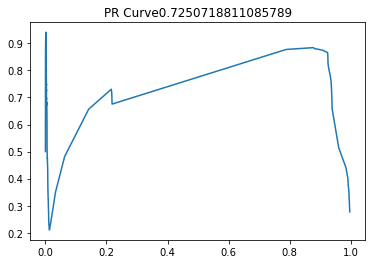

  0%|          | 1/400 [00:01<08:23,  1.26s/it]

Epoch loss :: 82.2316


  0%|          | 2/400 [00:02<08:15,  1.25s/it]

Epoch loss :: 81.67194


  1%|          | 3/400 [00:03<08:09,  1.23s/it]

Epoch loss :: 81.87637


  1%|          | 4/400 [00:04<08:03,  1.22s/it]

Epoch loss :: 81.68496


  1%|▏         | 5/400 [00:06<08:25,  1.28s/it]

Epoch loss :: 81.99261


  2%|▏         | 6/400 [00:07<08:12,  1.25s/it]

Epoch loss :: 81.9598


  2%|▏         | 7/400 [00:08<08:09,  1.25s/it]

Epoch loss :: 81.58846


  2%|▏         | 8/400 [00:09<08:01,  1.23s/it]

Epoch loss :: 82.31776


  2%|▏         | 9/400 [00:11<08:03,  1.24s/it]

Epoch loss :: 82.32782


  2%|▎         | 10/400 [00:12<07:43,  1.19s/it]

Epoch loss :: 81.95333


  3%|▎         | 11/400 [00:13<07:58,  1.23s/it]

Epoch loss :: 81.91213


  3%|▎         | 12/400 [00:14<07:42,  1.19s/it]

Epoch loss :: 81.94482


  3%|▎         | 13/400 [00:15<07:26,  1.15s/it]

Epoch loss :: 81.89514


  4%|▎         | 14/400 [00:16<07:24,  1.15s/it]

Epoch loss :: 81.86419


  4%|▍         | 15/400 [00:17<07:17,  1.14s/it]

Epoch loss :: 81.47059


  4%|▍         | 16/400 [00:19<07:16,  1.14s/it]

Epoch loss :: 81.950775


  4%|▍         | 17/400 [00:20<06:57,  1.09s/it]

Epoch loss :: 81.73242


  4%|▍         | 18/400 [00:21<07:22,  1.16s/it]

Epoch loss :: 81.80069


  5%|▍         | 19/400 [00:22<07:25,  1.17s/it]

Epoch loss :: 82.32911


  5%|▌         | 20/400 [00:23<07:17,  1.15s/it]

Epoch loss :: 81.95265


  5%|▌         | 21/400 [00:24<07:04,  1.12s/it]

Epoch loss :: 81.967125


  6%|▌         | 22/400 [00:25<06:52,  1.09s/it]

Epoch loss :: 81.74961


  6%|▌         | 23/400 [00:27<07:12,  1.15s/it]

Epoch loss :: 81.76591


  6%|▌         | 24/400 [00:28<07:20,  1.17s/it]

Epoch loss :: 81.70807


  6%|▋         | 25/400 [00:29<07:09,  1.15s/it]

Epoch loss :: 82.15897


  6%|▋         | 26/400 [00:30<06:51,  1.10s/it]

Epoch loss :: 81.91848


  7%|▋         | 27/400 [00:31<06:49,  1.10s/it]

Epoch loss :: 81.849556


  7%|▋         | 28/400 [00:32<07:00,  1.13s/it]

Epoch loss :: 81.8859


  7%|▋         | 29/400 [00:33<06:59,  1.13s/it]

Epoch loss :: 82.11738


  8%|▊         | 30/400 [00:34<06:39,  1.08s/it]

Epoch loss :: 81.88116


  8%|▊         | 31/400 [00:35<06:30,  1.06s/it]

Epoch loss :: 81.957085


  8%|▊         | 32/400 [00:36<06:45,  1.10s/it]

Epoch loss :: 81.994545


  8%|▊         | 33/400 [00:38<06:43,  1.10s/it]

Epoch loss :: 81.865654


  8%|▊         | 34/400 [00:39<06:30,  1.07s/it]

Epoch loss :: 82.07159


  9%|▉         | 35/400 [00:40<06:36,  1.09s/it]

Epoch loss :: 81.74124


  9%|▉         | 36/400 [00:41<06:35,  1.09s/it]

Epoch loss :: 81.79395


  9%|▉         | 37/400 [00:42<06:30,  1.08s/it]

Epoch loss :: 81.77698


 10%|▉         | 38/400 [00:43<06:19,  1.05s/it]

Epoch loss :: 81.81025


 10%|▉         | 39/400 [00:44<06:29,  1.08s/it]

Epoch loss :: 81.90503


 10%|█         | 40/400 [00:45<06:27,  1.08s/it]

Epoch loss :: 81.83224


 10%|█         | 41/400 [00:46<06:37,  1.11s/it]

Epoch loss :: 81.607796


 10%|█         | 42/400 [00:47<06:42,  1.13s/it]

Epoch loss :: 82.48516


 11%|█         | 43/400 [00:49<06:50,  1.15s/it]

Epoch loss :: 81.99784


 11%|█         | 44/400 [00:50<06:58,  1.18s/it]

Epoch loss :: 81.769844


 11%|█▏        | 45/400 [00:51<07:24,  1.25s/it]

Epoch loss :: 81.69415


 12%|█▏        | 46/400 [00:53<07:24,  1.26s/it]

Epoch loss :: 81.76837


 12%|█▏        | 47/400 [00:54<07:26,  1.27s/it]

Epoch loss :: 81.82653


 12%|█▏        | 48/400 [00:55<07:46,  1.33s/it]

Epoch loss :: 81.780235


 12%|█▏        | 49/400 [00:56<07:21,  1.26s/it]

Epoch loss :: 81.8926


 12%|█▎        | 50/400 [00:57<07:01,  1.20s/it]

Epoch loss :: 81.64575


 13%|█▎        | 51/400 [00:59<07:13,  1.24s/it]

Epoch loss :: 81.98893


 13%|█▎        | 52/400 [01:00<07:11,  1.24s/it]

Epoch loss :: 82.00382


 13%|█▎        | 53/400 [01:01<07:01,  1.21s/it]

Epoch loss :: 81.98797


 14%|█▎        | 54/400 [01:02<06:33,  1.14s/it]

Epoch loss :: 81.94516


 14%|█▍        | 55/400 [01:03<06:42,  1.17s/it]

Epoch loss :: 81.86603


 14%|█▍        | 56/400 [01:04<06:33,  1.14s/it]

Epoch loss :: 82.119446


 14%|█▍        | 57/400 [01:06<06:30,  1.14s/it]

Epoch loss :: 81.756905


 14%|█▍        | 58/400 [01:07<06:29,  1.14s/it]

Epoch loss :: 82.02337


 15%|█▍        | 59/400 [01:08<06:33,  1.15s/it]

Epoch loss :: 82.03307


 15%|█▌        | 60/400 [01:09<06:30,  1.15s/it]

Epoch loss :: 82.00782


 15%|█▌        | 61/400 [01:10<06:20,  1.12s/it]

Epoch loss :: 81.96534


 16%|█▌        | 62/400 [01:11<06:02,  1.07s/it]

Epoch loss :: 81.775795


 16%|█▌        | 63/400 [01:12<06:22,  1.14s/it]

Epoch loss :: 82.00196


 16%|█▌        | 64/400 [01:13<06:16,  1.12s/it]

Epoch loss :: 82.190125


 16%|█▋        | 65/400 [01:14<06:08,  1.10s/it]

Epoch loss :: 81.831985


 16%|█▋        | 66/400 [01:16<06:12,  1.12s/it]

Epoch loss :: 81.619446


 17%|█▋        | 67/400 [01:17<06:29,  1.17s/it]

Epoch loss :: 82.05146


 17%|█▋        | 68/400 [01:18<06:12,  1.12s/it]

Epoch loss :: 81.51531


 17%|█▋        | 69/400 [01:19<06:10,  1.12s/it]

Epoch loss :: 81.947395


 18%|█▊        | 70/400 [01:20<06:08,  1.12s/it]

Epoch loss :: 81.79861


 18%|█▊        | 71/400 [01:21<05:55,  1.08s/it]

Epoch loss :: 81.710556


 18%|█▊        | 72/400 [01:22<06:08,  1.12s/it]

Epoch loss :: 82.03931


 18%|█▊        | 73/400 [01:24<06:12,  1.14s/it]

Epoch loss :: 81.95127


 18%|█▊        | 74/400 [01:25<06:07,  1.13s/it]

Epoch loss :: 81.87774


 19%|█▉        | 75/400 [01:26<05:52,  1.08s/it]

Epoch loss :: 81.91445


 19%|█▉        | 76/400 [01:27<06:11,  1.15s/it]

Epoch loss :: 81.784256


 19%|█▉        | 77/400 [01:28<06:06,  1.14s/it]

Epoch loss :: 81.84838


 20%|█▉        | 78/400 [01:29<06:17,  1.17s/it]

Epoch loss :: 82.04196


 20%|█▉        | 79/400 [01:30<06:15,  1.17s/it]

Epoch loss :: 81.898254


 20%|██        | 80/400 [01:32<06:24,  1.20s/it]

Epoch loss :: 81.775116


 20%|██        | 81/400 [01:33<06:02,  1.14s/it]

Epoch loss :: 81.70716


 20%|██        | 82/400 [01:34<06:37,  1.25s/it]

Epoch loss :: 81.94693


 21%|██        | 83/400 [01:36<07:00,  1.32s/it]

Epoch loss :: 82.250244


 21%|██        | 84/400 [01:37<07:05,  1.35s/it]

Epoch loss :: 81.72171


 21%|██▏       | 85/400 [01:38<06:57,  1.33s/it]

Epoch loss :: 82.09151


 22%|██▏       | 86/400 [01:40<06:41,  1.28s/it]

Epoch loss :: 81.82618


 22%|██▏       | 87/400 [01:41<06:30,  1.25s/it]

Epoch loss :: 81.78968


 22%|██▏       | 88/400 [01:42<06:26,  1.24s/it]

Epoch loss :: 82.27655


 22%|██▏       | 89/400 [01:43<06:13,  1.20s/it]

Epoch loss :: 82.09019


 22%|██▎       | 90/400 [01:44<05:56,  1.15s/it]

Epoch loss :: 82.05441


 23%|██▎       | 91/400 [01:45<05:56,  1.15s/it]

Epoch loss :: 81.82102


 23%|██▎       | 92/400 [01:47<05:59,  1.17s/it]

Epoch loss :: 81.818146


 23%|██▎       | 93/400 [01:48<06:01,  1.18s/it]

Epoch loss :: 81.87919


 24%|██▎       | 94/400 [01:49<05:50,  1.15s/it]

Epoch loss :: 81.772644


 24%|██▍       | 95/400 [01:50<05:43,  1.13s/it]

Epoch loss :: 81.9936


 24%|██▍       | 96/400 [01:51<05:34,  1.10s/it]

Epoch loss :: 81.81146


 24%|██▍       | 97/400 [01:52<05:35,  1.11s/it]

Epoch loss :: 81.714264


 24%|██▍       | 98/400 [01:53<05:41,  1.13s/it]

Epoch loss :: 82.17223


 25%|██▍       | 99/400 [01:54<05:23,  1.07s/it]

Epoch loss :: 81.637245


 25%|██▌       | 100/400 [01:55<05:30,  1.10s/it]

Epoch loss :: 81.99772


 25%|██▌       | 101/400 [01:57<05:38,  1.13s/it]

Epoch loss :: 81.942116


 26%|██▌       | 102/400 [01:58<05:53,  1.19s/it]

Epoch loss :: 81.67072


 26%|██▌       | 103/400 [01:59<05:59,  1.21s/it]

Epoch loss :: 81.70146


 26%|██▌       | 104/400 [02:00<06:01,  1.22s/it]

Epoch loss :: 82.05004


 26%|██▋       | 105/400 [02:02<05:59,  1.22s/it]

Epoch loss :: 81.73031


 26%|██▋       | 106/400 [02:03<05:46,  1.18s/it]

Epoch loss :: 82.22196


 27%|██▋       | 107/400 [02:04<05:57,  1.22s/it]

Epoch loss :: 81.92617


 27%|██▋       | 108/400 [02:05<05:57,  1.22s/it]

Epoch loss :: 82.029335


 27%|██▋       | 109/400 [02:06<06:02,  1.25s/it]

Epoch loss :: 81.90952


 28%|██▊       | 110/400 [02:08<05:56,  1.23s/it]

Epoch loss :: 81.61385


 28%|██▊       | 111/400 [02:09<06:01,  1.25s/it]

Epoch loss :: 81.72989


 28%|██▊       | 112/400 [02:10<05:59,  1.25s/it]

Epoch loss :: 81.748955


 28%|██▊       | 113/400 [02:11<06:00,  1.26s/it]

Epoch loss :: 81.51508


 28%|██▊       | 114/400 [02:13<05:57,  1.25s/it]

Epoch loss :: 81.75704


 29%|██▉       | 115/400 [02:14<05:57,  1.26s/it]

Epoch loss :: 81.77274


 29%|██▉       | 116/400 [02:15<05:59,  1.26s/it]

Epoch loss :: 82.1032


 29%|██▉       | 117/400 [02:16<05:53,  1.25s/it]

Epoch loss :: 82.01783


 30%|██▉       | 118/400 [02:18<05:57,  1.27s/it]

Epoch loss :: 82.04379


 30%|██▉       | 119/400 [02:19<05:49,  1.25s/it]

Epoch loss :: 81.87681


 30%|███       | 120/400 [02:20<05:40,  1.22s/it]

Epoch loss :: 81.81681


 30%|███       | 121/400 [02:21<05:14,  1.13s/it]

Epoch loss :: 81.86991


 30%|███       | 122/400 [02:22<05:20,  1.15s/it]

Epoch loss :: 81.66593


 31%|███       | 123/400 [02:23<05:12,  1.13s/it]

Epoch loss :: 81.76914


 31%|███       | 124/400 [02:24<04:57,  1.08s/it]

Epoch loss :: 81.73919


 31%|███▏      | 125/400 [02:25<05:01,  1.10s/it]

Epoch loss :: 81.85399


 32%|███▏      | 126/400 [02:27<05:00,  1.10s/it]

Epoch loss :: 81.63654


 32%|███▏      | 127/400 [02:28<05:08,  1.13s/it]

Epoch loss :: 81.69709


 32%|███▏      | 128/400 [02:29<05:08,  1.13s/it]

Epoch loss :: 81.86186


 32%|███▏      | 129/400 [02:30<05:18,  1.18s/it]

Epoch loss :: 81.90295


 32%|███▎      | 130/400 [02:31<05:22,  1.19s/it]

Epoch loss :: 81.92348


 33%|███▎      | 131/400 [02:33<05:30,  1.23s/it]

Epoch loss :: 81.936775


 33%|███▎      | 132/400 [02:34<05:28,  1.23s/it]

Epoch loss :: 81.72387


 33%|███▎      | 133/400 [02:35<05:26,  1.22s/it]

Epoch loss :: 81.68298


 34%|███▎      | 134/400 [02:36<05:32,  1.25s/it]

Epoch loss :: 82.16565


 34%|███▍      | 135/400 [02:38<05:30,  1.25s/it]

Epoch loss :: 82.33663


 34%|███▍      | 136/400 [02:39<05:32,  1.26s/it]

Epoch loss :: 81.62997


 34%|███▍      | 137/400 [02:40<05:15,  1.20s/it]

Epoch loss :: 81.62466


 34%|███▍      | 138/400 [02:41<04:50,  1.11s/it]

Epoch loss :: 81.81943


 35%|███▍      | 139/400 [02:42<05:06,  1.17s/it]

Epoch loss :: 81.89272


 35%|███▌      | 140/400 [02:44<05:14,  1.21s/it]

Epoch loss :: 82.270454


 35%|███▌      | 141/400 [02:45<05:08,  1.19s/it]

Epoch loss :: 81.97254


 36%|███▌      | 142/400 [02:46<04:49,  1.12s/it]

Epoch loss :: 81.59093


 36%|███▌      | 143/400 [02:47<04:46,  1.11s/it]

Epoch loss :: 81.95703


 36%|███▌      | 144/400 [02:48<04:57,  1.16s/it]

Epoch loss :: 81.675285


 36%|███▋      | 145/400 [02:49<04:51,  1.14s/it]

Epoch loss :: 81.876465


 36%|███▋      | 146/400 [02:50<04:54,  1.16s/it]

Epoch loss :: 81.898926


 37%|███▋      | 147/400 [02:52<05:03,  1.20s/it]

Epoch loss :: 81.91129


 37%|███▋      | 148/400 [02:53<05:00,  1.19s/it]

Epoch loss :: 81.61042


 37%|███▋      | 149/400 [02:54<05:07,  1.23s/it]

Epoch loss :: 81.73603


 38%|███▊      | 150/400 [02:55<05:14,  1.26s/it]

Epoch loss :: 82.20438


 38%|███▊      | 151/400 [02:57<05:27,  1.31s/it]

Epoch loss :: 81.94739


 38%|███▊      | 152/400 [02:58<05:12,  1.26s/it]

Epoch loss :: 82.08496


 38%|███▊      | 153/400 [02:59<05:12,  1.27s/it]

Epoch loss :: 82.01409


 38%|███▊      | 154/400 [03:01<05:24,  1.32s/it]

Epoch loss :: 82.05049


 39%|███▉      | 155/400 [03:02<05:21,  1.31s/it]

Epoch loss :: 82.087746


 39%|███▉      | 156/400 [03:03<05:15,  1.29s/it]

Epoch loss :: 82.12783


 39%|███▉      | 157/400 [03:04<05:04,  1.26s/it]

Epoch loss :: 81.765785


 40%|███▉      | 158/400 [03:06<04:49,  1.20s/it]

Epoch loss :: 81.926926


 40%|███▉      | 159/400 [03:07<04:44,  1.18s/it]

Epoch loss :: 81.75481


 40%|████      | 160/400 [03:08<04:57,  1.24s/it]

Epoch loss :: 81.7085


 40%|████      | 161/400 [03:09<04:56,  1.24s/it]

Epoch loss :: 81.890045


 40%|████      | 162/400 [03:10<04:50,  1.22s/it]

Epoch loss :: 81.58813


 41%|████      | 163/400 [03:12<04:41,  1.19s/it]

Epoch loss :: 81.659584


 41%|████      | 164/400 [03:13<04:25,  1.13s/it]

Epoch loss :: 81.8099


 41%|████▏     | 165/400 [03:14<04:21,  1.11s/it]

Epoch loss :: 82.040955


 42%|████▏     | 166/400 [03:15<04:27,  1.14s/it]

Epoch loss :: 81.766365


 42%|████▏     | 167/400 [03:16<04:35,  1.18s/it]

Epoch loss :: 81.92794


 42%|████▏     | 168/400 [03:17<04:27,  1.15s/it]

Epoch loss :: 81.727165


 42%|████▏     | 169/400 [03:18<04:21,  1.13s/it]

Epoch loss :: 81.8203


 42%|████▎     | 170/400 [03:19<04:18,  1.12s/it]

Epoch loss :: 81.86507


 43%|████▎     | 171/400 [03:21<04:18,  1.13s/it]

Epoch loss :: 81.713066


 43%|████▎     | 172/400 [03:22<04:13,  1.11s/it]

Epoch loss :: 81.75468


 43%|████▎     | 173/400 [03:23<04:09,  1.10s/it]

Epoch loss :: 81.74734


 44%|████▎     | 174/400 [03:24<04:11,  1.11s/it]

Epoch loss :: 81.687195


 44%|████▍     | 175/400 [03:25<04:16,  1.14s/it]

Epoch loss :: 81.92376


 44%|████▍     | 176/400 [03:26<04:06,  1.10s/it]

Epoch loss :: 82.27053


 44%|████▍     | 177/400 [03:27<04:04,  1.10s/it]

Epoch loss :: 81.68779


 44%|████▍     | 178/400 [03:28<04:21,  1.18s/it]

Epoch loss :: 81.99862


 45%|████▍     | 179/400 [03:30<04:44,  1.29s/it]

Epoch loss :: 82.108955


 45%|████▌     | 180/400 [03:31<04:49,  1.32s/it]

Epoch loss :: 81.88595


 45%|████▌     | 181/400 [03:33<04:46,  1.31s/it]

Epoch loss :: 81.94213


 46%|████▌     | 182/400 [03:34<04:43,  1.30s/it]

Epoch loss :: 81.946465


 46%|████▌     | 183/400 [03:35<04:41,  1.30s/it]

Epoch loss :: 81.620766


 46%|████▌     | 184/400 [03:36<04:35,  1.27s/it]

Epoch loss :: 82.00543


 46%|████▋     | 185/400 [03:38<04:26,  1.24s/it]

Epoch loss :: 81.882545


 46%|████▋     | 186/400 [03:39<04:29,  1.26s/it]

Epoch loss :: 81.54318


 47%|████▋     | 187/400 [03:40<04:30,  1.27s/it]

Epoch loss :: 82.108635


 47%|████▋     | 188/400 [03:42<04:33,  1.29s/it]

Epoch loss :: 81.945015


 47%|████▋     | 189/400 [03:43<04:30,  1.28s/it]

Epoch loss :: 81.93647


 48%|████▊     | 190/400 [03:44<04:35,  1.31s/it]

Epoch loss :: 82.057976


 48%|████▊     | 191/400 [03:46<04:46,  1.37s/it]

Epoch loss :: 81.53948


 48%|████▊     | 192/400 [03:47<04:37,  1.33s/it]

Epoch loss :: 81.7551


 48%|████▊     | 193/400 [03:48<04:08,  1.20s/it]

Epoch loss :: 81.89051


 48%|████▊     | 194/400 [03:49<04:17,  1.25s/it]

Epoch loss :: 81.7515


 49%|████▉     | 195/400 [03:51<04:23,  1.29s/it]

Epoch loss :: 81.80459


 49%|████▉     | 196/400 [03:52<04:16,  1.26s/it]

Epoch loss :: 81.61965


 49%|████▉     | 197/400 [03:53<04:18,  1.27s/it]

Epoch loss :: 82.10613


 50%|████▉     | 198/400 [03:54<04:18,  1.28s/it]

Epoch loss :: 81.827736


 50%|████▉     | 199/400 [03:56<04:09,  1.24s/it]

Epoch loss :: 81.944695


 50%|█████     | 200/400 [03:57<04:11,  1.26s/it]

Epoch loss :: 81.84934


 50%|█████     | 201/400 [03:58<04:05,  1.24s/it]

Epoch loss :: 81.59231


 50%|█████     | 202/400 [03:59<03:49,  1.16s/it]

Epoch loss :: 82.15456


 51%|█████     | 203/400 [04:00<03:44,  1.14s/it]

Epoch loss :: 81.6695


 51%|█████     | 204/400 [04:01<03:26,  1.06s/it]

Epoch loss :: 82.0156


 51%|█████▏    | 205/400 [04:02<03:28,  1.07s/it]

Epoch loss :: 81.87914


 52%|█████▏    | 206/400 [04:03<03:23,  1.05s/it]

Epoch loss :: 82.275024


 52%|█████▏    | 207/400 [04:04<03:25,  1.06s/it]

Epoch loss :: 82.06217


 52%|█████▏    | 208/400 [04:05<03:27,  1.08s/it]

Epoch loss :: 81.95481


 52%|█████▏    | 209/400 [04:06<03:23,  1.06s/it]

Epoch loss :: 81.90034


 52%|█████▎    | 210/400 [04:07<03:28,  1.10s/it]

Epoch loss :: 81.77667


 53%|█████▎    | 211/400 [04:09<03:30,  1.11s/it]

Epoch loss :: 81.76715


 53%|█████▎    | 212/400 [04:10<03:51,  1.23s/it]

Epoch loss :: 82.014145


 53%|█████▎    | 213/400 [04:12<03:58,  1.28s/it]

Epoch loss :: 81.86663


 54%|█████▎    | 214/400 [04:13<04:00,  1.29s/it]

Epoch loss :: 82.20252


 54%|█████▍    | 215/400 [04:14<03:54,  1.27s/it]

Epoch loss :: 81.754555


 54%|█████▍    | 216/400 [04:15<03:53,  1.27s/it]

Epoch loss :: 81.610085


 54%|█████▍    | 217/400 [04:17<03:48,  1.25s/it]

Epoch loss :: 81.98895


 55%|█████▍    | 218/400 [04:18<03:37,  1.20s/it]

Epoch loss :: 81.863976


 55%|█████▍    | 219/400 [04:19<03:38,  1.21s/it]

Epoch loss :: 81.73742


 55%|█████▌    | 220/400 [04:20<03:37,  1.21s/it]

Epoch loss :: 81.66883


 55%|█████▌    | 221/400 [04:21<03:38,  1.22s/it]

Epoch loss :: 82.13461


 56%|█████▌    | 222/400 [04:23<03:37,  1.22s/it]

Epoch loss :: 81.78683


 56%|█████▌    | 223/400 [04:24<03:30,  1.19s/it]

Epoch loss :: 81.667595


 56%|█████▌    | 224/400 [04:25<03:35,  1.23s/it]

Epoch loss :: 81.9769


 56%|█████▋    | 225/400 [04:26<03:46,  1.29s/it]

Epoch loss :: 81.600136


 56%|█████▋    | 226/400 [04:28<03:42,  1.28s/it]

Epoch loss :: 81.81808


 57%|█████▋    | 227/400 [04:29<03:51,  1.34s/it]

Epoch loss :: 81.90079


 57%|█████▋    | 228/400 [04:30<03:47,  1.32s/it]

Epoch loss :: 82.40096


 57%|█████▋    | 229/400 [04:32<03:39,  1.29s/it]

Epoch loss :: 82.1905


 57%|█████▊    | 230/400 [04:33<03:33,  1.26s/it]

Epoch loss :: 81.92647


 58%|█████▊    | 231/400 [04:34<03:26,  1.22s/it]

Epoch loss :: 81.96598


 58%|█████▊    | 232/400 [04:35<03:21,  1.20s/it]

Epoch loss :: 82.28135


 58%|█████▊    | 233/400 [04:36<02:56,  1.06s/it]

Epoch loss :: 81.714714


 58%|█████▊    | 234/400 [04:37<03:05,  1.12s/it]

Epoch loss :: 82.17179


 59%|█████▉    | 235/400 [04:38<03:17,  1.20s/it]

Epoch loss :: 81.91386


 59%|█████▉    | 236/400 [04:40<03:26,  1.26s/it]

Epoch loss :: 81.95638


 59%|█████▉    | 237/400 [04:41<03:27,  1.27s/it]

Epoch loss :: 81.86984


 60%|█████▉    | 238/400 [04:43<03:31,  1.31s/it]

Epoch loss :: 81.514565


 60%|█████▉    | 239/400 [04:44<03:30,  1.31s/it]

Epoch loss :: 81.90796


 60%|██████    | 240/400 [04:45<03:31,  1.32s/it]

Epoch loss :: 81.867


 60%|██████    | 241/400 [04:46<03:22,  1.27s/it]

Epoch loss :: 82.00102


 60%|██████    | 242/400 [04:48<03:20,  1.27s/it]

Epoch loss :: 81.51684


 61%|██████    | 243/400 [04:49<03:10,  1.21s/it]

Epoch loss :: 81.85565


 61%|██████    | 244/400 [04:50<03:10,  1.22s/it]

Epoch loss :: 82.14524


 61%|██████▏   | 245/400 [04:51<02:55,  1.13s/it]

Epoch loss :: 81.74908


 62%|██████▏   | 246/400 [04:52<03:01,  1.18s/it]

Epoch loss :: 82.05986


 62%|██████▏   | 247/400 [04:53<03:00,  1.18s/it]

Epoch loss :: 82.2194


 62%|██████▏   | 248/400 [04:55<03:04,  1.21s/it]

Epoch loss :: 81.48698


 62%|██████▏   | 249/400 [04:56<02:59,  1.19s/it]

Epoch loss :: 81.71502


 62%|██████▎   | 250/400 [04:57<03:01,  1.21s/it]

Epoch loss :: 82.05497


 63%|██████▎   | 251/400 [04:58<03:02,  1.23s/it]

Epoch loss :: 81.59441


 63%|██████▎   | 252/400 [05:00<03:06,  1.26s/it]

Epoch loss :: 81.97004


 63%|██████▎   | 253/400 [05:01<03:05,  1.26s/it]

Epoch loss :: 81.979126


 64%|██████▎   | 254/400 [05:02<03:04,  1.26s/it]

Epoch loss :: 81.97599


 64%|██████▍   | 255/400 [05:03<02:58,  1.23s/it]

Epoch loss :: 81.943886


 64%|██████▍   | 256/400 [05:05<02:57,  1.24s/it]

Epoch loss :: 81.83072


 64%|██████▍   | 257/400 [05:06<02:51,  1.20s/it]

Epoch loss :: 81.7685


 64%|██████▍   | 258/400 [05:07<02:54,  1.23s/it]

Epoch loss :: 81.82055


 65%|██████▍   | 259/400 [05:08<02:53,  1.23s/it]

Epoch loss :: 82.04315


 65%|██████▌   | 260/400 [05:10<02:54,  1.25s/it]

Epoch loss :: 81.99548


 65%|██████▌   | 261/400 [05:11<02:50,  1.22s/it]

Epoch loss :: 81.76004


 66%|██████▌   | 262/400 [05:12<02:46,  1.20s/it]

Epoch loss :: 81.90705


 66%|██████▌   | 263/400 [05:13<02:36,  1.14s/it]

Epoch loss :: 81.81745


 66%|██████▌   | 264/400 [05:14<02:35,  1.15s/it]

Epoch loss :: 81.666016


 66%|██████▋   | 265/400 [05:15<02:27,  1.10s/it]

Epoch loss :: 81.8637


 66%|██████▋   | 266/400 [05:16<02:24,  1.08s/it]

Epoch loss :: 82.090126


 67%|██████▋   | 267/400 [05:17<02:23,  1.08s/it]

Epoch loss :: 81.73502


 67%|██████▋   | 268/400 [05:18<02:27,  1.12s/it]

Epoch loss :: 81.55288


 67%|██████▋   | 269/400 [05:19<02:26,  1.11s/it]

Epoch loss :: 82.08016


 68%|██████▊   | 270/400 [05:21<02:23,  1.11s/it]

Epoch loss :: 81.94781


 68%|██████▊   | 271/400 [05:22<02:25,  1.13s/it]

Epoch loss :: 81.95759


 68%|██████▊   | 272/400 [05:23<02:28,  1.16s/it]

Epoch loss :: 82.59065


 68%|██████▊   | 273/400 [05:24<02:26,  1.16s/it]

Epoch loss :: 82.05737


 68%|██████▊   | 274/400 [05:25<02:21,  1.12s/it]

Epoch loss :: 81.76423


 69%|██████▉   | 275/400 [05:26<02:19,  1.11s/it]

Epoch loss :: 81.80875


 69%|██████▉   | 276/400 [05:27<02:16,  1.10s/it]

Epoch loss :: 81.94527


 69%|██████▉   | 277/400 [05:28<02:19,  1.14s/it]

Epoch loss :: 82.229805


 70%|██████▉   | 278/400 [05:30<02:24,  1.18s/it]

Epoch loss :: 81.60703


 70%|██████▉   | 279/400 [05:31<02:24,  1.19s/it]

Epoch loss :: 81.729225


 70%|███████   | 280/400 [05:32<02:17,  1.15s/it]

Epoch loss :: 81.95183


 70%|███████   | 281/400 [05:33<02:14,  1.13s/it]

Epoch loss :: 81.98195


 70%|███████   | 282/400 [05:34<02:07,  1.08s/it]

Epoch loss :: 82.179955


 71%|███████   | 283/400 [05:35<02:16,  1.16s/it]

Epoch loss :: 81.91385


 71%|███████   | 284/400 [05:37<02:18,  1.19s/it]

Epoch loss :: 81.86733


 71%|███████▏  | 285/400 [05:38<02:22,  1.24s/it]

Epoch loss :: 81.95792


 72%|███████▏  | 286/400 [05:39<02:19,  1.22s/it]

Epoch loss :: 81.74949


 72%|███████▏  | 287/400 [05:40<02:14,  1.19s/it]

Epoch loss :: 82.11913


 72%|███████▏  | 288/400 [05:41<02:10,  1.16s/it]

Epoch loss :: 82.10386


 72%|███████▏  | 289/400 [05:42<02:03,  1.11s/it]

Epoch loss :: 81.963455


 72%|███████▎  | 290/400 [05:44<02:00,  1.10s/it]

Epoch loss :: 81.83605


 73%|███████▎  | 291/400 [05:45<01:57,  1.08s/it]

Epoch loss :: 82.166466


 73%|███████▎  | 292/400 [05:46<01:59,  1.11s/it]

Epoch loss :: 82.055504


 73%|███████▎  | 293/400 [05:47<01:57,  1.10s/it]

Epoch loss :: 81.96463


 74%|███████▎  | 294/400 [05:48<01:50,  1.05s/it]

Epoch loss :: 81.857155


 74%|███████▍  | 295/400 [05:49<01:50,  1.05s/it]

Epoch loss :: 81.84255


 74%|███████▍  | 296/400 [05:50<01:51,  1.08s/it]

Epoch loss :: 82.343605


 74%|███████▍  | 297/400 [05:51<01:51,  1.08s/it]

Epoch loss :: 81.70547


 74%|███████▍  | 298/400 [05:52<01:49,  1.07s/it]

Epoch loss :: 82.127785


 75%|███████▍  | 299/400 [05:53<01:50,  1.10s/it]

Epoch loss :: 81.601036


 75%|███████▌  | 300/400 [05:55<01:55,  1.16s/it]

Epoch loss :: 82.07177


 75%|███████▌  | 301/400 [05:56<01:52,  1.13s/it]

Epoch loss :: 81.83308


 76%|███████▌  | 302/400 [05:57<01:51,  1.14s/it]

Epoch loss :: 81.77189


 76%|███████▌  | 303/400 [05:58<01:48,  1.12s/it]

Epoch loss :: 81.98373


 76%|███████▌  | 304/400 [05:59<01:45,  1.10s/it]

Epoch loss :: 82.01709


 76%|███████▋  | 305/400 [06:00<01:43,  1.09s/it]

Epoch loss :: 82.626366


 76%|███████▋  | 306/400 [06:01<01:44,  1.11s/it]

Epoch loss :: 81.85895


 77%|███████▋  | 307/400 [06:02<01:43,  1.11s/it]

Epoch loss :: 81.85613


 77%|███████▋  | 308/400 [06:03<01:40,  1.10s/it]

Epoch loss :: 81.8742


 77%|███████▋  | 309/400 [06:04<01:41,  1.12s/it]

Epoch loss :: 81.94302


 78%|███████▊  | 310/400 [06:06<01:43,  1.15s/it]

Epoch loss :: 82.036156


 78%|███████▊  | 311/400 [06:07<01:45,  1.18s/it]

Epoch loss :: 82.13778


 78%|███████▊  | 312/400 [06:08<01:44,  1.18s/it]

Epoch loss :: 82.19644


 78%|███████▊  | 313/400 [06:09<01:41,  1.16s/it]

Epoch loss :: 81.77259


 78%|███████▊  | 314/400 [06:10<01:35,  1.11s/it]

Epoch loss :: 81.98281


 79%|███████▉  | 315/400 [06:11<01:34,  1.11s/it]

Epoch loss :: 81.617836


 79%|███████▉  | 316/400 [06:13<01:35,  1.13s/it]

Epoch loss :: 81.814545


 79%|███████▉  | 317/400 [06:14<01:37,  1.18s/it]

Epoch loss :: 81.90477


 80%|███████▉  | 318/400 [06:15<01:38,  1.20s/it]

Epoch loss :: 81.716576


 80%|███████▉  | 319/400 [06:16<01:34,  1.17s/it]

Epoch loss :: 82.05966


 80%|████████  | 320/400 [06:17<01:31,  1.15s/it]

Epoch loss :: 81.661644


 80%|████████  | 321/400 [06:18<01:31,  1.16s/it]

Epoch loss :: 81.76146


 80%|████████  | 322/400 [06:20<01:32,  1.18s/it]

Epoch loss :: 81.694496


 81%|████████  | 323/400 [06:21<01:29,  1.16s/it]

Epoch loss :: 81.950874


 81%|████████  | 324/400 [06:22<01:29,  1.17s/it]

Epoch loss :: 81.91689


 81%|████████▏ | 325/400 [06:23<01:24,  1.13s/it]

Epoch loss :: 82.16415


 82%|████████▏ | 326/400 [06:24<01:23,  1.13s/it]

Epoch loss :: 81.680984


 82%|████████▏ | 327/400 [06:25<01:24,  1.16s/it]

Epoch loss :: 82.47117


 82%|████████▏ | 328/400 [06:26<01:21,  1.13s/it]

Epoch loss :: 81.828255


 82%|████████▏ | 329/400 [06:28<01:21,  1.15s/it]

Epoch loss :: 81.96295


 82%|████████▎ | 330/400 [06:29<01:20,  1.14s/it]

Epoch loss :: 82.33651


 83%|████████▎ | 331/400 [06:30<01:17,  1.12s/it]

Epoch loss :: 81.68259


 83%|████████▎ | 332/400 [06:31<01:16,  1.12s/it]

Epoch loss :: 81.376335


 83%|████████▎ | 333/400 [06:32<01:16,  1.15s/it]

Epoch loss :: 82.00115


 84%|████████▎ | 334/400 [06:33<01:15,  1.15s/it]

Epoch loss :: 82.13036


 84%|████████▍ | 335/400 [06:34<01:13,  1.13s/it]

Epoch loss :: 81.97166


 84%|████████▍ | 336/400 [06:36<01:15,  1.18s/it]

Epoch loss :: 81.87241


 84%|████████▍ | 337/400 [06:37<01:14,  1.18s/it]

Epoch loss :: 81.91206


 84%|████████▍ | 338/400 [06:38<01:14,  1.20s/it]

Epoch loss :: 82.04301


 85%|████████▍ | 339/400 [06:39<01:16,  1.25s/it]

Epoch loss :: 81.8646


 85%|████████▌ | 340/400 [06:41<01:14,  1.25s/it]

Epoch loss :: 81.96209


 85%|████████▌ | 341/400 [06:42<01:12,  1.22s/it]

Epoch loss :: 82.34051


 86%|████████▌ | 342/400 [06:43<01:08,  1.18s/it]

Epoch loss :: 82.203926


 86%|████████▌ | 343/400 [06:44<01:06,  1.17s/it]

Epoch loss :: 81.87972


 86%|████████▌ | 344/400 [06:45<01:04,  1.15s/it]

Epoch loss :: 82.33392


 86%|████████▋ | 345/400 [06:46<01:02,  1.14s/it]

Epoch loss :: 82.02343


 86%|████████▋ | 346/400 [06:47<00:59,  1.11s/it]

Epoch loss :: 81.84523


 87%|████████▋ | 347/400 [06:48<00:59,  1.11s/it]

Epoch loss :: 81.65522


 87%|████████▋ | 348/400 [06:49<00:56,  1.08s/it]

Epoch loss :: 82.238434


 87%|████████▋ | 349/400 [06:50<00:53,  1.05s/it]

Epoch loss :: 81.78208


 88%|████████▊ | 350/400 [06:51<00:50,  1.02s/it]

Epoch loss :: 81.91959


 88%|████████▊ | 351/400 [06:53<00:52,  1.07s/it]

Epoch loss :: 81.64733


 88%|████████▊ | 352/400 [06:54<00:51,  1.08s/it]

Epoch loss :: 81.58629


 88%|████████▊ | 353/400 [06:55<00:52,  1.13s/it]

Epoch loss :: 81.91451


 88%|████████▊ | 354/400 [06:56<00:47,  1.04s/it]

Epoch loss :: 82.0195


 89%|████████▉ | 355/400 [06:57<00:49,  1.10s/it]

Epoch loss :: 82.42593


 89%|████████▉ | 356/400 [06:58<00:49,  1.12s/it]

Epoch loss :: 82.417816


 89%|████████▉ | 357/400 [06:59<00:50,  1.17s/it]

Epoch loss :: 81.70811


 90%|████████▉ | 358/400 [07:01<00:50,  1.19s/it]

Epoch loss :: 82.05818


 90%|████████▉ | 359/400 [07:02<00:48,  1.17s/it]

Epoch loss :: 81.6186


 90%|█████████ | 360/400 [07:03<00:47,  1.18s/it]

Epoch loss :: 81.6258


 90%|█████████ | 361/400 [07:04<00:47,  1.21s/it]

Epoch loss :: 81.725266


 90%|█████████ | 362/400 [07:06<00:46,  1.22s/it]

Epoch loss :: 81.792496


 91%|█████████ | 363/400 [07:07<00:45,  1.22s/it]

Epoch loss :: 81.80447


 91%|█████████ | 364/400 [07:08<00:43,  1.22s/it]

Epoch loss :: 81.97819


 91%|█████████▏| 365/400 [07:09<00:42,  1.20s/it]

Epoch loss :: 82.09954


 92%|█████████▏| 366/400 [07:10<00:39,  1.17s/it]

Epoch loss :: 81.677574


 92%|█████████▏| 367/400 [07:11<00:37,  1.13s/it]

Epoch loss :: 81.85252


 92%|█████████▏| 368/400 [07:12<00:35,  1.11s/it]

Epoch loss :: 81.87505


 92%|█████████▏| 369/400 [07:13<00:33,  1.09s/it]

Epoch loss :: 81.74938


 92%|█████████▎| 370/400 [07:14<00:30,  1.03s/it]

Epoch loss :: 81.84591


 93%|█████████▎| 371/400 [07:15<00:30,  1.07s/it]

Epoch loss :: 81.77567


 93%|█████████▎| 372/400 [07:17<00:29,  1.07s/it]

Epoch loss :: 81.90457


 93%|█████████▎| 373/400 [07:17<00:28,  1.04s/it]

Epoch loss :: 81.67779


 94%|█████████▎| 374/400 [07:19<00:27,  1.07s/it]

Epoch loss :: 82.04831


 94%|█████████▍| 375/400 [07:20<00:26,  1.05s/it]

Epoch loss :: 81.9708


 94%|█████████▍| 376/400 [07:21<00:26,  1.08s/it]

Epoch loss :: 82.04528


 94%|█████████▍| 377/400 [07:22<00:26,  1.14s/it]

Epoch loss :: 81.822296


 94%|█████████▍| 378/400 [07:23<00:26,  1.22s/it]

Epoch loss :: 82.122505


 95%|█████████▍| 379/400 [07:25<00:25,  1.23s/it]

Epoch loss :: 82.01712


 95%|█████████▌| 380/400 [07:26<00:24,  1.21s/it]

Epoch loss :: 81.928345


 95%|█████████▌| 381/400 [07:27<00:22,  1.16s/it]

Epoch loss :: 81.89226


 96%|█████████▌| 382/400 [07:28<00:20,  1.15s/it]

Epoch loss :: 81.70307


 96%|█████████▌| 383/400 [07:29<00:18,  1.10s/it]

Epoch loss :: 82.12892


 96%|█████████▌| 384/400 [07:30<00:17,  1.08s/it]

Epoch loss :: 81.921555


 96%|█████████▋| 385/400 [07:31<00:16,  1.09s/it]

Epoch loss :: 81.62087


 96%|█████████▋| 386/400 [07:32<00:15,  1.08s/it]

Epoch loss :: 81.856415


 97%|█████████▋| 387/400 [07:33<00:14,  1.11s/it]

Epoch loss :: 81.66776


 97%|█████████▋| 388/400 [07:35<00:13,  1.12s/it]

Epoch loss :: 81.67826


 97%|█████████▋| 389/400 [07:36<00:12,  1.14s/it]

Epoch loss :: 81.73713


 98%|█████████▊| 390/400 [07:37<00:11,  1.16s/it]

Epoch loss :: 81.44826


 98%|█████████▊| 391/400 [07:38<00:10,  1.15s/it]

Epoch loss :: 81.932686


 98%|█████████▊| 392/400 [07:39<00:09,  1.13s/it]

Epoch loss :: 81.92185


 98%|█████████▊| 393/400 [07:40<00:08,  1.15s/it]

Epoch loss :: 81.77264


 98%|█████████▊| 394/400 [07:41<00:06,  1.12s/it]

Epoch loss :: 81.60283


 99%|█████████▉| 395/400 [07:43<00:05,  1.18s/it]

Epoch loss :: 81.84939


 99%|█████████▉| 396/400 [07:44<00:04,  1.22s/it]

Epoch loss :: 81.92609


 99%|█████████▉| 397/400 [07:45<00:03,  1.21s/it]

Epoch loss :: 81.758415


100%|█████████▉| 398/400 [07:46<00:02,  1.17s/it]

Epoch loss :: 81.90927


100%|█████████▉| 399/400 [07:47<00:01,  1.12s/it]

Epoch loss :: 82.13541


100%|██████████| 400/400 [07:48<00:00,  1.17s/it]

Epoch loss :: 81.83146
======================TEST MODE======================


N: 68094
phi : tensor([0.5563, 0.4437], device='cuda:0', grad_fn=<DivBackward0>)
mu :  tensor([[-0.1047,  1.1136,  0.0130],
        [-0.1047,  1.1137,  0.0129]], device='cuda:0', grad_fn=<DivBackward0>)
covariance : tensor([[[ 0.0002, -0.0001, -0.0001],
         [-0.0001,  0.0004, -0.0003],
         [-0.0001, -0.0003,  0.0008]],

        [[ 0.0002, -0.0001, -0.0001],
         [-0.0001,  0.0004, -0.0003],
         [-0.0001, -0.0003,  0.0008]]], device='cuda:0',
       grad_fn=<DivBackward0>)
Size of test  48639
test_energy (48639,)
Precision 0.341180981595092  Recall 0.36590180113496173  F1 >> 0.3531087509789447
AUC : 0.4462 


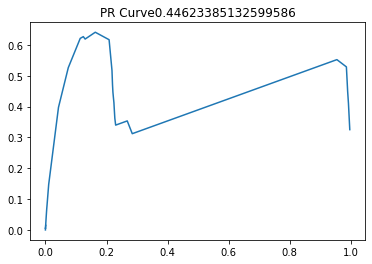

  0%|          | 1/400 [00:01<07:56,  1.19s/it]

Epoch loss :: 66.405334


  0%|          | 2/400 [00:02<08:02,  1.21s/it]

Epoch loss :: 66.58126


  1%|          | 3/400 [00:03<07:41,  1.16s/it]

Epoch loss :: 66.49334


  1%|          | 4/400 [00:04<07:27,  1.13s/it]

Epoch loss :: 66.518684


  1%|▏         | 5/400 [00:05<07:23,  1.12s/it]

Epoch loss :: 66.52194


  2%|▏         | 6/400 [00:06<07:31,  1.15s/it]

Epoch loss :: 66.49822


  2%|▏         | 7/400 [00:07<07:26,  1.14s/it]

Epoch loss :: 66.48959


  2%|▏         | 8/400 [00:09<07:27,  1.14s/it]

Epoch loss :: 66.45638


  2%|▏         | 9/400 [00:10<07:26,  1.14s/it]

Epoch loss :: 66.54587


  2%|▎         | 10/400 [00:11<07:33,  1.16s/it]

Epoch loss :: 66.52847


  3%|▎         | 11/400 [00:12<07:30,  1.16s/it]

Epoch loss :: 66.49305


  3%|▎         | 12/400 [00:13<07:15,  1.12s/it]

Epoch loss :: 66.51578


  3%|▎         | 13/400 [00:14<07:06,  1.10s/it]

Epoch loss :: 66.69851


  4%|▎         | 14/400 [00:15<07:05,  1.10s/it]

Epoch loss :: 66.5019


  4%|▍         | 15/400 [00:17<07:20,  1.14s/it]

Epoch loss :: 66.71488


  4%|▍         | 16/400 [00:18<07:00,  1.10s/it]

Epoch loss :: 66.452576


  4%|▍         | 17/400 [00:19<07:04,  1.11s/it]

Epoch loss :: 66.592316


  4%|▍         | 18/400 [00:20<07:25,  1.17s/it]

Epoch loss :: 66.533745


  5%|▍         | 19/400 [00:21<07:35,  1.19s/it]

Epoch loss :: 66.462456


  5%|▌         | 20/400 [00:23<07:48,  1.23s/it]

Epoch loss :: 66.48592


  5%|▌         | 21/400 [00:24<07:44,  1.23s/it]

Epoch loss :: 66.45706


  6%|▌         | 22/400 [00:25<07:30,  1.19s/it]

Epoch loss :: 66.52128


  6%|▌         | 23/400 [00:26<07:43,  1.23s/it]

Epoch loss :: 66.652916


  6%|▌         | 24/400 [00:28<08:01,  1.28s/it]

Epoch loss :: 66.682915


  6%|▋         | 25/400 [00:29<08:05,  1.29s/it]

Epoch loss :: 66.55272


  6%|▋         | 26/400 [00:30<07:34,  1.21s/it]

Epoch loss :: 66.52001


  7%|▋         | 27/400 [00:31<07:29,  1.21s/it]

Epoch loss :: 66.41787


  7%|▋         | 28/400 [00:33<07:55,  1.28s/it]

Epoch loss :: 66.426544


  7%|▋         | 29/400 [00:34<08:02,  1.30s/it]

Epoch loss :: 66.55456


  8%|▊         | 30/400 [00:35<07:44,  1.26s/it]

Epoch loss :: 66.45971


  8%|▊         | 31/400 [00:36<07:40,  1.25s/it]

Epoch loss :: 66.50741


  8%|▊         | 32/400 [00:38<08:02,  1.31s/it]

Epoch loss :: 66.58804


  8%|▊         | 33/400 [00:39<08:19,  1.36s/it]

Epoch loss :: 66.55559


  8%|▊         | 34/400 [00:41<08:22,  1.37s/it]

Epoch loss :: 66.609474


  9%|▉         | 35/400 [00:42<08:11,  1.35s/it]

Epoch loss :: 66.59274


  9%|▉         | 36/400 [00:43<07:53,  1.30s/it]

Epoch loss :: 66.44953


  9%|▉         | 37/400 [00:44<07:39,  1.26s/it]

Epoch loss :: 66.592064


 10%|▉         | 38/400 [00:45<07:02,  1.17s/it]

Epoch loss :: 66.55964


 10%|▉         | 39/400 [00:46<06:41,  1.11s/it]

Epoch loss :: 66.434875


 10%|█         | 40/400 [00:47<06:52,  1.15s/it]

Epoch loss :: 66.584206


 10%|█         | 41/400 [00:49<07:02,  1.18s/it]

Epoch loss :: 66.57446


 10%|█         | 42/400 [00:50<06:59,  1.17s/it]

Epoch loss :: 66.5056


 11%|█         | 43/400 [00:51<07:05,  1.19s/it]

Epoch loss :: 66.44619


 11%|█         | 44/400 [00:52<07:13,  1.22s/it]

Epoch loss :: 66.54485


 11%|█▏        | 45/400 [00:54<07:15,  1.23s/it]

Epoch loss :: 66.53317


 12%|█▏        | 46/400 [00:55<07:12,  1.22s/it]

Epoch loss :: 66.47068


 12%|█▏        | 47/400 [00:56<07:21,  1.25s/it]

Epoch loss :: 66.4087


 12%|█▏        | 48/400 [00:57<07:15,  1.24s/it]

Epoch loss :: 66.563034


 12%|█▏        | 49/400 [00:58<06:52,  1.17s/it]

Epoch loss :: 66.45183


 12%|█▎        | 50/400 [01:00<06:43,  1.15s/it]

Epoch loss :: 66.46424


 13%|█▎        | 51/400 [01:01<06:45,  1.16s/it]

Epoch loss :: 66.54388


 13%|█▎        | 52/400 [01:02<06:34,  1.13s/it]

Epoch loss :: 66.4639


 13%|█▎        | 53/400 [01:03<06:29,  1.12s/it]

Epoch loss :: 66.66763


 14%|█▎        | 54/400 [01:04<06:29,  1.13s/it]

Epoch loss :: 66.48212


 14%|█▍        | 55/400 [01:05<06:25,  1.12s/it]

Epoch loss :: 66.5397


 14%|█▍        | 56/400 [01:06<06:34,  1.15s/it]

Epoch loss :: 66.59626


 14%|█▍        | 57/400 [01:07<06:31,  1.14s/it]

Epoch loss :: 66.46504


 14%|█▍        | 58/400 [01:09<06:24,  1.12s/it]

Epoch loss :: 66.656944


 15%|█▍        | 59/400 [01:10<06:18,  1.11s/it]

Epoch loss :: 66.61594


 15%|█▌        | 60/400 [01:11<06:17,  1.11s/it]

Epoch loss :: 66.58988


 15%|█▌        | 61/400 [01:12<06:18,  1.12s/it]

Epoch loss :: 66.50234


 16%|█▌        | 62/400 [01:13<06:16,  1.11s/it]

Epoch loss :: 66.43481


 16%|█▌        | 63/400 [01:14<06:20,  1.13s/it]

Epoch loss :: 66.42724


 16%|█▌        | 64/400 [01:15<06:23,  1.14s/it]

Epoch loss :: 66.556335


 16%|█▋        | 65/400 [01:17<06:32,  1.17s/it]

Epoch loss :: 66.58925


 16%|█▋        | 66/400 [01:18<06:45,  1.21s/it]

Epoch loss :: 66.56543


 17%|█▋        | 67/400 [01:19<06:56,  1.25s/it]

Epoch loss :: 66.54769


 17%|█▋        | 68/400 [01:20<06:47,  1.23s/it]

Epoch loss :: 66.42575


 17%|█▋        | 69/400 [01:22<06:40,  1.21s/it]

Epoch loss :: 66.422775


 18%|█▊        | 70/400 [01:23<06:36,  1.20s/it]

Epoch loss :: 66.54699


 18%|█▊        | 71/400 [01:24<06:39,  1.21s/it]

Epoch loss :: 66.51708


 18%|█▊        | 72/400 [01:25<06:36,  1.21s/it]

Epoch loss :: 66.53051


 18%|█▊        | 73/400 [01:26<06:15,  1.15s/it]

Epoch loss :: 66.500374


 18%|█▊        | 74/400 [01:27<06:14,  1.15s/it]

Epoch loss :: 66.524315


 19%|█▉        | 75/400 [01:29<06:19,  1.17s/it]

Epoch loss :: 66.43279


 19%|█▉        | 76/400 [01:30<06:23,  1.18s/it]

Epoch loss :: 66.52006


 19%|█▉        | 77/400 [01:31<06:30,  1.21s/it]

Epoch loss :: 66.607704


 20%|█▉        | 78/400 [01:32<06:25,  1.20s/it]

Epoch loss :: 66.5442


 20%|█▉        | 79/400 [01:33<06:17,  1.17s/it]

Epoch loss :: 66.57444


 20%|██        | 80/400 [01:35<06:27,  1.21s/it]

Epoch loss :: 66.50949


 20%|██        | 81/400 [01:36<06:11,  1.16s/it]

Epoch loss :: 66.50605


 20%|██        | 82/400 [01:37<06:11,  1.17s/it]

Epoch loss :: 66.504


 21%|██        | 83/400 [01:38<06:06,  1.16s/it]

Epoch loss :: 66.51647


 21%|██        | 84/400 [01:39<06:04,  1.15s/it]

Epoch loss :: 66.4416


 21%|██▏       | 85/400 [01:40<06:02,  1.15s/it]

Epoch loss :: 66.47795


 22%|██▏       | 86/400 [01:41<06:09,  1.18s/it]

Epoch loss :: 66.48281


 22%|██▏       | 87/400 [01:42<05:45,  1.10s/it]

Epoch loss :: 66.56195


 22%|██▏       | 88/400 [01:44<05:58,  1.15s/it]

Epoch loss :: 66.48718


 22%|██▏       | 89/400 [01:45<06:16,  1.21s/it]

Epoch loss :: 66.48437


 22%|██▎       | 90/400 [01:46<06:39,  1.29s/it]

Epoch loss :: 66.495964


 23%|██▎       | 91/400 [01:48<06:50,  1.33s/it]

Epoch loss :: 66.47584


 23%|██▎       | 92/400 [01:49<07:01,  1.37s/it]

Epoch loss :: 66.5522


 23%|██▎       | 93/400 [01:51<06:57,  1.36s/it]

Epoch loss :: 66.48434


 24%|██▎       | 94/400 [01:52<07:04,  1.39s/it]

Epoch loss :: 66.566475


 24%|██▍       | 95/400 [01:53<06:27,  1.27s/it]

Epoch loss :: 66.48663


 24%|██▍       | 96/400 [01:54<06:30,  1.28s/it]

Epoch loss :: 66.472694


 24%|██▍       | 97/400 [01:56<06:18,  1.25s/it]

Epoch loss :: 66.561264


 24%|██▍       | 98/400 [01:57<06:24,  1.27s/it]

Epoch loss :: 66.50996


 25%|██▍       | 99/400 [01:58<06:23,  1.27s/it]

Epoch loss :: 66.427986


 25%|██▌       | 100/400 [01:59<05:52,  1.17s/it]

Epoch loss :: 66.55117


 25%|██▌       | 101/400 [02:01<06:06,  1.23s/it]

Epoch loss :: 66.52583


 26%|██▌       | 102/400 [02:02<06:05,  1.23s/it]

Epoch loss :: 66.50852


 26%|██▌       | 103/400 [02:03<06:14,  1.26s/it]

Epoch loss :: 66.55041


 26%|██▌       | 104/400 [02:04<05:54,  1.20s/it]

Epoch loss :: 66.578545


 26%|██▋       | 105/400 [02:05<05:56,  1.21s/it]

Epoch loss :: 66.51932


 26%|██▋       | 106/400 [02:07<05:56,  1.21s/it]

Epoch loss :: 66.626


 27%|██▋       | 107/400 [02:08<05:57,  1.22s/it]

Epoch loss :: 66.481895


 27%|██▋       | 108/400 [02:09<05:43,  1.17s/it]

Epoch loss :: 66.5478


 27%|██▋       | 109/400 [02:10<05:46,  1.19s/it]

Epoch loss :: 66.581604


 28%|██▊       | 110/400 [02:11<05:54,  1.22s/it]

Epoch loss :: 66.543655


 28%|██▊       | 111/400 [02:13<05:51,  1.21s/it]

Epoch loss :: 66.47492


 28%|██▊       | 112/400 [02:14<05:58,  1.24s/it]

Epoch loss :: 66.49788


 28%|██▊       | 113/400 [02:15<05:55,  1.24s/it]

Epoch loss :: 66.47193


 28%|██▊       | 114/400 [02:17<06:02,  1.27s/it]

Epoch loss :: 66.586586


 29%|██▉       | 115/400 [02:18<05:47,  1.22s/it]

Epoch loss :: 66.588524


 29%|██▉       | 116/400 [02:19<05:39,  1.20s/it]

Epoch loss :: 66.680244


 29%|██▉       | 117/400 [02:20<05:14,  1.11s/it]

Epoch loss :: 66.53587


 30%|██▉       | 118/400 [02:21<05:06,  1.09s/it]

Epoch loss :: 66.51603


 30%|██▉       | 119/400 [02:22<05:13,  1.11s/it]

Epoch loss :: 66.48569


 30%|███       | 120/400 [02:23<05:21,  1.15s/it]

Epoch loss :: 66.55065


 30%|███       | 121/400 [02:24<05:24,  1.16s/it]

Epoch loss :: 66.611916


 30%|███       | 122/400 [02:26<05:27,  1.18s/it]

Epoch loss :: 66.488304


 31%|███       | 123/400 [02:27<05:17,  1.15s/it]

Epoch loss :: 66.53396


 31%|███       | 124/400 [02:28<05:10,  1.13s/it]

Epoch loss :: 66.51945


 31%|███▏      | 125/400 [02:29<05:16,  1.15s/it]

Epoch loss :: 66.48135


 32%|███▏      | 126/400 [02:30<05:29,  1.20s/it]

Epoch loss :: 66.47297


 32%|███▏      | 127/400 [02:31<05:29,  1.21s/it]

Epoch loss :: 66.51205


 32%|███▏      | 128/400 [02:33<05:31,  1.22s/it]

Epoch loss :: 66.52569


 32%|███▏      | 129/400 [02:34<05:30,  1.22s/it]

Epoch loss :: 66.55247


 32%|███▎      | 130/400 [02:35<05:28,  1.22s/it]

Epoch loss :: 66.5944


 33%|███▎      | 131/400 [02:36<05:17,  1.18s/it]

Epoch loss :: 66.49936


 33%|███▎      | 132/400 [02:37<05:08,  1.15s/it]

Epoch loss :: 66.4934


 33%|███▎      | 133/400 [02:38<04:59,  1.12s/it]

Epoch loss :: 66.564095


 34%|███▎      | 134/400 [02:40<05:04,  1.14s/it]

Epoch loss :: 66.50152


 34%|███▍      | 135/400 [02:41<05:04,  1.15s/it]

Epoch loss :: 66.533104


 34%|███▍      | 136/400 [02:42<04:56,  1.12s/it]

Epoch loss :: 66.53397


 34%|███▍      | 137/400 [02:43<04:45,  1.09s/it]

Epoch loss :: 66.55227


 34%|███▍      | 138/400 [02:44<04:54,  1.13s/it]

Epoch loss :: 66.652794


 35%|███▍      | 139/400 [02:45<05:04,  1.16s/it]

Epoch loss :: 66.445915


 35%|███▌      | 140/400 [02:46<05:03,  1.17s/it]

Epoch loss :: 66.5478


 35%|███▌      | 141/400 [02:47<04:51,  1.13s/it]

Epoch loss :: 66.57406


 36%|███▌      | 142/400 [02:48<04:44,  1.10s/it]

Epoch loss :: 66.6767


 36%|███▌      | 143/400 [02:50<04:46,  1.12s/it]

Epoch loss :: 66.55243


 36%|███▌      | 144/400 [02:51<04:47,  1.12s/it]

Epoch loss :: 66.46144


 36%|███▋      | 145/400 [02:52<04:44,  1.11s/it]

Epoch loss :: 66.476006


 36%|███▋      | 146/400 [02:53<04:40,  1.10s/it]

Epoch loss :: 66.380196


 37%|███▋      | 147/400 [02:54<04:45,  1.13s/it]

Epoch loss :: 66.50791


 37%|███▋      | 148/400 [02:55<04:43,  1.12s/it]

Epoch loss :: 66.53418


 37%|███▋      | 149/400 [02:56<04:48,  1.15s/it]

Epoch loss :: 66.485085


 38%|███▊      | 150/400 [02:58<04:40,  1.12s/it]

Epoch loss :: 66.464836


 38%|███▊      | 151/400 [02:59<04:31,  1.09s/it]

Epoch loss :: 66.54999


 38%|███▊      | 152/400 [03:00<04:39,  1.13s/it]

Epoch loss :: 66.5897


 38%|███▊      | 153/400 [03:01<04:38,  1.13s/it]

Epoch loss :: 66.53772


 38%|███▊      | 154/400 [03:02<04:35,  1.12s/it]

Epoch loss :: 66.57122


 39%|███▉      | 155/400 [03:03<04:30,  1.11s/it]

Epoch loss :: 66.620674


 39%|███▉      | 156/400 [03:04<04:19,  1.06s/it]

Epoch loss :: 66.46213


 39%|███▉      | 157/400 [03:05<04:16,  1.05s/it]

Epoch loss :: 66.42086


 40%|███▉      | 158/400 [03:06<04:30,  1.12s/it]

Epoch loss :: 66.49837


 40%|███▉      | 159/400 [03:08<04:35,  1.14s/it]

Epoch loss :: 66.65557


 40%|████      | 160/400 [03:09<04:40,  1.17s/it]

Epoch loss :: 66.47775


 40%|████      | 161/400 [03:10<04:35,  1.15s/it]

Epoch loss :: 66.53596


 40%|████      | 162/400 [03:11<04:33,  1.15s/it]

Epoch loss :: 66.53768


 41%|████      | 163/400 [03:12<04:29,  1.14s/it]

Epoch loss :: 66.51706


 41%|████      | 164/400 [03:13<04:27,  1.13s/it]

Epoch loss :: 66.498924


 41%|████▏     | 165/400 [03:15<04:38,  1.19s/it]

Epoch loss :: 66.38108


 42%|████▏     | 166/400 [03:16<04:36,  1.18s/it]

Epoch loss :: 66.490685


 42%|████▏     | 167/400 [03:17<04:33,  1.17s/it]

Epoch loss :: 66.519646


 42%|████▏     | 168/400 [03:18<04:38,  1.20s/it]

Epoch loss :: 66.546844


 42%|████▏     | 169/400 [03:19<04:34,  1.19s/it]

Epoch loss :: 66.54287


 42%|████▎     | 170/400 [03:21<04:39,  1.21s/it]

Epoch loss :: 66.51458


 43%|████▎     | 171/400 [03:22<04:37,  1.21s/it]

Epoch loss :: 66.562004


 43%|████▎     | 172/400 [03:23<04:24,  1.16s/it]

Epoch loss :: 66.477264


 43%|████▎     | 173/400 [03:24<04:14,  1.12s/it]

Epoch loss :: 66.440895


 44%|████▎     | 174/400 [03:25<04:22,  1.16s/it]

Epoch loss :: 66.52798


 44%|████▍     | 175/400 [03:26<04:19,  1.16s/it]

Epoch loss :: 66.45811


 44%|████▍     | 176/400 [03:27<04:07,  1.11s/it]

Epoch loss :: 66.55181


 44%|████▍     | 177/400 [03:28<03:59,  1.07s/it]

Epoch loss :: 66.50892


 44%|████▍     | 178/400 [03:30<04:16,  1.15s/it]

Epoch loss :: 66.39904


 45%|████▍     | 179/400 [03:31<04:18,  1.17s/it]

Epoch loss :: 66.52799


 45%|████▌     | 180/400 [03:32<04:40,  1.28s/it]

Epoch loss :: 66.51708


 45%|████▌     | 181/400 [03:34<04:52,  1.34s/it]

Epoch loss :: 66.45239


 46%|████▌     | 182/400 [03:35<05:00,  1.38s/it]

Epoch loss :: 66.50916


 46%|████▌     | 183/400 [03:37<04:53,  1.35s/it]

Epoch loss :: 66.49564


 46%|████▌     | 184/400 [03:38<04:38,  1.29s/it]

Epoch loss :: 66.54074


 46%|████▋     | 185/400 [03:39<04:24,  1.23s/it]

Epoch loss :: 66.53202


 46%|████▋     | 186/400 [03:40<04:09,  1.17s/it]

Epoch loss :: 66.5743


 47%|████▋     | 187/400 [03:41<04:06,  1.16s/it]

Epoch loss :: 66.50757


 47%|████▋     | 188/400 [03:42<04:05,  1.16s/it]

Epoch loss :: 66.47054


 47%|████▋     | 189/400 [03:43<04:02,  1.15s/it]

Epoch loss :: 66.663216


 48%|████▊     | 190/400 [03:44<03:52,  1.11s/it]

Epoch loss :: 66.51838


 48%|████▊     | 191/400 [03:45<03:55,  1.13s/it]

Epoch loss :: 66.40501


 48%|████▊     | 192/400 [03:47<04:04,  1.17s/it]

Epoch loss :: 66.55305


 48%|████▊     | 193/400 [03:48<04:09,  1.20s/it]

Epoch loss :: 66.48222


 48%|████▊     | 194/400 [03:49<04:10,  1.21s/it]

Epoch loss :: 66.71121


 49%|████▉     | 195/400 [03:50<04:07,  1.21s/it]

Epoch loss :: 66.41042


 49%|████▉     | 196/400 [03:52<04:11,  1.23s/it]

Epoch loss :: 66.47927


 49%|████▉     | 197/400 [03:53<04:16,  1.26s/it]

Epoch loss :: 66.52372


 50%|████▉     | 198/400 [03:54<04:12,  1.25s/it]

Epoch loss :: 66.60616


 50%|████▉     | 199/400 [03:55<04:07,  1.23s/it]

Epoch loss :: 66.5051


 50%|█████     | 200/400 [03:57<03:59,  1.20s/it]

Epoch loss :: 66.58164


 50%|█████     | 201/400 [03:58<03:47,  1.14s/it]

Epoch loss :: 66.56784


 50%|█████     | 202/400 [03:59<03:51,  1.17s/it]

Epoch loss :: 66.59969


 51%|█████     | 203/400 [04:00<03:53,  1.18s/it]

Epoch loss :: 66.471535


 51%|█████     | 204/400 [04:01<03:51,  1.18s/it]

Epoch loss :: 66.56667


 51%|█████▏    | 205/400 [04:02<03:54,  1.20s/it]

Epoch loss :: 66.65022


 52%|█████▏    | 206/400 [04:04<03:51,  1.20s/it]

Epoch loss :: 66.49412


 52%|█████▏    | 207/400 [04:05<03:45,  1.17s/it]

Epoch loss :: 66.681404


 52%|█████▏    | 208/400 [04:06<03:53,  1.22s/it]

Epoch loss :: 66.58781


 52%|█████▏    | 209/400 [04:07<03:46,  1.18s/it]

Epoch loss :: 66.49311


 52%|█████▎    | 210/400 [04:08<03:49,  1.21s/it]

Epoch loss :: 66.46057


 53%|█████▎    | 211/400 [04:09<03:39,  1.16s/it]

Epoch loss :: 66.45727


 53%|█████▎    | 212/400 [04:11<03:44,  1.19s/it]

Epoch loss :: 66.544334


 53%|█████▎    | 213/400 [04:12<03:49,  1.22s/it]

Epoch loss :: 66.670715


 54%|█████▎    | 214/400 [04:13<03:57,  1.27s/it]

Epoch loss :: 66.43726


 54%|█████▍    | 215/400 [04:15<03:51,  1.25s/it]

Epoch loss :: 66.45349


 54%|█████▍    | 216/400 [04:16<03:38,  1.19s/it]

Epoch loss :: 66.45283


 54%|█████▍    | 217/400 [04:17<03:53,  1.28s/it]

Epoch loss :: 66.5224


 55%|█████▍    | 218/400 [04:19<04:03,  1.34s/it]

Epoch loss :: 66.46473


 55%|█████▍    | 219/400 [04:20<04:08,  1.37s/it]

Epoch loss :: 66.49952


 55%|█████▌    | 220/400 [04:21<04:02,  1.35s/it]

Epoch loss :: 66.45459


 55%|█████▌    | 221/400 [04:23<03:57,  1.33s/it]

Epoch loss :: 66.59753


 56%|█████▌    | 222/400 [04:24<03:54,  1.32s/it]

Epoch loss :: 66.41706


 56%|█████▌    | 223/400 [04:25<04:02,  1.37s/it]

Epoch loss :: 66.496376


 56%|█████▌    | 224/400 [04:27<04:01,  1.37s/it]

Epoch loss :: 66.51545


 56%|█████▋    | 225/400 [04:28<03:58,  1.36s/it]

Epoch loss :: 66.51432


 56%|█████▋    | 226/400 [04:29<03:36,  1.24s/it]

Epoch loss :: 66.47219


 57%|█████▋    | 227/400 [04:31<03:47,  1.32s/it]

Epoch loss :: 66.54895


 57%|█████▋    | 228/400 [04:32<03:48,  1.33s/it]

Epoch loss :: 66.48225


 57%|█████▋    | 229/400 [04:33<03:51,  1.36s/it]

Epoch loss :: 66.62622


 57%|█████▊    | 230/400 [04:35<03:55,  1.39s/it]

Epoch loss :: 66.44057


 58%|█████▊    | 231/400 [04:36<03:42,  1.31s/it]

Epoch loss :: 66.39904


 58%|█████▊    | 232/400 [04:37<03:39,  1.31s/it]

Epoch loss :: 66.4726


 58%|█████▊    | 233/400 [04:39<03:36,  1.30s/it]

Epoch loss :: 66.53593


 58%|█████▊    | 234/400 [04:40<03:36,  1.30s/it]

Epoch loss :: 66.46578


 59%|█████▉    | 235/400 [04:41<03:25,  1.24s/it]

Epoch loss :: 66.50066


 59%|█████▉    | 236/400 [04:42<03:31,  1.29s/it]

Epoch loss :: 66.44451


 59%|█████▉    | 237/400 [04:44<03:29,  1.29s/it]

Epoch loss :: 66.59829


 60%|█████▉    | 238/400 [04:45<03:24,  1.26s/it]

Epoch loss :: 66.60883


 60%|█████▉    | 239/400 [04:46<03:32,  1.32s/it]

Epoch loss :: 66.530334


 60%|██████    | 240/400 [04:48<03:26,  1.29s/it]

Epoch loss :: 66.53113


 60%|██████    | 241/400 [04:49<03:26,  1.30s/it]

Epoch loss :: 66.53939


 60%|██████    | 242/400 [04:50<03:26,  1.30s/it]

Epoch loss :: 66.43993


 61%|██████    | 243/400 [04:51<03:26,  1.31s/it]

Epoch loss :: 66.53778


 61%|██████    | 244/400 [04:53<03:19,  1.28s/it]

Epoch loss :: 66.44274


 61%|██████▏   | 245/400 [04:54<03:15,  1.26s/it]

Epoch loss :: 66.5651


 62%|██████▏   | 246/400 [04:55<03:09,  1.23s/it]

Epoch loss :: 66.46399


 62%|██████▏   | 247/400 [04:56<03:02,  1.19s/it]

Epoch loss :: 66.588905


 62%|██████▏   | 248/400 [04:57<03:03,  1.21s/it]

Epoch loss :: 66.53971


 62%|██████▏   | 249/400 [04:59<03:06,  1.23s/it]

Epoch loss :: 66.57117


 62%|██████▎   | 250/400 [05:00<03:09,  1.26s/it]

Epoch loss :: 66.480965


 63%|██████▎   | 251/400 [05:01<03:01,  1.22s/it]

Epoch loss :: 66.4753


 63%|██████▎   | 252/400 [05:02<03:03,  1.24s/it]

Epoch loss :: 66.687195


 63%|██████▎   | 253/400 [05:04<03:02,  1.24s/it]

Epoch loss :: 66.41239


 64%|██████▎   | 254/400 [05:05<03:00,  1.24s/it]

Epoch loss :: 66.52285


 64%|██████▍   | 255/400 [05:06<02:55,  1.21s/it]

Epoch loss :: 66.57891


 64%|██████▍   | 256/400 [05:07<02:58,  1.24s/it]

Epoch loss :: 66.59576


 64%|██████▍   | 257/400 [05:08<02:50,  1.19s/it]

Epoch loss :: 66.45968


 64%|██████▍   | 258/400 [05:10<02:50,  1.20s/it]

Epoch loss :: 66.46053


 65%|██████▍   | 259/400 [05:11<02:50,  1.21s/it]

Epoch loss :: 66.46012


 65%|██████▌   | 260/400 [05:12<02:51,  1.23s/it]

Epoch loss :: 66.48301


 65%|██████▌   | 261/400 [05:13<02:51,  1.23s/it]

Epoch loss :: 66.56741


 66%|██████▌   | 262/400 [05:15<02:45,  1.20s/it]

Epoch loss :: 66.46041


 66%|██████▌   | 263/400 [05:16<02:38,  1.15s/it]

Epoch loss :: 66.58173


 66%|██████▌   | 264/400 [05:17<02:33,  1.13s/it]

Epoch loss :: 66.61622


 66%|██████▋   | 265/400 [05:18<02:34,  1.14s/it]

Epoch loss :: 66.501564


 66%|██████▋   | 266/400 [05:19<02:37,  1.18s/it]

Epoch loss :: 66.418144


 67%|██████▋   | 267/400 [05:20<02:40,  1.21s/it]

Epoch loss :: 66.60351


 67%|██████▋   | 268/400 [05:21<02:32,  1.15s/it]

Epoch loss :: 66.53299


 67%|██████▋   | 269/400 [05:22<02:27,  1.12s/it]

Epoch loss :: 66.47991


 68%|██████▊   | 270/400 [05:24<02:25,  1.12s/it]

Epoch loss :: 66.59815


 68%|██████▊   | 271/400 [05:25<02:30,  1.17s/it]

Epoch loss :: 66.57309


 68%|██████▊   | 272/400 [05:26<02:35,  1.21s/it]

Epoch loss :: 66.5389


 68%|██████▊   | 273/400 [05:27<02:33,  1.21s/it]

Epoch loss :: 66.528015


 68%|██████▊   | 274/400 [05:28<02:29,  1.19s/it]

Epoch loss :: 66.464516


 69%|██████▉   | 275/400 [05:30<02:32,  1.22s/it]

Epoch loss :: 66.53776


 69%|██████▉   | 276/400 [05:31<02:29,  1.20s/it]

Epoch loss :: 66.53739


 69%|██████▉   | 277/400 [05:32<02:27,  1.20s/it]

Epoch loss :: 66.49381


 70%|██████▉   | 278/400 [05:33<02:24,  1.19s/it]

Epoch loss :: 66.471886


 70%|██████▉   | 279/400 [05:34<02:20,  1.16s/it]

Epoch loss :: 66.55081


 70%|███████   | 280/400 [05:35<02:16,  1.14s/it]

Epoch loss :: 66.46476


 70%|███████   | 281/400 [05:37<02:12,  1.12s/it]

Epoch loss :: 66.55868


 70%|███████   | 282/400 [05:38<02:17,  1.17s/it]

Epoch loss :: 66.49233


 71%|███████   | 283/400 [05:39<02:17,  1.17s/it]

Epoch loss :: 66.498566


 71%|███████   | 284/400 [05:40<02:14,  1.16s/it]

Epoch loss :: 66.53925


 71%|███████▏  | 285/400 [05:41<02:07,  1.11s/it]

Epoch loss :: 66.43389


 72%|███████▏  | 286/400 [05:42<02:07,  1.12s/it]

Epoch loss :: 66.57171


 72%|███████▏  | 287/400 [05:43<02:08,  1.14s/it]

Epoch loss :: 66.56905


 72%|███████▏  | 288/400 [05:45<02:07,  1.13s/it]

Epoch loss :: 66.49255


 72%|███████▏  | 289/400 [05:46<02:05,  1.13s/it]

Epoch loss :: 66.543526


 72%|███████▎  | 290/400 [05:47<02:07,  1.16s/it]

Epoch loss :: 66.50174


 73%|███████▎  | 291/400 [05:48<02:05,  1.16s/it]

Epoch loss :: 66.5678


 73%|███████▎  | 292/400 [05:49<02:10,  1.20s/it]

Epoch loss :: 66.47973


 73%|███████▎  | 293/400 [05:51<02:10,  1.22s/it]

Epoch loss :: 66.54652


 74%|███████▎  | 294/400 [05:52<02:09,  1.23s/it]

Epoch loss :: 66.52445


 74%|███████▍  | 295/400 [05:53<02:08,  1.22s/it]

Epoch loss :: 66.50186


 74%|███████▍  | 296/400 [05:54<02:07,  1.22s/it]

Epoch loss :: 66.63122


 74%|███████▍  | 297/400 [05:56<02:05,  1.22s/it]

Epoch loss :: 66.471306


 74%|███████▍  | 298/400 [05:57<02:02,  1.20s/it]

Epoch loss :: 66.56597


 75%|███████▍  | 299/400 [05:58<02:01,  1.21s/it]

Epoch loss :: 66.444466


 75%|███████▌  | 300/400 [05:59<01:57,  1.18s/it]

Epoch loss :: 66.52188


 75%|███████▌  | 301/400 [06:00<01:57,  1.19s/it]

Epoch loss :: 66.57161


 76%|███████▌  | 302/400 [06:01<01:55,  1.18s/it]

Epoch loss :: 66.590675


 76%|███████▌  | 303/400 [06:03<01:53,  1.17s/it]

Epoch loss :: 66.43371


 76%|███████▌  | 304/400 [06:04<01:52,  1.17s/it]

Epoch loss :: 66.44576


 76%|███████▋  | 305/400 [06:05<01:55,  1.21s/it]

Epoch loss :: 66.51807


 76%|███████▋  | 306/400 [06:06<01:53,  1.20s/it]

Epoch loss :: 66.559944


 77%|███████▋  | 307/400 [06:07<01:52,  1.21s/it]

Epoch loss :: 66.58395


 77%|███████▋  | 308/400 [06:09<01:50,  1.20s/it]

Epoch loss :: 66.53709


 77%|███████▋  | 309/400 [06:10<01:45,  1.15s/it]

Epoch loss :: 66.54035


 78%|███████▊  | 310/400 [06:11<01:43,  1.14s/it]

Epoch loss :: 66.52428


 78%|███████▊  | 311/400 [06:12<01:42,  1.16s/it]

Epoch loss :: 66.52481


 78%|███████▊  | 312/400 [06:13<01:40,  1.14s/it]

Epoch loss :: 66.56188


 78%|███████▊  | 313/400 [06:14<01:34,  1.09s/it]

Epoch loss :: 66.605705


 78%|███████▊  | 314/400 [06:15<01:34,  1.10s/it]

Epoch loss :: 66.52677


 79%|███████▉  | 315/400 [06:16<01:33,  1.10s/it]

Epoch loss :: 66.465164


 79%|███████▉  | 316/400 [06:18<01:37,  1.16s/it]

Epoch loss :: 66.66212


 79%|███████▉  | 317/400 [06:19<01:38,  1.19s/it]

Epoch loss :: 66.3899


 80%|███████▉  | 318/400 [06:20<01:38,  1.21s/it]

Epoch loss :: 66.48243


 80%|███████▉  | 319/400 [06:21<01:39,  1.23s/it]

Epoch loss :: 66.423096


 80%|████████  | 320/400 [06:23<01:40,  1.25s/it]

Epoch loss :: 66.45364


 80%|████████  | 321/400 [06:24<01:39,  1.26s/it]

Epoch loss :: 66.53135


 80%|████████  | 322/400 [06:25<01:37,  1.25s/it]

Epoch loss :: 66.58378


 81%|████████  | 323/400 [06:26<01:37,  1.26s/it]

Epoch loss :: 66.55579


 81%|████████  | 324/400 [06:28<01:35,  1.26s/it]

Epoch loss :: 66.545715


 81%|████████▏ | 325/400 [06:29<01:32,  1.23s/it]

Epoch loss :: 66.48731


 82%|████████▏ | 326/400 [06:30<01:31,  1.24s/it]

Epoch loss :: 66.60025


 82%|████████▏ | 327/400 [06:31<01:29,  1.22s/it]

Epoch loss :: 66.55765


 82%|████████▏ | 328/400 [06:33<01:31,  1.26s/it]

Epoch loss :: 66.48661


 82%|████████▏ | 329/400 [06:34<01:30,  1.27s/it]

Epoch loss :: 66.66312


 82%|████████▎ | 330/400 [06:35<01:29,  1.27s/it]

Epoch loss :: 66.50664


 83%|████████▎ | 331/400 [06:36<01:26,  1.25s/it]

Epoch loss :: 66.613


 83%|████████▎ | 332/400 [06:38<01:23,  1.22s/it]

Epoch loss :: 66.46545


 83%|████████▎ | 333/400 [06:39<01:22,  1.23s/it]

Epoch loss :: 66.534294


 84%|████████▎ | 334/400 [06:40<01:23,  1.27s/it]

Epoch loss :: 66.57666


 84%|████████▍ | 335/400 [06:41<01:22,  1.27s/it]

Epoch loss :: 66.44417


 84%|████████▍ | 336/400 [06:43<01:21,  1.28s/it]

Epoch loss :: 66.53393


 84%|████████▍ | 337/400 [06:44<01:18,  1.25s/it]

Epoch loss :: 66.49168


 84%|████████▍ | 338/400 [06:45<01:18,  1.27s/it]

Epoch loss :: 66.619675


 85%|████████▍ | 339/400 [06:47<01:18,  1.29s/it]

Epoch loss :: 66.46147


 85%|████████▌ | 340/400 [06:48<01:16,  1.27s/it]

Epoch loss :: 66.43872


 85%|████████▌ | 341/400 [06:49<01:12,  1.23s/it]

Epoch loss :: 66.50147


 86%|████████▌ | 342/400 [06:50<01:11,  1.23s/it]

Epoch loss :: 66.528625


 86%|████████▌ | 343/400 [06:51<01:11,  1.25s/it]

Epoch loss :: 66.46006


 86%|████████▌ | 344/400 [06:53<01:07,  1.21s/it]

Epoch loss :: 66.60636


 86%|████████▋ | 345/400 [06:54<01:04,  1.16s/it]

Epoch loss :: 66.468925


 86%|████████▋ | 346/400 [06:55<01:02,  1.16s/it]

Epoch loss :: 66.54593


 87%|████████▋ | 347/400 [06:56<01:01,  1.17s/it]

Epoch loss :: 66.46717


 87%|████████▋ | 348/400 [06:57<01:02,  1.21s/it]

Epoch loss :: 66.510826


 87%|████████▋ | 349/400 [06:58<01:00,  1.19s/it]

Epoch loss :: 66.52707


 88%|████████▊ | 350/400 [06:59<00:55,  1.11s/it]

Epoch loss :: 66.54986


 88%|████████▊ | 351/400 [07:01<00:55,  1.13s/it]

Epoch loss :: 66.4872


 88%|████████▊ | 352/400 [07:02<00:54,  1.13s/it]

Epoch loss :: 66.4506


 88%|████████▊ | 353/400 [07:03<00:52,  1.11s/it]

Epoch loss :: 66.47989


 88%|████████▊ | 354/400 [07:04<00:49,  1.07s/it]

Epoch loss :: 66.488884


 89%|████████▉ | 355/400 [07:05<00:50,  1.13s/it]

Epoch loss :: 66.50956


 89%|████████▉ | 356/400 [07:06<00:49,  1.12s/it]

Epoch loss :: 66.40557


 89%|████████▉ | 357/400 [07:07<00:46,  1.09s/it]

Epoch loss :: 66.51354


 90%|████████▉ | 358/400 [07:08<00:42,  1.02s/it]

Epoch loss :: 66.63594


 90%|████████▉ | 359/400 [07:09<00:45,  1.12s/it]

Epoch loss :: 66.529686


 90%|█████████ | 360/400 [07:11<00:47,  1.18s/it]

Epoch loss :: 66.5205


 90%|█████████ | 361/400 [07:12<00:47,  1.21s/it]

Epoch loss :: 66.49701


 90%|█████████ | 362/400 [07:13<00:47,  1.24s/it]

Epoch loss :: 66.53866


 91%|█████████ | 363/400 [07:15<00:46,  1.26s/it]

Epoch loss :: 66.61578


 91%|█████████ | 364/400 [07:16<00:46,  1.29s/it]

Epoch loss :: 66.42359


 91%|█████████▏| 365/400 [07:17<00:41,  1.19s/it]

Epoch loss :: 66.58787


 92%|█████████▏| 366/400 [07:18<00:40,  1.21s/it]

Epoch loss :: 66.54201


 92%|█████████▏| 367/400 [07:19<00:39,  1.20s/it]

Epoch loss :: 66.556114


 92%|█████████▏| 368/400 [07:21<00:39,  1.22s/it]

Epoch loss :: 66.56712


 92%|█████████▏| 369/400 [07:22<00:37,  1.22s/it]

Epoch loss :: 66.69514


 92%|█████████▎| 370/400 [07:23<00:36,  1.21s/it]

Epoch loss :: 66.496826


 93%|█████████▎| 371/400 [07:24<00:35,  1.21s/it]

Epoch loss :: 66.6392


 93%|█████████▎| 372/400 [07:25<00:31,  1.14s/it]

Epoch loss :: 66.50913


 93%|█████████▎| 373/400 [07:26<00:31,  1.15s/it]

Epoch loss :: 66.52947


 94%|█████████▎| 374/400 [07:27<00:29,  1.13s/it]

Epoch loss :: 66.60369


 94%|█████████▍| 375/400 [07:29<00:28,  1.14s/it]

Epoch loss :: 66.49006


 94%|█████████▍| 376/400 [07:30<00:28,  1.18s/it]

Epoch loss :: 66.51771


 94%|█████████▍| 377/400 [07:31<00:27,  1.20s/it]

Epoch loss :: 66.478195


 94%|█████████▍| 378/400 [07:32<00:25,  1.17s/it]

Epoch loss :: 66.54265


 95%|█████████▍| 379/400 [07:33<00:24,  1.15s/it]

Epoch loss :: 66.50556


 95%|█████████▌| 380/400 [07:34<00:23,  1.16s/it]

Epoch loss :: 66.53872


 95%|█████████▌| 381/400 [07:36<00:21,  1.13s/it]

Epoch loss :: 66.53765


 96%|█████████▌| 382/400 [07:37<00:20,  1.12s/it]

Epoch loss :: 66.51678


 96%|█████████▌| 383/400 [07:38<00:18,  1.12s/it]

Epoch loss :: 66.54043


 96%|█████████▌| 384/400 [07:39<00:17,  1.10s/it]

Epoch loss :: 66.518875


 96%|█████████▋| 385/400 [07:40<00:15,  1.04s/it]

Epoch loss :: 66.59747


 96%|█████████▋| 386/400 [07:41<00:14,  1.04s/it]

Epoch loss :: 66.49568


 97%|█████████▋| 387/400 [07:42<00:14,  1.10s/it]

Epoch loss :: 66.50498


 97%|█████████▋| 388/400 [07:43<00:13,  1.10s/it]

Epoch loss :: 66.57133


 97%|█████████▋| 389/400 [07:44<00:12,  1.11s/it]

Epoch loss :: 66.47208


 98%|█████████▊| 390/400 [07:45<00:10,  1.09s/it]

Epoch loss :: 66.48762


 98%|█████████▊| 391/400 [07:46<00:09,  1.10s/it]

Epoch loss :: 66.40317


 98%|█████████▊| 392/400 [07:48<00:08,  1.11s/it]

Epoch loss :: 66.50172


 98%|█████████▊| 393/400 [07:49<00:08,  1.15s/it]

Epoch loss :: 66.65857


 98%|█████████▊| 394/400 [07:50<00:06,  1.10s/it]

Epoch loss :: 66.43937


 99%|█████████▉| 395/400 [07:51<00:05,  1.10s/it]

Epoch loss :: 66.49878


 99%|█████████▉| 396/400 [07:52<00:04,  1.13s/it]

Epoch loss :: 66.38356


 99%|█████████▉| 397/400 [07:53<00:03,  1.18s/it]

Epoch loss :: 66.51539


100%|█████████▉| 398/400 [07:55<00:02,  1.20s/it]

Epoch loss :: 66.53196


100%|█████████▉| 399/400 [07:56<00:01,  1.22s/it]

Epoch loss :: 66.442986


100%|██████████| 400/400 [07:57<00:00,  1.19s/it]

Epoch loss :: 66.497696
======================TEST MODE======================


N: 68094
phi : tensor([0.3425, 0.6575], device='cuda:0', grad_fn=<DivBackward0>)
mu :  tensor([[-0.1608,  1.0940, -0.0088],
        [-0.1609,  1.0941, -0.0091]], device='cuda:0', grad_fn=<DivBackward0>)
covariance : tensor([[[ 0.0003, -0.0002,  0.0003],
         [-0.0002,  0.0005, -0.0006],
         [ 0.0003, -0.0006,  0.0012]],

        [[ 0.0003, -0.0002,  0.0003],
         [-0.0002,  0.0005, -0.0006],
         [ 0.0003, -0.0006,  0.0012]]], device='cuda:0',
       grad_fn=<DivBackward0>)
Size of test  48639
test_energy (48639,)
Precision 0.7147203947368421  Recall 0.7147791759190723  F1 >> 0.7147492841197635
AUC : 0.4522 


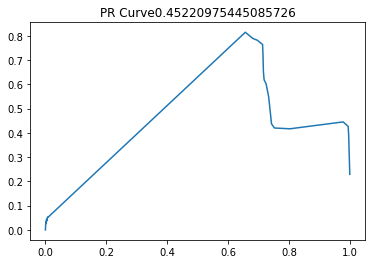

  0%|          | 1/400 [00:01<08:08,  1.23s/it]

Epoch loss :: 197.22632


  0%|          | 2/400 [00:02<08:16,  1.25s/it]

Epoch loss :: 197.03656


  1%|          | 3/400 [00:03<08:19,  1.26s/it]

Epoch loss :: 196.91469


  1%|          | 4/400 [00:05<08:14,  1.25s/it]

Epoch loss :: 196.7253


  1%|▏         | 5/400 [00:06<08:10,  1.24s/it]

Epoch loss :: 197.2282


  2%|▏         | 6/400 [00:07<08:07,  1.24s/it]

Epoch loss :: 196.7961


  2%|▏         | 7/400 [00:08<08:14,  1.26s/it]

Epoch loss :: 196.89258


  2%|▏         | 8/400 [00:10<08:18,  1.27s/it]

Epoch loss :: 197.08855


  2%|▏         | 9/400 [00:11<08:13,  1.26s/it]

Epoch loss :: 197.35869


  2%|▎         | 10/400 [00:12<08:08,  1.25s/it]

Epoch loss :: 197.32051


  3%|▎         | 11/400 [00:13<08:01,  1.24s/it]

Epoch loss :: 196.83531


  3%|▎         | 12/400 [00:14<07:56,  1.23s/it]

Epoch loss :: 197.05663


  3%|▎         | 13/400 [00:16<07:44,  1.20s/it]

Epoch loss :: 197.34985


  4%|▎         | 14/400 [00:17<07:29,  1.16s/it]

Epoch loss :: 196.8517


  4%|▍         | 15/400 [00:18<07:28,  1.17s/it]

Epoch loss :: 197.12895


  4%|▍         | 16/400 [00:19<07:32,  1.18s/it]

Epoch loss :: 196.95332


  4%|▍         | 17/400 [00:20<07:38,  1.20s/it]

Epoch loss :: 197.42853


  4%|▍         | 18/400 [00:22<07:45,  1.22s/it]

Epoch loss :: 197.29297


  5%|▍         | 19/400 [00:23<07:50,  1.23s/it]

Epoch loss :: 196.9279


  5%|▌         | 20/400 [00:24<07:50,  1.24s/it]

Epoch loss :: 197.01485


  5%|▌         | 21/400 [00:25<08:02,  1.27s/it]

Epoch loss :: 196.6494


  6%|▌         | 22/400 [00:27<07:50,  1.24s/it]

Epoch loss :: 197.15092


  6%|▌         | 23/400 [00:28<07:27,  1.19s/it]

Epoch loss :: 197.14494


  6%|▌         | 24/400 [00:29<07:44,  1.24s/it]

Epoch loss :: 196.81163


  6%|▋         | 25/400 [00:30<07:53,  1.26s/it]

Epoch loss :: 196.99158


  6%|▋         | 26/400 [00:32<07:50,  1.26s/it]

Epoch loss :: 197.30336


  7%|▋         | 27/400 [00:33<07:44,  1.24s/it]

Epoch loss :: 197.14476


  7%|▋         | 28/400 [00:34<07:46,  1.25s/it]

Epoch loss :: 197.19835


  7%|▋         | 29/400 [00:35<07:38,  1.24s/it]

Epoch loss :: 196.89735


  8%|▊         | 30/400 [00:37<07:46,  1.26s/it]

Epoch loss :: 196.93079


  8%|▊         | 31/400 [00:38<07:36,  1.24s/it]

Epoch loss :: 196.99916


  8%|▊         | 32/400 [00:39<07:47,  1.27s/it]

Epoch loss :: 197.481


  8%|▊         | 33/400 [00:40<07:36,  1.24s/it]

Epoch loss :: 197.03337


  8%|▊         | 34/400 [00:42<07:44,  1.27s/it]

Epoch loss :: 197.25511


  9%|▉         | 35/400 [00:43<07:24,  1.22s/it]

Epoch loss :: 197.18962


  9%|▉         | 36/400 [00:44<07:31,  1.24s/it]

Epoch loss :: 197.04143


  9%|▉         | 37/400 [00:45<07:21,  1.22s/it]

Epoch loss :: 196.83391


 10%|▉         | 38/400 [00:46<06:40,  1.11s/it]

Epoch loss :: 197.11829


 10%|▉         | 39/400 [00:47<07:04,  1.18s/it]

Epoch loss :: 197.0426


 10%|█         | 40/400 [00:49<07:12,  1.20s/it]

Epoch loss :: 196.94615


 10%|█         | 41/400 [00:50<07:34,  1.27s/it]

Epoch loss :: 197.10895


 10%|█         | 42/400 [00:51<07:41,  1.29s/it]

Epoch loss :: 196.86946


 11%|█         | 43/400 [00:52<06:57,  1.17s/it]

Epoch loss :: 197.12361


 11%|█         | 44/400 [00:54<07:16,  1.23s/it]

Epoch loss :: 197.29254


 11%|█▏        | 45/400 [00:55<07:17,  1.23s/it]

Epoch loss :: 197.03111


 12%|█▏        | 46/400 [00:56<07:29,  1.27s/it]

Epoch loss :: 197.20302


 12%|█▏        | 47/400 [00:57<07:23,  1.26s/it]

Epoch loss :: 197.51756


 12%|█▏        | 48/400 [00:59<07:20,  1.25s/it]

Epoch loss :: 196.95013


 12%|█▏        | 49/400 [01:00<07:23,  1.26s/it]

Epoch loss :: 197.04909


 12%|█▎        | 50/400 [01:01<07:23,  1.27s/it]

Epoch loss :: 196.90215


 13%|█▎        | 51/400 [01:02<07:16,  1.25s/it]

Epoch loss :: 197.3147


 13%|█▎        | 52/400 [01:04<07:06,  1.23s/it]

Epoch loss :: 196.8134


 13%|█▎        | 53/400 [01:05<06:52,  1.19s/it]

Epoch loss :: 196.99599


 14%|█▎        | 54/400 [01:06<06:40,  1.16s/it]

Epoch loss :: 197.32751


 14%|█▍        | 55/400 [01:07<06:48,  1.18s/it]

Epoch loss :: 197.32344


 14%|█▍        | 56/400 [01:08<06:33,  1.14s/it]

Epoch loss :: 197.47546


 14%|█▍        | 57/400 [01:09<06:21,  1.11s/it]

Epoch loss :: 197.20695


 14%|█▍        | 58/400 [01:10<06:24,  1.13s/it]

Epoch loss :: 197.09468


 15%|█▍        | 59/400 [01:11<06:20,  1.12s/it]

Epoch loss :: 197.14586


 15%|█▌        | 60/400 [01:12<06:06,  1.08s/it]

Epoch loss :: 197.1829


 15%|█▌        | 61/400 [01:14<06:18,  1.12s/it]

Epoch loss :: 197.23372


 16%|█▌        | 62/400 [01:15<06:13,  1.11s/it]

Epoch loss :: 197.05168


 16%|█▌        | 63/400 [01:16<06:28,  1.15s/it]

Epoch loss :: 197.18217


 16%|█▌        | 64/400 [01:17<06:27,  1.15s/it]

Epoch loss :: 196.90181


 16%|█▋        | 65/400 [01:18<06:47,  1.22s/it]

Epoch loss :: 197.04347


 16%|█▋        | 66/400 [01:20<06:50,  1.23s/it]

Epoch loss :: 197.19649


 17%|█▋        | 67/400 [01:21<06:47,  1.22s/it]

Epoch loss :: 196.84546


 17%|█▋        | 68/400 [01:22<06:43,  1.21s/it]

Epoch loss :: 196.96638


 17%|█▋        | 69/400 [01:23<06:30,  1.18s/it]

Epoch loss :: 197.14276


 18%|█▊        | 70/400 [01:24<06:27,  1.18s/it]

Epoch loss :: 197.20497


 18%|█▊        | 71/400 [01:26<06:28,  1.18s/it]

Epoch loss :: 197.1523


 18%|█▊        | 72/400 [01:27<06:34,  1.20s/it]

Epoch loss :: 197.02824


 18%|█▊        | 73/400 [01:28<06:36,  1.21s/it]

Epoch loss :: 197.00172


 18%|█▊        | 74/400 [01:29<06:27,  1.19s/it]

Epoch loss :: 197.09375


 19%|█▉        | 75/400 [01:30<06:24,  1.18s/it]

Epoch loss :: 196.8343


 19%|█▉        | 76/400 [01:31<06:08,  1.14s/it]

Epoch loss :: 196.7223


 19%|█▉        | 77/400 [01:32<05:58,  1.11s/it]

Epoch loss :: 197.11931


 20%|█▉        | 78/400 [01:34<05:55,  1.11s/it]

Epoch loss :: 197.15062


 20%|█▉        | 79/400 [01:35<05:45,  1.08s/it]

Epoch loss :: 196.75847


 20%|██        | 80/400 [01:36<06:03,  1.14s/it]

Epoch loss :: 197.20435


 20%|██        | 81/400 [01:37<06:06,  1.15s/it]

Epoch loss :: 196.80928


 20%|██        | 82/400 [01:38<06:14,  1.18s/it]

Epoch loss :: 196.9882


 21%|██        | 83/400 [01:40<06:22,  1.21s/it]

Epoch loss :: 197.04169


 21%|██        | 84/400 [01:41<06:16,  1.19s/it]

Epoch loss :: 197.36424


 21%|██▏       | 85/400 [01:42<06:27,  1.23s/it]

Epoch loss :: 197.00427


 22%|██▏       | 86/400 [01:43<06:23,  1.22s/it]

Epoch loss :: 197.38782


 22%|██▏       | 87/400 [01:44<06:24,  1.23s/it]

Epoch loss :: 197.11536


 22%|██▏       | 88/400 [01:46<06:25,  1.23s/it]

Epoch loss :: 197.41023


 22%|██▏       | 89/400 [01:47<06:01,  1.16s/it]

Epoch loss :: 196.87695


 22%|██▎       | 90/400 [01:48<06:16,  1.21s/it]

Epoch loss :: 197.25237


 23%|██▎       | 91/400 [01:49<06:33,  1.27s/it]

Epoch loss :: 197.02672


 23%|██▎       | 92/400 [01:51<06:42,  1.31s/it]

Epoch loss :: 196.98798


 23%|██▎       | 93/400 [01:52<06:46,  1.32s/it]

Epoch loss :: 197.19267


 24%|██▎       | 94/400 [01:54<06:50,  1.34s/it]

Epoch loss :: 197.04968


 24%|██▍       | 95/400 [01:55<06:45,  1.33s/it]

Epoch loss :: 196.83055


 24%|██▍       | 96/400 [01:56<06:43,  1.33s/it]

Epoch loss :: 197.37242


 24%|██▍       | 97/400 [01:58<06:48,  1.35s/it]

Epoch loss :: 196.80724


 24%|██▍       | 98/400 [01:59<06:44,  1.34s/it]

Epoch loss :: 197.22754


 25%|██▍       | 99/400 [02:00<06:21,  1.27s/it]

Epoch loss :: 197.09901


 25%|██▌       | 100/400 [02:01<06:01,  1.21s/it]

Epoch loss :: 197.16255


 25%|██▌       | 101/400 [02:02<05:51,  1.17s/it]

Epoch loss :: 197.29028


 26%|██▌       | 102/400 [02:03<05:49,  1.17s/it]

Epoch loss :: 197.01875


 26%|██▌       | 103/400 [02:05<05:49,  1.18s/it]

Epoch loss :: 197.04517


 26%|██▌       | 104/400 [02:06<05:42,  1.16s/it]

Epoch loss :: 197.01239


 26%|██▋       | 105/400 [02:07<05:41,  1.16s/it]

Epoch loss :: 196.85081


 26%|██▋       | 106/400 [02:08<05:27,  1.11s/it]

Epoch loss :: 196.91467


 27%|██▋       | 107/400 [02:09<05:41,  1.17s/it]

Epoch loss :: 197.25385


 27%|██▋       | 108/400 [02:10<05:40,  1.17s/it]

Epoch loss :: 196.98116


 27%|██▋       | 109/400 [02:12<05:50,  1.20s/it]

Epoch loss :: 197.10582


 28%|██▊       | 110/400 [02:13<05:34,  1.15s/it]

Epoch loss :: 196.84782


 28%|██▊       | 111/400 [02:14<05:14,  1.09s/it]

Epoch loss :: 197.13423


 28%|██▊       | 112/400 [02:15<05:16,  1.10s/it]

Epoch loss :: 197.28554


 28%|██▊       | 113/400 [02:16<05:27,  1.14s/it]

Epoch loss :: 196.78381


 28%|██▊       | 114/400 [02:17<05:29,  1.15s/it]

Epoch loss :: 197.46718


 29%|██▉       | 115/400 [02:18<05:30,  1.16s/it]

Epoch loss :: 197.32288


 29%|██▉       | 116/400 [02:19<05:29,  1.16s/it]

Epoch loss :: 197.18633


 29%|██▉       | 117/400 [02:20<05:15,  1.11s/it]

Epoch loss :: 197.16286


 30%|██▉       | 118/400 [02:22<05:23,  1.15s/it]

Epoch loss :: 197.02193


 30%|██▉       | 119/400 [02:23<05:15,  1.12s/it]

Epoch loss :: 196.69676


 30%|███       | 120/400 [02:24<04:56,  1.06s/it]

Epoch loss :: 197.0968


 30%|███       | 121/400 [02:25<05:12,  1.12s/it]

Epoch loss :: 197.65785


 30%|███       | 122/400 [02:26<05:19,  1.15s/it]

Epoch loss :: 197.22426


 31%|███       | 123/400 [02:27<05:16,  1.14s/it]

Epoch loss :: 197.09973


 31%|███       | 124/400 [02:28<05:16,  1.15s/it]

Epoch loss :: 197.32164


 31%|███▏      | 125/400 [02:30<05:21,  1.17s/it]

Epoch loss :: 197.41585


 32%|███▏      | 126/400 [02:31<05:19,  1.16s/it]

Epoch loss :: 196.86519


 32%|███▏      | 127/400 [02:32<05:14,  1.15s/it]

Epoch loss :: 196.88808


 32%|███▏      | 128/400 [02:33<05:14,  1.16s/it]

Epoch loss :: 197.15257


 32%|███▏      | 129/400 [02:34<05:10,  1.15s/it]

Epoch loss :: 197.2445


 32%|███▎      | 130/400 [02:35<05:07,  1.14s/it]

Epoch loss :: 197.07076


 33%|███▎      | 131/400 [02:37<05:12,  1.16s/it]

Epoch loss :: 197.11073


 33%|███▎      | 132/400 [02:38<05:05,  1.14s/it]

Epoch loss :: 197.12016


 33%|███▎      | 133/400 [02:39<04:59,  1.12s/it]

Epoch loss :: 197.19104


 34%|███▎      | 134/400 [02:40<04:55,  1.11s/it]

Epoch loss :: 197.01892


 34%|███▍      | 135/400 [02:41<04:57,  1.12s/it]

Epoch loss :: 196.91594


 34%|███▍      | 136/400 [02:42<04:43,  1.07s/it]

Epoch loss :: 197.1645


 34%|███▍      | 137/400 [02:43<04:42,  1.07s/it]

Epoch loss :: 196.98274


 34%|███▍      | 138/400 [02:44<04:46,  1.09s/it]

Epoch loss :: 196.64075


 35%|███▍      | 139/400 [02:45<04:59,  1.15s/it]

Epoch loss :: 197.16179


 35%|███▌      | 140/400 [02:46<04:50,  1.12s/it]

Epoch loss :: 197.02246


 35%|███▌      | 141/400 [02:48<04:48,  1.12s/it]

Epoch loss :: 197.11784


 36%|███▌      | 142/400 [02:49<05:04,  1.18s/it]

Epoch loss :: 196.73424


 36%|███▌      | 143/400 [02:50<05:04,  1.18s/it]

Epoch loss :: 196.66675


 36%|███▌      | 144/400 [02:51<05:13,  1.23s/it]

Epoch loss :: 196.79692


 36%|███▋      | 145/400 [02:52<05:03,  1.19s/it]

Epoch loss :: 197.21637


 36%|███▋      | 146/400 [02:54<04:55,  1.16s/it]

Epoch loss :: 197.21492


 37%|███▋      | 147/400 [02:55<04:52,  1.16s/it]

Epoch loss :: 196.86406


 37%|███▋      | 148/400 [02:56<04:53,  1.16s/it]

Epoch loss :: 196.9988


 37%|███▋      | 149/400 [02:57<04:48,  1.15s/it]

Epoch loss :: 197.20695


 38%|███▊      | 150/400 [02:58<04:52,  1.17s/it]

Epoch loss :: 197.39018


 38%|███▊      | 151/400 [02:59<04:38,  1.12s/it]

Epoch loss :: 196.84044


 38%|███▊      | 152/400 [03:00<04:43,  1.14s/it]

Epoch loss :: 196.93579


 38%|███▊      | 153/400 [03:01<04:29,  1.09s/it]

Epoch loss :: 197.45972


 38%|███▊      | 154/400 [03:02<04:28,  1.09s/it]

Epoch loss :: 196.84541


 39%|███▉      | 155/400 [03:04<04:31,  1.11s/it]

Epoch loss :: 196.99622


 39%|███▉      | 156/400 [03:05<04:42,  1.16s/it]

Epoch loss :: 196.87465


 39%|███▉      | 157/400 [03:06<04:47,  1.19s/it]

Epoch loss :: 196.95741


 40%|███▉      | 158/400 [03:07<04:56,  1.22s/it]

Epoch loss :: 197.03857


 40%|███▉      | 159/400 [03:09<04:51,  1.21s/it]

Epoch loss :: 196.99896


 40%|████      | 160/400 [03:10<04:41,  1.17s/it]

Epoch loss :: 197.11928


 40%|████      | 161/400 [03:11<04:31,  1.13s/it]

Epoch loss :: 196.91988


 40%|████      | 162/400 [03:12<04:29,  1.13s/it]

Epoch loss :: 196.8939


 41%|████      | 163/400 [03:13<04:15,  1.08s/it]

Epoch loss :: 196.87593


 41%|████      | 164/400 [03:14<04:31,  1.15s/it]

Epoch loss :: 196.8412


 41%|████▏     | 165/400 [03:15<04:41,  1.20s/it]

Epoch loss :: 197.17049


 42%|████▏     | 166/400 [03:17<04:46,  1.22s/it]

Epoch loss :: 197.14198


 42%|████▏     | 167/400 [03:18<04:47,  1.24s/it]

Epoch loss :: 197.11066


 42%|████▏     | 168/400 [03:19<04:50,  1.25s/it]

Epoch loss :: 196.89893


 42%|████▏     | 169/400 [03:20<04:40,  1.21s/it]

Epoch loss :: 196.93872


 42%|████▎     | 170/400 [03:21<04:20,  1.13s/it]

Epoch loss :: 197.14551


 43%|████▎     | 171/400 [03:23<04:18,  1.13s/it]

Epoch loss :: 197.12733


 43%|████▎     | 172/400 [03:24<04:15,  1.12s/it]

Epoch loss :: 197.08904


 43%|████▎     | 173/400 [03:25<04:13,  1.12s/it]

Epoch loss :: 196.99724


 44%|████▎     | 174/400 [03:26<04:14,  1.12s/it]

Epoch loss :: 196.94011


 44%|████▍     | 175/400 [03:27<04:03,  1.08s/it]

Epoch loss :: 196.90843


 44%|████▍     | 176/400 [03:28<04:05,  1.09s/it]

Epoch loss :: 196.7865


 44%|████▍     | 177/400 [03:29<04:05,  1.10s/it]

Epoch loss :: 197.28584


 44%|████▍     | 178/400 [03:30<04:17,  1.16s/it]

Epoch loss :: 196.9073


 45%|████▍     | 179/400 [03:32<04:23,  1.19s/it]

Epoch loss :: 196.79848


 45%|████▌     | 180/400 [03:33<04:19,  1.18s/it]

Epoch loss :: 196.80151


 45%|████▌     | 181/400 [03:34<04:18,  1.18s/it]

Epoch loss :: 196.91675


 46%|████▌     | 182/400 [03:35<04:07,  1.13s/it]

Epoch loss :: 196.88182


 46%|████▌     | 183/400 [03:36<04:04,  1.13s/it]

Epoch loss :: 196.7185


 46%|████▌     | 184/400 [03:37<04:16,  1.19s/it]

Epoch loss :: 197.0719


 46%|████▋     | 185/400 [03:39<04:26,  1.24s/it]

Epoch loss :: 196.8678


 46%|████▋     | 186/400 [03:40<04:25,  1.24s/it]

Epoch loss :: 196.93803


 47%|████▋     | 187/400 [03:41<04:20,  1.22s/it]

Epoch loss :: 197.17207


 47%|████▋     | 188/400 [03:42<04:11,  1.19s/it]

Epoch loss :: 197.03833


 47%|████▋     | 189/400 [03:44<04:11,  1.19s/it]

Epoch loss :: 196.87871


 48%|████▊     | 190/400 [03:45<04:14,  1.21s/it]

Epoch loss :: 196.86665


 48%|████▊     | 191/400 [03:46<04:15,  1.22s/it]

Epoch loss :: 197.25781


 48%|████▊     | 192/400 [03:47<04:15,  1.23s/it]

Epoch loss :: 196.82935


 48%|████▊     | 193/400 [03:49<04:16,  1.24s/it]

Epoch loss :: 197.11906


 48%|████▊     | 194/400 [03:50<04:09,  1.21s/it]

Epoch loss :: 196.97408


 49%|████▉     | 195/400 [03:51<04:00,  1.17s/it]

Epoch loss :: 197.19751


 49%|████▉     | 196/400 [03:52<03:54,  1.15s/it]

Epoch loss :: 197.00749


 49%|████▉     | 197/400 [03:53<03:56,  1.17s/it]

Epoch loss :: 196.812


 50%|████▉     | 198/400 [03:54<03:57,  1.18s/it]

Epoch loss :: 196.96751


 50%|████▉     | 199/400 [03:56<04:01,  1.20s/it]

Epoch loss :: 197.05994


 50%|█████     | 200/400 [03:57<04:06,  1.23s/it]

Epoch loss :: 197.47424


 50%|█████     | 201/400 [03:58<04:04,  1.23s/it]

Epoch loss :: 197.25273


 50%|█████     | 202/400 [03:59<03:59,  1.21s/it]

Epoch loss :: 196.8958


 51%|█████     | 203/400 [04:00<04:00,  1.22s/it]

Epoch loss :: 196.91176


 51%|█████     | 204/400 [04:02<04:01,  1.23s/it]

Epoch loss :: 197.03493


 51%|█████▏    | 205/400 [04:03<03:57,  1.22s/it]

Epoch loss :: 197.00696


 52%|█████▏    | 206/400 [04:04<03:47,  1.17s/it]

Epoch loss :: 197.0002


 52%|█████▏    | 207/400 [04:05<03:41,  1.15s/it]

Epoch loss :: 197.15483


 52%|█████▏    | 208/400 [04:06<03:38,  1.14s/it]

Epoch loss :: 196.97151


 52%|█████▏    | 209/400 [04:07<03:36,  1.14s/it]

Epoch loss :: 196.83447


 52%|█████▎    | 210/400 [04:09<03:38,  1.15s/it]

Epoch loss :: 197.06941


 53%|█████▎    | 211/400 [04:10<03:33,  1.13s/it]

Epoch loss :: 197.46477


 53%|█████▎    | 212/400 [04:11<03:26,  1.10s/it]

Epoch loss :: 197.23967


 53%|█████▎    | 213/400 [04:12<03:29,  1.12s/it]

Epoch loss :: 197.29326


 54%|█████▎    | 214/400 [04:13<03:21,  1.09s/it]

Epoch loss :: 196.82002


 54%|█████▍    | 215/400 [04:14<03:17,  1.07s/it]

Epoch loss :: 197.03865


 54%|█████▍    | 216/400 [04:15<03:20,  1.09s/it]

Epoch loss :: 197.3514


 54%|█████▍    | 217/400 [04:16<03:21,  1.10s/it]

Epoch loss :: 197.01001


 55%|█████▍    | 218/400 [04:17<03:15,  1.07s/it]

Epoch loss :: 196.93689


 55%|█████▍    | 219/400 [04:18<03:15,  1.08s/it]

Epoch loss :: 197.10136


 55%|█████▌    | 220/400 [04:19<03:17,  1.09s/it]

Epoch loss :: 197.23793


 55%|█████▌    | 221/400 [04:20<03:13,  1.08s/it]

Epoch loss :: 197.04524


 56%|█████▌    | 222/400 [04:21<03:10,  1.07s/it]

Epoch loss :: 196.9547


 56%|█████▌    | 223/400 [04:23<03:14,  1.10s/it]

Epoch loss :: 197.24626


 56%|█████▌    | 224/400 [04:24<03:08,  1.07s/it]

Epoch loss :: 197.03308


 56%|█████▋    | 225/400 [04:25<03:12,  1.10s/it]

Epoch loss :: 197.40894


 56%|█████▋    | 226/400 [04:26<03:09,  1.09s/it]

Epoch loss :: 197.1202


 57%|█████▋    | 227/400 [04:27<03:07,  1.08s/it]

Epoch loss :: 197.32515


 57%|█████▋    | 228/400 [04:28<03:14,  1.13s/it]

Epoch loss :: 196.88118


 57%|█████▋    | 229/400 [04:29<03:22,  1.18s/it]

Epoch loss :: 197.31148


 57%|█████▊    | 230/400 [04:31<03:27,  1.22s/it]

Epoch loss :: 196.95882


 58%|█████▊    | 231/400 [04:32<03:29,  1.24s/it]

Epoch loss :: 196.96394


 58%|█████▊    | 232/400 [04:33<03:29,  1.25s/it]

Epoch loss :: 196.84578


 58%|█████▊    | 233/400 [04:35<03:27,  1.24s/it]

Epoch loss :: 197.08794


 58%|█████▊    | 234/400 [04:36<03:19,  1.20s/it]

Epoch loss :: 197.04175


 59%|█████▉    | 235/400 [04:37<03:12,  1.17s/it]

Epoch loss :: 197.53601


 59%|█████▉    | 236/400 [04:38<03:16,  1.20s/it]

Epoch loss :: 196.8759


 59%|█████▉    | 237/400 [04:39<03:11,  1.17s/it]

Epoch loss :: 196.94768


 60%|█████▉    | 238/400 [04:40<03:17,  1.22s/it]

Epoch loss :: 197.09233


 60%|█████▉    | 239/400 [04:42<03:11,  1.19s/it]

Epoch loss :: 197.24756


 60%|██████    | 240/400 [04:43<03:07,  1.17s/it]

Epoch loss :: 196.86235


 60%|██████    | 241/400 [04:44<03:06,  1.17s/it]

Epoch loss :: 196.87006


 60%|██████    | 242/400 [04:45<03:02,  1.15s/it]

Epoch loss :: 196.87495


 61%|██████    | 243/400 [04:46<03:05,  1.18s/it]

Epoch loss :: 197.02473


 61%|██████    | 244/400 [04:47<02:57,  1.14s/it]

Epoch loss :: 197.10954


 61%|██████▏   | 245/400 [04:48<02:53,  1.12s/it]

Epoch loss :: 197.08513


 62%|██████▏   | 246/400 [04:49<02:54,  1.13s/it]

Epoch loss :: 197.3208


 62%|██████▏   | 247/400 [04:51<02:54,  1.14s/it]

Epoch loss :: 197.11794


 62%|██████▏   | 248/400 [04:52<02:57,  1.17s/it]

Epoch loss :: 197.15987


 62%|██████▏   | 249/400 [04:53<02:48,  1.12s/it]

Epoch loss :: 197.30257


 62%|██████▎   | 250/400 [04:54<02:48,  1.12s/it]

Epoch loss :: 196.76746


 63%|██████▎   | 251/400 [04:55<02:48,  1.13s/it]

Epoch loss :: 196.8197


 63%|██████▎   | 252/400 [04:56<02:44,  1.11s/it]

Epoch loss :: 197.17851


 63%|██████▎   | 253/400 [04:57<02:43,  1.11s/it]

Epoch loss :: 197.3728


 64%|██████▎   | 254/400 [04:58<02:44,  1.13s/it]

Epoch loss :: 196.89038


 64%|██████▍   | 255/400 [05:00<02:41,  1.12s/it]

Epoch loss :: 197.39429


 64%|██████▍   | 256/400 [05:01<02:35,  1.08s/it]

Epoch loss :: 197.17342


 64%|██████▍   | 257/400 [05:02<02:35,  1.09s/it]

Epoch loss :: 196.91405


 64%|██████▍   | 258/400 [05:03<02:39,  1.13s/it]

Epoch loss :: 196.98814


 65%|██████▍   | 259/400 [05:04<02:44,  1.17s/it]

Epoch loss :: 196.95232


 65%|██████▌   | 260/400 [05:05<02:43,  1.17s/it]

Epoch loss :: 196.7599


 65%|██████▌   | 261/400 [05:07<02:43,  1.18s/it]

Epoch loss :: 196.75285


 66%|██████▌   | 262/400 [05:08<02:48,  1.22s/it]

Epoch loss :: 197.05394


 66%|██████▌   | 263/400 [05:09<02:48,  1.23s/it]

Epoch loss :: 197.0304


 66%|██████▌   | 264/400 [05:10<02:50,  1.25s/it]

Epoch loss :: 196.94716


 66%|██████▋   | 265/400 [05:12<02:43,  1.21s/it]

Epoch loss :: 197.14326


 66%|██████▋   | 266/400 [05:13<02:34,  1.15s/it]

Epoch loss :: 196.96696


 67%|██████▋   | 267/400 [05:14<02:31,  1.14s/it]

Epoch loss :: 197.42241


 67%|██████▋   | 268/400 [05:15<02:30,  1.14s/it]

Epoch loss :: 197.06409


 67%|██████▋   | 269/400 [05:16<02:29,  1.14s/it]

Epoch loss :: 196.96446


 68%|██████▊   | 270/400 [05:17<02:23,  1.11s/it]

Epoch loss :: 197.15303


 68%|██████▊   | 271/400 [05:18<02:23,  1.11s/it]

Epoch loss :: 197.0415


 68%|██████▊   | 272/400 [05:19<02:23,  1.12s/it]

Epoch loss :: 197.03798


 68%|██████▊   | 273/400 [05:20<02:26,  1.16s/it]

Epoch loss :: 196.91223


 68%|██████▊   | 274/400 [05:22<02:25,  1.15s/it]

Epoch loss :: 196.70186


 69%|██████▉   | 275/400 [05:23<02:21,  1.13s/it]

Epoch loss :: 196.66895


 69%|██████▉   | 276/400 [05:24<02:16,  1.10s/it]

Epoch loss :: 197.21175


 69%|██████▉   | 277/400 [05:25<02:16,  1.11s/it]

Epoch loss :: 197.16945


 70%|██████▉   | 278/400 [05:26<02:20,  1.15s/it]

Epoch loss :: 196.71269


 70%|██████▉   | 279/400 [05:27<02:22,  1.18s/it]

Epoch loss :: 197.32832


 70%|███████   | 280/400 [05:29<02:26,  1.22s/it]

Epoch loss :: 197.61304


 70%|███████   | 281/400 [05:30<02:25,  1.22s/it]

Epoch loss :: 197.08488


 70%|███████   | 282/400 [05:31<02:24,  1.23s/it]

Epoch loss :: 197.07349


 71%|███████   | 283/400 [05:32<02:25,  1.24s/it]

Epoch loss :: 196.94722


 71%|███████   | 284/400 [05:34<02:24,  1.25s/it]

Epoch loss :: 197.04578


 71%|███████▏  | 285/400 [05:35<02:25,  1.26s/it]

Epoch loss :: 197.27278


 72%|███████▏  | 286/400 [05:36<02:22,  1.25s/it]

Epoch loss :: 197.14099


 72%|███████▏  | 287/400 [05:37<02:22,  1.26s/it]

Epoch loss :: 197.28003


 72%|███████▏  | 288/400 [05:39<02:16,  1.22s/it]

Epoch loss :: 197.37987


 72%|███████▏  | 289/400 [05:40<02:19,  1.25s/it]

Epoch loss :: 197.38045


 72%|███████▎  | 290/400 [05:41<02:18,  1.26s/it]

Epoch loss :: 196.97673


 73%|███████▎  | 291/400 [05:42<02:17,  1.26s/it]

Epoch loss :: 197.02129


 73%|███████▎  | 292/400 [05:43<02:08,  1.19s/it]

Epoch loss :: 197.078


 73%|███████▎  | 293/400 [05:45<02:09,  1.21s/it]

Epoch loss :: 196.99791


 74%|███████▎  | 294/400 [05:46<02:06,  1.19s/it]

Epoch loss :: 196.90984


 74%|███████▍  | 295/400 [05:47<02:06,  1.21s/it]

Epoch loss :: 197.16643


 74%|███████▍  | 296/400 [05:48<02:07,  1.23s/it]

Epoch loss :: 197.15808


 74%|███████▍  | 297/400 [05:50<02:04,  1.21s/it]

Epoch loss :: 196.94763


 74%|███████▍  | 298/400 [05:51<02:03,  1.21s/it]

Epoch loss :: 197.14545


 75%|███████▍  | 299/400 [05:52<02:03,  1.22s/it]

Epoch loss :: 197.17586


 75%|███████▌  | 300/400 [05:53<01:58,  1.19s/it]

Epoch loss :: 196.87321


 75%|███████▌  | 301/400 [05:54<02:02,  1.24s/it]

Epoch loss :: 196.89983


 76%|███████▌  | 302/400 [05:56<01:56,  1.19s/it]

Epoch loss :: 196.9256


 76%|███████▌  | 303/400 [05:57<01:51,  1.15s/it]

Epoch loss :: 196.83226


 76%|███████▌  | 304/400 [05:58<01:51,  1.16s/it]

Epoch loss :: 197.28008


 76%|███████▋  | 305/400 [05:59<01:48,  1.14s/it]

Epoch loss :: 197.12946


 76%|███████▋  | 306/400 [06:00<01:52,  1.19s/it]

Epoch loss :: 196.95781


 77%|███████▋  | 307/400 [06:01<01:51,  1.20s/it]

Epoch loss :: 196.97736


 77%|███████▋  | 308/400 [06:03<01:53,  1.24s/it]

Epoch loss :: 197.20074


 77%|███████▋  | 309/400 [06:04<01:52,  1.24s/it]

Epoch loss :: 196.87836


 78%|███████▊  | 310/400 [06:05<01:49,  1.22s/it]

Epoch loss :: 197.42473


 78%|███████▊  | 311/400 [06:06<01:47,  1.21s/it]

Epoch loss :: 196.98232


 78%|███████▊  | 312/400 [06:07<01:42,  1.16s/it]

Epoch loss :: 197.19643


 78%|███████▊  | 313/400 [06:09<01:40,  1.15s/it]

Epoch loss :: 196.86568


 78%|███████▊  | 314/400 [06:10<01:40,  1.16s/it]

Epoch loss :: 196.98723


 79%|███████▉  | 315/400 [06:11<01:38,  1.16s/it]

Epoch loss :: 197.10152


 79%|███████▉  | 316/400 [06:12<01:38,  1.17s/it]

Epoch loss :: 197.06227


 79%|███████▉  | 317/400 [06:13<01:33,  1.13s/it]

Epoch loss :: 196.81242


 80%|███████▉  | 318/400 [06:14<01:30,  1.10s/it]

Epoch loss :: 197.20747


 80%|███████▉  | 319/400 [06:15<01:27,  1.08s/it]

Epoch loss :: 197.03601


 80%|████████  | 320/400 [06:16<01:24,  1.05s/it]

Epoch loss :: 197.20366


 80%|████████  | 321/400 [06:17<01:27,  1.11s/it]

Epoch loss :: 197.42448


 80%|████████  | 322/400 [06:19<01:28,  1.13s/it]

Epoch loss :: 197.31268


 81%|████████  | 323/400 [06:20<01:31,  1.19s/it]

Epoch loss :: 197.16272


 81%|████████  | 324/400 [06:21<01:29,  1.17s/it]

Epoch loss :: 196.93585


 81%|████████▏ | 325/400 [06:22<01:28,  1.19s/it]

Epoch loss :: 197.15474


 82%|████████▏ | 326/400 [06:23<01:25,  1.15s/it]

Epoch loss :: 196.8615


 82%|████████▏ | 327/400 [06:25<01:28,  1.21s/it]

Epoch loss :: 196.81433


 82%|████████▏ | 328/400 [06:26<01:27,  1.21s/it]

Epoch loss :: 197.4497


 82%|████████▏ | 329/400 [06:27<01:24,  1.19s/it]

Epoch loss :: 197.36418


 82%|████████▎ | 330/400 [06:28<01:20,  1.15s/it]

Epoch loss :: 197.03676


 83%|████████▎ | 331/400 [06:29<01:21,  1.19s/it]

Epoch loss :: 196.802


 83%|████████▎ | 332/400 [06:31<01:20,  1.18s/it]

Epoch loss :: 197.17615


 83%|████████▎ | 333/400 [06:32<01:20,  1.20s/it]

Epoch loss :: 196.85594


 84%|████████▎ | 334/400 [06:33<01:19,  1.20s/it]

Epoch loss :: 196.9923


 84%|████████▍ | 335/400 [06:34<01:16,  1.18s/it]

Epoch loss :: 196.73051


 84%|████████▍ | 336/400 [06:35<01:18,  1.22s/it]

Epoch loss :: 197.00963


 84%|████████▍ | 337/400 [06:37<01:18,  1.24s/it]

Epoch loss :: 197.0517


 84%|████████▍ | 338/400 [06:38<01:15,  1.22s/it]

Epoch loss :: 197.03487


 85%|████████▍ | 339/400 [06:39<01:14,  1.22s/it]

Epoch loss :: 197.05934


 85%|████████▌ | 340/400 [06:40<01:12,  1.21s/it]

Epoch loss :: 197.43117


 85%|████████▌ | 341/400 [06:42<01:11,  1.21s/it]

Epoch loss :: 197.18013


 86%|████████▌ | 342/400 [06:43<01:06,  1.14s/it]

Epoch loss :: 196.7639


 86%|████████▌ | 343/400 [06:44<01:04,  1.14s/it]

Epoch loss :: 196.88786


 86%|████████▌ | 344/400 [06:45<01:04,  1.16s/it]

Epoch loss :: 197.16638


 86%|████████▋ | 345/400 [06:46<01:03,  1.15s/it]

Epoch loss :: 197.49574


 86%|████████▋ | 346/400 [06:47<01:00,  1.11s/it]

Epoch loss :: 196.79723


 87%|████████▋ | 347/400 [06:48<00:58,  1.11s/it]

Epoch loss :: 197.07532


 87%|████████▋ | 348/400 [06:49<00:58,  1.13s/it]

Epoch loss :: 196.8979


 87%|████████▋ | 349/400 [06:50<00:56,  1.11s/it]

Epoch loss :: 197.12646


 88%|████████▊ | 350/400 [06:51<00:54,  1.09s/it]

Epoch loss :: 196.96431


 88%|████████▊ | 351/400 [06:53<00:54,  1.11s/it]

Epoch loss :: 197.04109


 88%|████████▊ | 352/400 [06:54<00:51,  1.08s/it]

Epoch loss :: 197.3166


 88%|████████▊ | 353/400 [06:55<00:51,  1.09s/it]

Epoch loss :: 196.94165


 88%|████████▊ | 354/400 [06:56<00:49,  1.08s/it]

Epoch loss :: 197.03735


 89%|████████▉ | 355/400 [06:57<00:49,  1.09s/it]

Epoch loss :: 196.96979


 89%|████████▉ | 356/400 [06:58<00:48,  1.10s/it]

Epoch loss :: 197.14732


 89%|████████▉ | 357/400 [06:59<00:47,  1.11s/it]

Epoch loss :: 196.99768


 90%|████████▉ | 358/400 [07:00<00:45,  1.09s/it]

Epoch loss :: 197.04411


 90%|████████▉ | 359/400 [07:01<00:45,  1.11s/it]

Epoch loss :: 196.9524


 90%|█████████ | 360/400 [07:02<00:44,  1.11s/it]

Epoch loss :: 196.9618


 90%|█████████ | 361/400 [07:04<00:46,  1.18s/it]

Epoch loss :: 197.21147


 90%|█████████ | 362/400 [07:05<00:46,  1.23s/it]

Epoch loss :: 197.17769


 91%|█████████ | 363/400 [07:06<00:46,  1.25s/it]

Epoch loss :: 196.99956


 91%|█████████ | 364/400 [07:08<00:45,  1.28s/it]

Epoch loss :: 197.0564


 91%|█████████▏| 365/400 [07:09<00:45,  1.30s/it]

Epoch loss :: 197.08173


 92%|█████████▏| 366/400 [07:10<00:41,  1.21s/it]

Epoch loss :: 197.30867


 92%|█████████▏| 367/400 [07:11<00:39,  1.21s/it]

Epoch loss :: 197.48555


 92%|█████████▏| 368/400 [07:13<00:39,  1.24s/it]

Epoch loss :: 196.92427


 92%|█████████▏| 369/400 [07:14<00:39,  1.27s/it]

Epoch loss :: 197.2014


 92%|█████████▎| 370/400 [07:15<00:37,  1.24s/it]

Epoch loss :: 196.96745


 93%|█████████▎| 371/400 [07:16<00:36,  1.27s/it]

Epoch loss :: 197.02824


 93%|█████████▎| 372/400 [07:18<00:34,  1.24s/it]

Epoch loss :: 197.03596


 93%|█████████▎| 373/400 [07:19<00:34,  1.27s/it]

Epoch loss :: 197.46895


 94%|█████████▎| 374/400 [07:20<00:33,  1.29s/it]

Epoch loss :: 196.9665


 94%|█████████▍| 375/400 [07:22<00:31,  1.28s/it]

Epoch loss :: 197.01178


 94%|█████████▍| 376/400 [07:23<00:30,  1.26s/it]

Epoch loss :: 197.03296


 94%|█████████▍| 377/400 [07:24<00:27,  1.20s/it]

Epoch loss :: 197.03093


 94%|█████████▍| 378/400 [07:25<00:26,  1.19s/it]

Epoch loss :: 197.13672


 95%|█████████▍| 379/400 [07:26<00:25,  1.20s/it]

Epoch loss :: 196.765


 95%|█████████▌| 380/400 [07:27<00:23,  1.15s/it]

Epoch loss :: 197.03894


 95%|█████████▌| 381/400 [07:28<00:21,  1.12s/it]

Epoch loss :: 197.25114


 96%|█████████▌| 382/400 [07:29<00:20,  1.13s/it]

Epoch loss :: 196.9298


 96%|█████████▌| 383/400 [07:31<00:19,  1.15s/it]

Epoch loss :: 197.07384


 96%|█████████▌| 384/400 [07:32<00:18,  1.13s/it]

Epoch loss :: 197.2533


 96%|█████████▋| 385/400 [07:33<00:17,  1.16s/it]

Epoch loss :: 197.10085


 96%|█████████▋| 386/400 [07:34<00:16,  1.15s/it]

Epoch loss :: 197.09639


 97%|█████████▋| 387/400 [07:35<00:14,  1.15s/it]

Epoch loss :: 196.86333


 97%|█████████▋| 388/400 [07:36<00:13,  1.16s/it]

Epoch loss :: 197.44432


 97%|█████████▋| 389/400 [07:37<00:12,  1.11s/it]

Epoch loss :: 196.84218


 98%|█████████▊| 390/400 [07:38<00:10,  1.07s/it]

Epoch loss :: 196.85945


 98%|█████████▊| 391/400 [07:40<00:09,  1.11s/it]

Epoch loss :: 197.0486


 98%|█████████▊| 392/400 [07:41<00:09,  1.14s/it]

Epoch loss :: 197.02739


 98%|█████████▊| 393/400 [07:42<00:08,  1.16s/it]

Epoch loss :: 197.63454


 98%|█████████▊| 394/400 [07:43<00:07,  1.21s/it]

Epoch loss :: 197.06775


 99%|█████████▉| 395/400 [07:45<00:06,  1.22s/it]

Epoch loss :: 197.09221


 99%|█████████▉| 396/400 [07:46<00:05,  1.26s/it]

Epoch loss :: 197.13298


 99%|█████████▉| 397/400 [07:47<00:03,  1.23s/it]

Epoch loss :: 196.89046


100%|█████████▉| 398/400 [07:48<00:02,  1.23s/it]

Epoch loss :: 196.966


100%|█████████▉| 399/400 [07:49<00:01,  1.19s/it]

Epoch loss :: 196.86311


100%|██████████| 400/400 [07:51<00:00,  1.18s/it]

Epoch loss :: 197.12366
======================TEST MODE======================


N: 68094
phi : tensor([0.3824, 0.6176], device='cuda:0', grad_fn=<DivBackward0>)
mu :  tensor([[ 0.0019,  1.2195, -0.1577],
        [ 0.0020,  1.2196, -0.1582]], device='cuda:0', grad_fn=<DivBackward0>)
covariance : tensor([[[ 5.5342e-05, -3.7121e-05, -1.4658e-04],
         [-3.7121e-05,  7.7130e-04, -8.8478e-04],
         [-1.4658e-04, -8.8478e-04,  3.0218e-03]],

        [[ 5.4958e-05, -3.7017e-05, -1.4537e-04],
         [-3.7017e-05,  7.6829e-04, -8.7955e-04],
         [-1.4537e-04, -8.7955e-04,  2.9972e-03]]], device='cuda:0',
       grad_fn=<DivBackward0>)
Size of test  48639
test_energy (48639,)
Precision 0.6169328230170252  Recall 0.7688954683773337  F1 >> 0.6845819392859707
AUC : 0.6437 


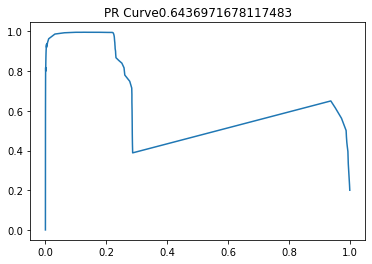

  0%|          | 1/400 [00:01<08:01,  1.21s/it]

Epoch loss :: 64.05709


  0%|          | 2/400 [00:02<08:11,  1.23s/it]

Epoch loss :: 64.06075


  1%|          | 3/400 [00:03<08:04,  1.22s/it]

Epoch loss :: 64.03039


  1%|          | 4/400 [00:04<07:57,  1.21s/it]

Epoch loss :: 63.953876


  1%|▏         | 5/400 [00:05<07:44,  1.18s/it]

Epoch loss :: 64.085396


  2%|▏         | 6/400 [00:06<07:22,  1.12s/it]

Epoch loss :: 64.08981


  2%|▏         | 7/400 [00:08<07:43,  1.18s/it]

Epoch loss :: 64.057495


  2%|▏         | 8/400 [00:09<07:35,  1.16s/it]

Epoch loss :: 64.00956


  2%|▏         | 9/400 [00:10<07:25,  1.14s/it]

Epoch loss :: 64.14783


  2%|▎         | 10/400 [00:11<07:43,  1.19s/it]

Epoch loss :: 64.03953


  3%|▎         | 11/400 [00:13<07:50,  1.21s/it]

Epoch loss :: 63.936005


  3%|▎         | 12/400 [00:14<08:09,  1.26s/it]

Epoch loss :: 64.0397


  3%|▎         | 13/400 [00:15<08:07,  1.26s/it]

Epoch loss :: 63.94644


  4%|▎         | 14/400 [00:17<08:12,  1.28s/it]

Epoch loss :: 64.001305


  4%|▍         | 15/400 [00:18<07:58,  1.24s/it]

Epoch loss :: 64.129486


  4%|▍         | 16/400 [00:19<08:00,  1.25s/it]

Epoch loss :: 64.02471


  4%|▍         | 17/400 [00:20<08:04,  1.27s/it]

Epoch loss :: 64.060905


  4%|▍         | 18/400 [00:21<07:50,  1.23s/it]

Epoch loss :: 64.02896


  5%|▍         | 19/400 [00:23<07:36,  1.20s/it]

Epoch loss :: 64.04879


  5%|▌         | 20/400 [00:24<07:13,  1.14s/it]

Epoch loss :: 64.065674


  5%|▌         | 21/400 [00:25<07:14,  1.15s/it]

Epoch loss :: 64.011955


  6%|▌         | 22/400 [00:26<07:26,  1.18s/it]

Epoch loss :: 64.128716


  6%|▌         | 23/400 [00:27<07:16,  1.16s/it]

Epoch loss :: 64.07624


  6%|▌         | 24/400 [00:28<06:55,  1.10s/it]

Epoch loss :: 64.04478


  6%|▋         | 25/400 [00:29<07:13,  1.16s/it]

Epoch loss :: 63.963886


  6%|▋         | 26/400 [00:31<07:18,  1.17s/it]

Epoch loss :: 64.02372


  7%|▋         | 27/400 [00:32<07:48,  1.26s/it]

Epoch loss :: 64.025276


  7%|▋         | 28/400 [00:33<08:06,  1.31s/it]

Epoch loss :: 64.099724


  7%|▋         | 29/400 [00:35<08:01,  1.30s/it]

Epoch loss :: 64.01293


  8%|▊         | 30/400 [00:36<07:54,  1.28s/it]

Epoch loss :: 64.01989


  8%|▊         | 31/400 [00:37<07:56,  1.29s/it]

Epoch loss :: 64.05212


  8%|▊         | 32/400 [00:38<07:41,  1.25s/it]

Epoch loss :: 63.98766


  8%|▊         | 33/400 [00:40<07:29,  1.22s/it]

Epoch loss :: 64.05442


  8%|▊         | 34/400 [00:41<07:29,  1.23s/it]

Epoch loss :: 64.111404


  9%|▉         | 35/400 [00:42<07:52,  1.29s/it]

Epoch loss :: 64.07145


  9%|▉         | 36/400 [00:44<08:10,  1.35s/it]

Epoch loss :: 64.03367


  9%|▉         | 37/400 [00:45<08:34,  1.42s/it]

Epoch loss :: 64.031044


 10%|▉         | 38/400 [00:47<08:17,  1.37s/it]

Epoch loss :: 64.0575


 10%|▉         | 39/400 [00:48<08:18,  1.38s/it]

Epoch loss :: 64.07302


 10%|█         | 40/400 [00:49<08:23,  1.40s/it]

Epoch loss :: 63.99692


 10%|█         | 41/400 [00:51<08:24,  1.41s/it]

Epoch loss :: 64.021034


 10%|█         | 42/400 [00:52<07:52,  1.32s/it]

Epoch loss :: 64.12973


 11%|█         | 43/400 [00:53<07:44,  1.30s/it]

Epoch loss :: 63.941784


 11%|█         | 44/400 [00:54<07:21,  1.24s/it]

Epoch loss :: 64.139465


 11%|█▏        | 45/400 [00:55<07:09,  1.21s/it]

Epoch loss :: 64.022514


 12%|█▏        | 46/400 [00:57<07:03,  1.20s/it]

Epoch loss :: 64.14868


 12%|█▏        | 47/400 [00:58<06:58,  1.18s/it]

Epoch loss :: 64.09048


 12%|█▏        | 48/400 [00:59<06:33,  1.12s/it]

Epoch loss :: 64.07032


 12%|█▏        | 49/400 [01:00<06:32,  1.12s/it]

Epoch loss :: 63.998936


 12%|█▎        | 50/400 [01:01<06:12,  1.07s/it]

Epoch loss :: 64.051865


 13%|█▎        | 51/400 [01:02<06:13,  1.07s/it]

Epoch loss :: 64.099434


 13%|█▎        | 52/400 [01:03<06:22,  1.10s/it]

Epoch loss :: 64.04532


 13%|█▎        | 53/400 [01:04<06:44,  1.16s/it]

Epoch loss :: 64.04523


 14%|█▎        | 54/400 [01:06<07:07,  1.24s/it]

Epoch loss :: 64.06464


 14%|█▍        | 55/400 [01:07<06:53,  1.20s/it]

Epoch loss :: 63.974426


 14%|█▍        | 56/400 [01:08<07:16,  1.27s/it]

Epoch loss :: 64.033844


 14%|█▍        | 57/400 [01:09<07:04,  1.24s/it]

Epoch loss :: 64.10491


 14%|█▍        | 58/400 [01:11<07:14,  1.27s/it]

Epoch loss :: 64.00776


 15%|█▍        | 59/400 [01:12<07:08,  1.26s/it]

Epoch loss :: 64.174


 15%|█▌        | 60/400 [01:13<07:05,  1.25s/it]

Epoch loss :: 64.05665


 15%|█▌        | 61/400 [01:14<07:01,  1.24s/it]

Epoch loss :: 64.09644


 16%|█▌        | 62/400 [01:16<07:01,  1.25s/it]

Epoch loss :: 64.04264


 16%|█▌        | 63/400 [01:17<07:00,  1.25s/it]

Epoch loss :: 64.153206


 16%|█▌        | 64/400 [01:18<06:40,  1.19s/it]

Epoch loss :: 64.080284


 16%|█▋        | 65/400 [01:19<06:23,  1.14s/it]

Epoch loss :: 63.983795


 16%|█▋        | 66/400 [01:20<06:18,  1.13s/it]

Epoch loss :: 64.15657


 17%|█▋        | 67/400 [01:22<06:35,  1.19s/it]

Epoch loss :: 64.046074


 17%|█▋        | 68/400 [01:23<06:45,  1.22s/it]

Epoch loss :: 64.07786


 17%|█▋        | 69/400 [01:24<07:07,  1.29s/it]

Epoch loss :: 63.97221


 18%|█▊        | 70/400 [01:26<07:09,  1.30s/it]

Epoch loss :: 64.09882


 18%|█▊        | 71/400 [01:27<07:18,  1.33s/it]

Epoch loss :: 63.936707


 18%|█▊        | 72/400 [01:28<07:12,  1.32s/it]

Epoch loss :: 64.12045


 18%|█▊        | 73/400 [01:30<07:14,  1.33s/it]

Epoch loss :: 64.044136


 18%|█▊        | 74/400 [01:31<07:24,  1.36s/it]

Epoch loss :: 64.05155


 19%|█▉        | 75/400 [01:32<06:51,  1.27s/it]

Epoch loss :: 64.01654


 19%|█▉        | 76/400 [01:33<06:51,  1.27s/it]

Epoch loss :: 64.11996


 19%|█▉        | 77/400 [01:35<06:58,  1.29s/it]

Epoch loss :: 64.15249


 20%|█▉        | 78/400 [01:36<06:54,  1.29s/it]

Epoch loss :: 64.01066


 20%|█▉        | 79/400 [01:37<06:53,  1.29s/it]

Epoch loss :: 64.009865


 20%|██        | 80/400 [01:39<07:05,  1.33s/it]

Epoch loss :: 63.990658


 20%|██        | 81/400 [01:40<07:01,  1.32s/it]

Epoch loss :: 64.02281


 20%|██        | 82/400 [01:41<06:25,  1.21s/it]

Epoch loss :: 64.01571


 21%|██        | 83/400 [01:42<06:21,  1.20s/it]

Epoch loss :: 64.14152


 21%|██        | 84/400 [01:43<06:24,  1.22s/it]

Epoch loss :: 64.06945


 21%|██▏       | 85/400 [01:44<06:00,  1.14s/it]

Epoch loss :: 64.0259


 22%|██▏       | 86/400 [01:46<06:27,  1.23s/it]

Epoch loss :: 64.04685


 22%|██▏       | 87/400 [01:47<06:31,  1.25s/it]

Epoch loss :: 64.00253


 22%|██▏       | 88/400 [01:48<06:31,  1.26s/it]

Epoch loss :: 64.05337


 22%|██▏       | 89/400 [01:50<06:55,  1.34s/it]

Epoch loss :: 64.06474


 22%|██▎       | 90/400 [01:51<06:54,  1.34s/it]

Epoch loss :: 64.08065


 23%|██▎       | 91/400 [01:53<07:12,  1.40s/it]

Epoch loss :: 64.09853


 23%|██▎       | 92/400 [01:54<07:03,  1.38s/it]

Epoch loss :: 64.060135


 23%|██▎       | 93/400 [01:56<07:13,  1.41s/it]

Epoch loss :: 64.10601


 24%|██▎       | 94/400 [01:57<07:26,  1.46s/it]

Epoch loss :: 64.102875


 24%|██▍       | 95/400 [01:59<07:22,  1.45s/it]

Epoch loss :: 63.990444


 24%|██▍       | 96/400 [02:00<07:11,  1.42s/it]

Epoch loss :: 63.977966


 24%|██▍       | 97/400 [02:01<07:04,  1.40s/it]

Epoch loss :: 64.118355


 24%|██▍       | 98/400 [02:03<06:50,  1.36s/it]

Epoch loss :: 64.018074


 25%|██▍       | 99/400 [02:04<06:27,  1.29s/it]

Epoch loss :: 64.058205


 25%|██▌       | 100/400 [02:05<06:32,  1.31s/it]

Epoch loss :: 64.19229


 25%|██▌       | 101/400 [02:06<06:31,  1.31s/it]

Epoch loss :: 64.02308


 26%|██▌       | 102/400 [02:08<06:30,  1.31s/it]

Epoch loss :: 64.00016


 26%|██▌       | 103/400 [02:09<06:22,  1.29s/it]

Epoch loss :: 64.01975


 26%|██▌       | 104/400 [02:10<06:16,  1.27s/it]

Epoch loss :: 64.027016


 26%|██▋       | 105/400 [02:11<05:57,  1.21s/it]

Epoch loss :: 64.023


 26%|██▋       | 106/400 [02:13<06:09,  1.26s/it]

Epoch loss :: 64.08734


 27%|██▋       | 107/400 [02:14<06:10,  1.27s/it]

Epoch loss :: 64.110634


 27%|██▋       | 108/400 [02:15<06:18,  1.30s/it]

Epoch loss :: 63.968555


 27%|██▋       | 109/400 [02:16<05:40,  1.17s/it]

Epoch loss :: 63.97737


 28%|██▊       | 110/400 [02:17<05:53,  1.22s/it]

Epoch loss :: 63.971302


 28%|██▊       | 111/400 [02:19<06:03,  1.26s/it]

Epoch loss :: 63.998257


 28%|██▊       | 112/400 [02:20<06:08,  1.28s/it]

Epoch loss :: 64.04418


 28%|██▊       | 113/400 [02:21<06:07,  1.28s/it]

Epoch loss :: 64.06861


 28%|██▊       | 114/400 [02:23<05:59,  1.26s/it]

Epoch loss :: 63.99632


 29%|██▉       | 115/400 [02:24<06:03,  1.27s/it]

Epoch loss :: 63.991028


 29%|██▉       | 116/400 [02:25<06:06,  1.29s/it]

Epoch loss :: 63.981125


 29%|██▉       | 117/400 [02:27<06:04,  1.29s/it]

Epoch loss :: 64.0521


 30%|██▉       | 118/400 [02:28<06:04,  1.29s/it]

Epoch loss :: 64.04035


 30%|██▉       | 119/400 [02:29<05:42,  1.22s/it]

Epoch loss :: 64.067764


 30%|███       | 120/400 [02:30<05:38,  1.21s/it]

Epoch loss :: 64.12454


 30%|███       | 121/400 [02:31<05:32,  1.19s/it]

Epoch loss :: 64.11248


 30%|███       | 122/400 [02:32<05:21,  1.16s/it]

Epoch loss :: 64.07261


 31%|███       | 123/400 [02:33<05:05,  1.10s/it]

Epoch loss :: 64.070206


 31%|███       | 124/400 [02:34<05:12,  1.13s/it]

Epoch loss :: 64.12461


 31%|███▏      | 125/400 [02:36<05:17,  1.15s/it]

Epoch loss :: 63.989544


 32%|███▏      | 126/400 [02:37<05:06,  1.12s/it]

Epoch loss :: 64.098335


 32%|███▏      | 127/400 [02:38<05:03,  1.11s/it]

Epoch loss :: 63.996693


 32%|███▏      | 128/400 [02:39<05:17,  1.17s/it]

Epoch loss :: 64.030525


 32%|███▏      | 129/400 [02:40<05:16,  1.17s/it]

Epoch loss :: 64.058815


 32%|███▎      | 130/400 [02:41<05:15,  1.17s/it]

Epoch loss :: 63.978268


 33%|███▎      | 131/400 [02:43<05:23,  1.20s/it]

Epoch loss :: 64.118324


 33%|███▎      | 132/400 [02:44<05:30,  1.24s/it]

Epoch loss :: 64.07296


 33%|███▎      | 133/400 [02:45<05:39,  1.27s/it]

Epoch loss :: 64.00109


 34%|███▎      | 134/400 [02:47<05:34,  1.26s/it]

Epoch loss :: 64.01548


 34%|███▍      | 135/400 [02:48<05:23,  1.22s/it]

Epoch loss :: 64.04196


 34%|███▍      | 136/400 [02:49<05:08,  1.17s/it]

Epoch loss :: 64.00516


 34%|███▍      | 137/400 [02:50<05:01,  1.15s/it]

Epoch loss :: 64.061295


 34%|███▍      | 138/400 [02:51<04:53,  1.12s/it]

Epoch loss :: 64.11855


 35%|███▍      | 139/400 [02:52<04:53,  1.12s/it]

Epoch loss :: 64.060425


 35%|███▌      | 140/400 [02:53<04:56,  1.14s/it]

Epoch loss :: 64.12475


 35%|███▌      | 141/400 [02:54<04:56,  1.14s/it]

Epoch loss :: 64.056816


 36%|███▌      | 142/400 [02:56<04:50,  1.13s/it]

Epoch loss :: 64.06213


 36%|███▌      | 143/400 [02:57<04:58,  1.16s/it]

Epoch loss :: 64.042274


 36%|███▌      | 144/400 [02:58<04:54,  1.15s/it]

Epoch loss :: 64.009544


 36%|███▋      | 145/400 [02:59<05:00,  1.18s/it]

Epoch loss :: 64.03173


 36%|███▋      | 146/400 [03:00<05:10,  1.22s/it]

Epoch loss :: 64.08353


 37%|███▋      | 147/400 [03:02<04:57,  1.18s/it]

Epoch loss :: 64.077354


 37%|███▋      | 148/400 [03:03<04:54,  1.17s/it]

Epoch loss :: 63.950222


 37%|███▋      | 149/400 [03:04<04:56,  1.18s/it]

Epoch loss :: 64.067406


 38%|███▊      | 150/400 [03:05<05:00,  1.20s/it]

Epoch loss :: 64.05198


 38%|███▊      | 151/400 [03:06<04:54,  1.18s/it]

Epoch loss :: 63.96545


 38%|███▊      | 152/400 [03:07<04:50,  1.17s/it]

Epoch loss :: 64.05081


 38%|███▊      | 153/400 [03:09<04:58,  1.21s/it]

Epoch loss :: 63.998047


 38%|███▊      | 154/400 [03:10<04:53,  1.19s/it]

Epoch loss :: 64.06396


 39%|███▉      | 155/400 [03:11<04:45,  1.16s/it]

Epoch loss :: 64.101204


 39%|███▉      | 156/400 [03:12<04:31,  1.11s/it]

Epoch loss :: 64.04318


 39%|███▉      | 157/400 [03:13<04:23,  1.09s/it]

Epoch loss :: 64.03785


 40%|███▉      | 158/400 [03:14<04:40,  1.16s/it]

Epoch loss :: 64.05222


 40%|███▉      | 159/400 [03:16<04:47,  1.19s/it]

Epoch loss :: 63.995575


 40%|████      | 160/400 [03:17<05:02,  1.26s/it]

Epoch loss :: 64.02108


 40%|████      | 161/400 [03:18<04:59,  1.25s/it]

Epoch loss :: 64.01821


 40%|████      | 162/400 [03:20<04:58,  1.26s/it]

Epoch loss :: 64.17025


 41%|████      | 163/400 [03:21<05:01,  1.27s/it]

Epoch loss :: 64.15707


 41%|████      | 164/400 [03:22<05:05,  1.30s/it]

Epoch loss :: 64.04675


 41%|████▏     | 165/400 [03:23<04:56,  1.26s/it]

Epoch loss :: 64.154724


 42%|████▏     | 166/400 [03:25<04:59,  1.28s/it]

Epoch loss :: 64.04682


 42%|████▏     | 167/400 [03:26<04:59,  1.29s/it]

Epoch loss :: 64.0241


 42%|████▏     | 168/400 [03:27<04:56,  1.28s/it]

Epoch loss :: 64.10394


 42%|████▏     | 169/400 [03:28<04:53,  1.27s/it]

Epoch loss :: 64.06444


 42%|████▎     | 170/400 [03:30<04:54,  1.28s/it]

Epoch loss :: 63.988544


 43%|████▎     | 171/400 [03:31<04:50,  1.27s/it]

Epoch loss :: 64.03887


 43%|████▎     | 172/400 [03:32<04:51,  1.28s/it]

Epoch loss :: 64.11495


 43%|████▎     | 173/400 [03:34<04:49,  1.28s/it]

Epoch loss :: 64.13048


 44%|████▎     | 174/400 [03:35<04:46,  1.27s/it]

Epoch loss :: 64.05761


 44%|████▍     | 175/400 [03:36<04:42,  1.25s/it]

Epoch loss :: 64.0441


 44%|████▍     | 176/400 [03:37<04:34,  1.23s/it]

Epoch loss :: 63.962505


 44%|████▍     | 177/400 [03:39<04:39,  1.25s/it]

Epoch loss :: 64.02649


 44%|████▍     | 178/400 [03:40<04:33,  1.23s/it]

Epoch loss :: 64.087395


 45%|████▍     | 179/400 [03:41<04:40,  1.27s/it]

Epoch loss :: 64.04499


 45%|████▌     | 180/400 [03:42<04:34,  1.25s/it]

Epoch loss :: 64.05636


 45%|████▌     | 181/400 [03:44<04:35,  1.26s/it]

Epoch loss :: 64.03484


 46%|████▌     | 182/400 [03:45<04:21,  1.20s/it]

Epoch loss :: 64.05988


 46%|████▌     | 183/400 [03:46<04:30,  1.25s/it]

Epoch loss :: 64.01679


 46%|████▌     | 184/400 [03:47<04:27,  1.24s/it]

Epoch loss :: 64.0252


 46%|████▋     | 185/400 [03:49<04:36,  1.28s/it]

Epoch loss :: 64.07089


 46%|████▋     | 186/400 [03:50<04:34,  1.28s/it]

Epoch loss :: 64.03823


 47%|████▋     | 187/400 [03:51<04:06,  1.16s/it]

Epoch loss :: 63.988323


 47%|████▋     | 188/400 [03:52<04:06,  1.16s/it]

Epoch loss :: 64.15736


 47%|████▋     | 189/400 [03:53<04:15,  1.21s/it]

Epoch loss :: 64.09623


 48%|████▊     | 190/400 [03:55<04:22,  1.25s/it]

Epoch loss :: 64.08552


 48%|████▊     | 191/400 [03:56<04:27,  1.28s/it]

Epoch loss :: 64.03918


 48%|████▊     | 192/400 [03:57<04:26,  1.28s/it]

Epoch loss :: 64.016594


 48%|████▊     | 193/400 [03:58<04:23,  1.27s/it]

Epoch loss :: 64.0745


 48%|████▊     | 194/400 [03:59<04:06,  1.20s/it]

Epoch loss :: 64.144356


 49%|████▉     | 195/400 [04:01<04:16,  1.25s/it]

Epoch loss :: 63.969067


 49%|████▉     | 196/400 [04:02<04:21,  1.28s/it]

Epoch loss :: 64.102135


 49%|████▉     | 197/400 [04:04<04:20,  1.28s/it]

Epoch loss :: 64.02236


 50%|████▉     | 198/400 [04:05<04:23,  1.31s/it]

Epoch loss :: 63.981525


 50%|████▉     | 199/400 [04:06<04:22,  1.30s/it]

Epoch loss :: 64.10197


 50%|█████     | 200/400 [04:07<04:21,  1.31s/it]

Epoch loss :: 64.05295


 50%|█████     | 201/400 [04:09<04:18,  1.30s/it]

Epoch loss :: 64.14248


 50%|█████     | 202/400 [04:10<04:11,  1.27s/it]

Epoch loss :: 64.035194


 51%|█████     | 203/400 [04:11<03:59,  1.21s/it]

Epoch loss :: 64.02926


 51%|█████     | 204/400 [04:12<03:47,  1.16s/it]

Epoch loss :: 64.04722


 51%|█████▏    | 205/400 [04:13<03:46,  1.16s/it]

Epoch loss :: 64.08085


 52%|█████▏    | 206/400 [04:14<03:40,  1.13s/it]

Epoch loss :: 64.03966


 52%|█████▏    | 207/400 [04:15<03:31,  1.09s/it]

Epoch loss :: 64.09078


 52%|█████▏    | 208/400 [04:16<03:35,  1.12s/it]

Epoch loss :: 63.957214


 52%|█████▏    | 209/400 [04:18<03:35,  1.13s/it]

Epoch loss :: 64.043495


 52%|█████▎    | 210/400 [04:19<03:39,  1.15s/it]

Epoch loss :: 64.12582


 53%|█████▎    | 211/400 [04:20<03:43,  1.18s/it]

Epoch loss :: 64.115135


 53%|█████▎    | 212/400 [04:21<03:41,  1.18s/it]

Epoch loss :: 64.02761


 53%|█████▎    | 213/400 [04:22<03:38,  1.17s/it]

Epoch loss :: 64.12722


 54%|█████▎    | 214/400 [04:24<03:35,  1.16s/it]

Epoch loss :: 64.02981


 54%|█████▍    | 215/400 [04:25<03:38,  1.18s/it]

Epoch loss :: 64.107155


 54%|█████▍    | 216/400 [04:26<03:30,  1.15s/it]

Epoch loss :: 64.12775


 54%|█████▍    | 217/400 [04:27<03:27,  1.13s/it]

Epoch loss :: 64.08969


 55%|█████▍    | 218/400 [04:28<03:15,  1.07s/it]

Epoch loss :: 63.968933


 55%|█████▍    | 219/400 [04:29<03:14,  1.07s/it]

Epoch loss :: 63.965454


 55%|█████▌    | 220/400 [04:30<03:15,  1.09s/it]

Epoch loss :: 64.21908


 55%|█████▌    | 221/400 [04:31<03:14,  1.08s/it]

Epoch loss :: 63.974308


 56%|█████▌    | 222/400 [04:32<03:12,  1.08s/it]

Epoch loss :: 64.05754


 56%|█████▌    | 223/400 [04:33<03:09,  1.07s/it]

Epoch loss :: 64.15348


 56%|█████▌    | 224/400 [04:35<03:16,  1.12s/it]

Epoch loss :: 63.93977


 56%|█████▋    | 225/400 [04:36<03:21,  1.15s/it]

Epoch loss :: 64.10766


 56%|█████▋    | 226/400 [04:37<03:24,  1.17s/it]

Epoch loss :: 64.08273


 57%|█████▋    | 227/400 [04:38<03:17,  1.14s/it]

Epoch loss :: 63.974903


 57%|█████▋    | 228/400 [04:39<03:15,  1.14s/it]

Epoch loss :: 63.986767


 57%|█████▋    | 229/400 [04:41<03:26,  1.21s/it]

Epoch loss :: 64.0528


 57%|█████▊    | 230/400 [04:42<03:33,  1.25s/it]

Epoch loss :: 64.029625


 58%|█████▊    | 231/400 [04:43<03:23,  1.21s/it]

Epoch loss :: 64.00984


 58%|█████▊    | 232/400 [04:44<03:20,  1.20s/it]

Epoch loss :: 64.0769


 58%|█████▊    | 233/400 [04:45<03:25,  1.23s/it]

Epoch loss :: 64.03985


 58%|█████▊    | 234/400 [04:47<03:26,  1.24s/it]

Epoch loss :: 63.97114


 59%|█████▉    | 235/400 [04:48<03:19,  1.21s/it]

Epoch loss :: 64.15891


 59%|█████▉    | 236/400 [04:49<03:19,  1.22s/it]

Epoch loss :: 63.987957


 59%|█████▉    | 237/400 [04:50<03:17,  1.21s/it]

Epoch loss :: 63.988354


 60%|█████▉    | 238/400 [04:52<03:19,  1.23s/it]

Epoch loss :: 63.929535


 60%|█████▉    | 239/400 [04:53<03:19,  1.24s/it]

Epoch loss :: 64.03347


 60%|██████    | 240/400 [04:54<03:13,  1.21s/it]

Epoch loss :: 64.105064


 60%|██████    | 241/400 [04:55<03:09,  1.19s/it]

Epoch loss :: 63.96872


 60%|██████    | 242/400 [04:56<02:59,  1.14s/it]

Epoch loss :: 64.00953


 61%|██████    | 243/400 [04:57<03:05,  1.18s/it]

Epoch loss :: 64.0484


 61%|██████    | 244/400 [04:59<03:09,  1.22s/it]

Epoch loss :: 64.04168


 61%|██████▏   | 245/400 [05:00<03:02,  1.18s/it]

Epoch loss :: 64.03416


 62%|██████▏   | 246/400 [05:01<03:02,  1.18s/it]

Epoch loss :: 63.97472


 62%|██████▏   | 247/400 [05:02<02:50,  1.11s/it]

Epoch loss :: 64.07416


 62%|██████▏   | 248/400 [05:03<02:49,  1.11s/it]

Epoch loss :: 64.06669


 62%|██████▏   | 249/400 [05:04<02:52,  1.14s/it]

Epoch loss :: 63.972797


 62%|██████▎   | 250/400 [05:05<02:49,  1.13s/it]

Epoch loss :: 64.09007


 63%|██████▎   | 251/400 [05:06<02:42,  1.09s/it]

Epoch loss :: 64.064575


 63%|██████▎   | 252/400 [05:07<02:40,  1.09s/it]

Epoch loss :: 64.173836


 63%|██████▎   | 253/400 [05:09<02:44,  1.12s/it]

Epoch loss :: 64.14671


 64%|██████▎   | 254/400 [05:10<02:43,  1.12s/it]

Epoch loss :: 64.084175


 64%|██████▍   | 255/400 [05:11<02:48,  1.17s/it]

Epoch loss :: 64.0177


 64%|██████▍   | 256/400 [05:12<02:52,  1.20s/it]

Epoch loss :: 64.05142


 64%|██████▍   | 257/400 [05:14<02:53,  1.21s/it]

Epoch loss :: 64.05276


 64%|██████▍   | 258/400 [05:15<02:52,  1.21s/it]

Epoch loss :: 64.02534


 65%|██████▍   | 259/400 [05:16<02:47,  1.19s/it]

Epoch loss :: 64.0879


 65%|██████▌   | 260/400 [05:17<02:48,  1.20s/it]

Epoch loss :: 64.101265


 65%|██████▌   | 261/400 [05:18<02:46,  1.19s/it]

Epoch loss :: 63.96451


 66%|██████▌   | 262/400 [05:19<02:42,  1.18s/it]

Epoch loss :: 64.04858


 66%|██████▌   | 263/400 [05:21<02:47,  1.22s/it]

Epoch loss :: 64.14603


 66%|██████▌   | 264/400 [05:22<02:46,  1.22s/it]

Epoch loss :: 64.02799


 66%|██████▋   | 265/400 [05:23<02:51,  1.27s/it]

Epoch loss :: 64.093925


 66%|██████▋   | 266/400 [05:25<02:45,  1.23s/it]

Epoch loss :: 64.06808


 67%|██████▋   | 267/400 [05:26<02:41,  1.22s/it]

Epoch loss :: 64.07592


 67%|██████▋   | 268/400 [05:27<02:36,  1.18s/it]

Epoch loss :: 64.060265


 67%|██████▋   | 269/400 [05:28<02:28,  1.13s/it]

Epoch loss :: 64.084305


 68%|██████▊   | 270/400 [05:29<02:27,  1.13s/it]

Epoch loss :: 64.07806


 68%|██████▊   | 271/400 [05:30<02:29,  1.16s/it]

Epoch loss :: 64.06838


 68%|██████▊   | 272/400 [05:31<02:31,  1.18s/it]

Epoch loss :: 64.09553


 68%|██████▊   | 273/400 [05:32<02:19,  1.10s/it]

Epoch loss :: 64.075035


 68%|██████▊   | 274/400 [05:34<02:24,  1.14s/it]

Epoch loss :: 64.019005


 69%|██████▉   | 275/400 [05:35<02:25,  1.16s/it]

Epoch loss :: 63.964508


 69%|██████▉   | 276/400 [05:36<02:22,  1.15s/it]

Epoch loss :: 64.04181


 69%|██████▉   | 277/400 [05:37<02:28,  1.20s/it]

Epoch loss :: 64.01906


 70%|██████▉   | 278/400 [05:39<02:30,  1.23s/it]

Epoch loss :: 64.06555


 70%|██████▉   | 279/400 [05:40<02:25,  1.21s/it]

Epoch loss :: 64.088776


 70%|███████   | 280/400 [05:41<02:26,  1.22s/it]

Epoch loss :: 64.186806


 70%|███████   | 281/400 [05:42<02:22,  1.20s/it]

Epoch loss :: 64.05581


 70%|███████   | 282/400 [05:43<02:24,  1.23s/it]

Epoch loss :: 64.04541


 71%|███████   | 283/400 [05:44<02:15,  1.16s/it]

Epoch loss :: 64.03045


 71%|███████   | 284/400 [05:46<02:21,  1.22s/it]

Epoch loss :: 64.10674


 71%|███████▏  | 285/400 [05:47<02:23,  1.25s/it]

Epoch loss :: 64.08334


 72%|███████▏  | 286/400 [05:48<02:20,  1.24s/it]

Epoch loss :: 64.04511


 72%|███████▏  | 287/400 [05:49<02:16,  1.21s/it]

Epoch loss :: 64.02471


 72%|███████▏  | 288/400 [05:51<02:10,  1.17s/it]

Epoch loss :: 64.114296


 72%|███████▏  | 289/400 [05:52<02:05,  1.13s/it]

Epoch loss :: 63.994396


 72%|███████▎  | 290/400 [05:53<02:05,  1.14s/it]

Epoch loss :: 64.13968


 73%|███████▎  | 291/400 [05:54<02:04,  1.14s/it]

Epoch loss :: 64.08631


 73%|███████▎  | 292/400 [05:55<01:59,  1.11s/it]

Epoch loss :: 64.00878


 73%|███████▎  | 293/400 [05:56<02:07,  1.20s/it]

Epoch loss :: 64.00931


 74%|███████▎  | 294/400 [05:57<02:01,  1.15s/it]

Epoch loss :: 64.01181


 74%|███████▍  | 295/400 [05:58<01:58,  1.13s/it]

Epoch loss :: 64.06878


 74%|███████▍  | 296/400 [06:00<02:05,  1.20s/it]

Epoch loss :: 63.976273


 74%|███████▍  | 297/400 [06:01<02:05,  1.22s/it]

Epoch loss :: 64.03006


 74%|███████▍  | 298/400 [06:02<02:05,  1.23s/it]

Epoch loss :: 64.02961


 75%|███████▍  | 299/400 [06:04<02:15,  1.34s/it]

Epoch loss :: 64.11782


 75%|███████▌  | 300/400 [06:05<02:15,  1.36s/it]

Epoch loss :: 64.05962


 75%|███████▌  | 301/400 [06:06<02:09,  1.31s/it]

Epoch loss :: 64.056595


 76%|███████▌  | 302/400 [06:08<02:01,  1.24s/it]

Epoch loss :: 64.0537


 76%|███████▌  | 303/400 [06:09<01:53,  1.17s/it]

Epoch loss :: 64.01449


 76%|███████▌  | 304/400 [06:10<01:52,  1.18s/it]

Epoch loss :: 64.04681


 76%|███████▋  | 305/400 [06:11<01:51,  1.17s/it]

Epoch loss :: 64.03564


 76%|███████▋  | 306/400 [06:12<01:51,  1.18s/it]

Epoch loss :: 64.07589


 77%|███████▋  | 307/400 [06:13<01:50,  1.18s/it]

Epoch loss :: 63.95694


 77%|███████▋  | 308/400 [06:14<01:47,  1.17s/it]

Epoch loss :: 64.10769


 77%|███████▋  | 309/400 [06:16<01:45,  1.16s/it]

Epoch loss :: 64.00202


 78%|███████▊  | 310/400 [06:17<01:47,  1.19s/it]

Epoch loss :: 64.083885


 78%|███████▊  | 311/400 [06:18<01:49,  1.23s/it]

Epoch loss :: 64.053986


 78%|███████▊  | 312/400 [06:19<01:47,  1.22s/it]

Epoch loss :: 64.01354


 78%|███████▊  | 313/400 [06:20<01:43,  1.19s/it]

Epoch loss :: 64.05189


 78%|███████▊  | 314/400 [06:22<01:42,  1.19s/it]

Epoch loss :: 63.959156


 79%|███████▉  | 315/400 [06:23<01:41,  1.19s/it]

Epoch loss :: 64.12927


 79%|███████▉  | 316/400 [06:24<01:35,  1.14s/it]

Epoch loss :: 64.06194


 79%|███████▉  | 317/400 [06:25<01:35,  1.15s/it]

Epoch loss :: 64.06071


 80%|███████▉  | 318/400 [06:26<01:41,  1.23s/it]

Epoch loss :: 64.037186


 80%|███████▉  | 319/400 [06:28<01:38,  1.22s/it]

Epoch loss :: 64.049644


 80%|████████  | 320/400 [06:29<01:38,  1.23s/it]

Epoch loss :: 64.09835


 80%|████████  | 321/400 [06:30<01:33,  1.18s/it]

Epoch loss :: 64.08604


 80%|████████  | 322/400 [06:31<01:30,  1.17s/it]

Epoch loss :: 64.04117


 81%|████████  | 323/400 [06:32<01:32,  1.20s/it]

Epoch loss :: 64.150055


 81%|████████  | 324/400 [06:33<01:25,  1.12s/it]

Epoch loss :: 64.03147


 81%|████████▏ | 325/400 [06:35<01:28,  1.18s/it]

Epoch loss :: 64.120056


 82%|████████▏ | 326/400 [06:36<01:27,  1.18s/it]

Epoch loss :: 64.0243


 82%|████████▏ | 327/400 [06:37<01:28,  1.21s/it]

Epoch loss :: 64.06394


 82%|████████▏ | 328/400 [06:38<01:18,  1.10s/it]

Epoch loss :: 64.01968


 82%|████████▏ | 329/400 [06:39<01:23,  1.18s/it]

Epoch loss :: 63.957684


 82%|████████▎ | 330/400 [06:41<01:23,  1.19s/it]

Epoch loss :: 64.07877


 83%|████████▎ | 331/400 [06:42<01:25,  1.23s/it]

Epoch loss :: 64.00826


 83%|████████▎ | 332/400 [06:43<01:25,  1.26s/it]

Epoch loss :: 64.13


 83%|████████▎ | 333/400 [06:44<01:24,  1.26s/it]

Epoch loss :: 63.955227


 84%|████████▎ | 334/400 [06:46<01:19,  1.21s/it]

Epoch loss :: 64.01345


 84%|████████▍ | 335/400 [06:47<01:21,  1.25s/it]

Epoch loss :: 64.020485


 84%|████████▍ | 336/400 [06:48<01:21,  1.28s/it]

Epoch loss :: 64.1008


 84%|████████▍ | 337/400 [06:49<01:18,  1.25s/it]

Epoch loss :: 63.972057


 84%|████████▍ | 338/400 [06:51<01:19,  1.28s/it]

Epoch loss :: 64.15789


 85%|████████▍ | 339/400 [06:52<01:19,  1.30s/it]

Epoch loss :: 64.103806


 85%|████████▌ | 340/400 [06:53<01:13,  1.22s/it]

Epoch loss :: 64.064064


 85%|████████▌ | 341/400 [06:54<01:13,  1.25s/it]

Epoch loss :: 64.012024


 86%|████████▌ | 342/400 [06:56<01:12,  1.25s/it]

Epoch loss :: 64.04789


 86%|████████▌ | 343/400 [06:57<01:10,  1.23s/it]

Epoch loss :: 64.068954


 86%|████████▌ | 344/400 [06:58<01:09,  1.25s/it]

Epoch loss :: 64.03437


 86%|████████▋ | 345/400 [06:59<01:08,  1.24s/it]

Epoch loss :: 64.10446


 86%|████████▋ | 346/400 [07:01<01:08,  1.27s/it]

Epoch loss :: 64.05108


 87%|████████▋ | 347/400 [07:02<01:05,  1.23s/it]

Epoch loss :: 64.01617


 87%|████████▋ | 348/400 [07:03<01:03,  1.22s/it]

Epoch loss :: 64.053215


 87%|████████▋ | 349/400 [07:04<01:01,  1.21s/it]

Epoch loss :: 64.08256


 88%|████████▊ | 350/400 [07:06<01:03,  1.26s/it]

Epoch loss :: 64.0206


 88%|████████▊ | 351/400 [07:07<01:02,  1.28s/it]

Epoch loss :: 64.161354


 88%|████████▊ | 352/400 [07:08<01:01,  1.28s/it]

Epoch loss :: 64.10787


 88%|████████▊ | 353/400 [07:10<00:59,  1.26s/it]

Epoch loss :: 64.0399


 88%|████████▊ | 354/400 [07:11<00:58,  1.27s/it]

Epoch loss :: 64.03051


 89%|████████▉ | 355/400 [07:12<00:59,  1.32s/it]

Epoch loss :: 64.09426


 89%|████████▉ | 356/400 [07:13<00:57,  1.30s/it]

Epoch loss :: 64.06246


 89%|████████▉ | 357/400 [07:15<00:55,  1.28s/it]

Epoch loss :: 64.10834


 90%|████████▉ | 358/400 [07:16<00:50,  1.20s/it]

Epoch loss :: 64.022415


 90%|████████▉ | 359/400 [07:17<00:47,  1.16s/it]

Epoch loss :: 64.08026


 90%|█████████ | 360/400 [07:18<00:45,  1.13s/it]

Epoch loss :: 64.053894


 90%|█████████ | 361/400 [07:19<00:44,  1.14s/it]

Epoch loss :: 64.0092


 90%|█████████ | 362/400 [07:20<00:42,  1.11s/it]

Epoch loss :: 63.993275


 91%|█████████ | 363/400 [07:21<00:39,  1.07s/it]

Epoch loss :: 64.037254


 91%|█████████ | 364/400 [07:22<00:39,  1.11s/it]

Epoch loss :: 64.14286


 91%|█████████▏| 365/400 [07:23<00:40,  1.15s/it]

Epoch loss :: 64.0165


 92%|█████████▏| 366/400 [07:25<00:40,  1.20s/it]

Epoch loss :: 63.973644


 92%|█████████▏| 367/400 [07:26<00:40,  1.23s/it]

Epoch loss :: 64.00536


 92%|█████████▏| 368/400 [07:27<00:38,  1.21s/it]

Epoch loss :: 63.991837


 92%|█████████▏| 369/400 [07:28<00:36,  1.17s/it]

Epoch loss :: 64.0577


 92%|█████████▎| 370/400 [07:29<00:33,  1.13s/it]

Epoch loss :: 64.04795


 93%|█████████▎| 371/400 [07:31<00:33,  1.15s/it]

Epoch loss :: 64.07709


 93%|█████████▎| 372/400 [07:32<00:32,  1.15s/it]

Epoch loss :: 64.146866


 93%|█████████▎| 373/400 [07:33<00:30,  1.11s/it]

Epoch loss :: 64.0001


 94%|█████████▎| 374/400 [07:34<00:28,  1.09s/it]

Epoch loss :: 64.07803


 94%|█████████▍| 375/400 [07:35<00:27,  1.11s/it]

Epoch loss :: 63.99962


 94%|█████████▍| 376/400 [07:36<00:26,  1.11s/it]

Epoch loss :: 64.07155


 94%|█████████▍| 377/400 [07:37<00:24,  1.08s/it]

Epoch loss :: 64.026634


 94%|█████████▍| 378/400 [07:38<00:23,  1.08s/it]

Epoch loss :: 64.05189


 95%|█████████▍| 379/400 [07:39<00:23,  1.11s/it]

Epoch loss :: 64.057076


 95%|█████████▌| 380/400 [07:41<00:22,  1.14s/it]

Epoch loss :: 63.974888


 95%|█████████▌| 381/400 [07:42<00:22,  1.18s/it]

Epoch loss :: 64.00577


 96%|█████████▌| 382/400 [07:43<00:21,  1.19s/it]

Epoch loss :: 63.969585


 96%|█████████▌| 383/400 [07:44<00:20,  1.18s/it]

Epoch loss :: 64.055405


 96%|█████████▌| 384/400 [07:45<00:18,  1.15s/it]

Epoch loss :: 64.00198


 96%|█████████▋| 385/400 [07:46<00:17,  1.14s/it]

Epoch loss :: 64.12278


 96%|█████████▋| 386/400 [07:48<00:16,  1.15s/it]

Epoch loss :: 64.06491


 97%|█████████▋| 387/400 [07:49<00:15,  1.16s/it]

Epoch loss :: 64.059975


 97%|█████████▋| 388/400 [07:50<00:13,  1.12s/it]

Epoch loss :: 63.94782


 97%|█████████▋| 389/400 [07:51<00:12,  1.10s/it]

Epoch loss :: 64.065735


 98%|█████████▊| 390/400 [07:52<00:11,  1.12s/it]

Epoch loss :: 64.03589


 98%|█████████▊| 391/400 [07:53<00:10,  1.15s/it]

Epoch loss :: 64.12098


 98%|█████████▊| 392/400 [07:54<00:09,  1.16s/it]

Epoch loss :: 63.98906


 98%|█████████▊| 393/400 [07:56<00:08,  1.17s/it]

Epoch loss :: 64.08337


 98%|█████████▊| 394/400 [07:57<00:06,  1.16s/it]

Epoch loss :: 64.15133


 99%|█████████▉| 395/400 [07:58<00:05,  1.18s/it]

Epoch loss :: 64.04769


 99%|█████████▉| 396/400 [07:59<00:04,  1.14s/it]

Epoch loss :: 64.07348


 99%|█████████▉| 397/400 [08:00<00:03,  1.18s/it]

Epoch loss :: 64.090164


100%|█████████▉| 398/400 [08:02<00:02,  1.20s/it]

Epoch loss :: 63.980083


100%|█████████▉| 399/400 [08:03<00:01,  1.21s/it]

Epoch loss :: 64.03751


100%|██████████| 400/400 [08:04<00:00,  1.21s/it]

Epoch loss :: 64.11328
======================TEST MODE======================


N: 68094
phi : tensor([0.6150, 0.3850], device='cuda:0', grad_fn=<DivBackward0>)
mu :  tensor([[-0.2840,  1.1901, -0.1257],
        [-0.2840,  1.1901, -0.1254]], device='cuda:0', grad_fn=<DivBackward0>)
covariance : tensor([[[ 0.0002, -0.0001,  0.0004],
         [-0.0001,  0.0006, -0.0008],
         [ 0.0004, -0.0008,  0.0027]],

        [[ 0.0002, -0.0001,  0.0004],
         [-0.0001,  0.0006, -0.0008],
         [ 0.0004, -0.0008,  0.0027]]], device='cuda:0',
       grad_fn=<DivBackward0>)
Size of test  48639
test_energy (48639,)
Precision 0.7604440789473684  Recall 0.7605066206102475  F1 >> 0.7604748484932775
AUC : 0.6839 


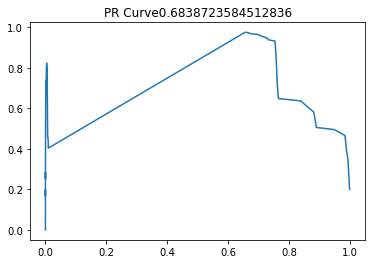

  0%|          | 1/400 [00:01<08:32,  1.28s/it]

Epoch loss :: 85.25086


  0%|          | 2/400 [00:02<08:21,  1.26s/it]

Epoch loss :: 85.01595


  1%|          | 3/400 [00:03<08:21,  1.26s/it]

Epoch loss :: 85.18568


  1%|          | 4/400 [00:04<08:08,  1.23s/it]

Epoch loss :: 85.176544


  1%|▏         | 5/400 [00:06<07:49,  1.19s/it]

Epoch loss :: 85.06144


  2%|▏         | 6/400 [00:07<07:48,  1.19s/it]

Epoch loss :: 85.236


  2%|▏         | 7/400 [00:08<07:32,  1.15s/it]

Epoch loss :: 85.019905


  2%|▏         | 8/400 [00:09<07:43,  1.18s/it]

Epoch loss :: 85.19806


  2%|▏         | 9/400 [00:10<07:26,  1.14s/it]

Epoch loss :: 85.23542


  2%|▎         | 10/400 [00:11<07:35,  1.17s/it]

Epoch loss :: 85.11795


  3%|▎         | 11/400 [00:12<07:23,  1.14s/it]

Epoch loss :: 85.055504


  3%|▎         | 12/400 [00:13<07:11,  1.11s/it]

Epoch loss :: 85.047905


  3%|▎         | 13/400 [00:15<07:14,  1.12s/it]

Epoch loss :: 85.03483


  4%|▎         | 14/400 [00:16<07:17,  1.13s/it]

Epoch loss :: 85.15478


  4%|▍         | 15/400 [00:17<07:20,  1.14s/it]

Epoch loss :: 85.10227


  4%|▍         | 16/400 [00:18<07:35,  1.19s/it]

Epoch loss :: 84.98841


  4%|▍         | 17/400 [00:19<07:33,  1.18s/it]

Epoch loss :: 85.14283


  4%|▍         | 18/400 [00:21<07:29,  1.18s/it]

Epoch loss :: 85.126854


  5%|▍         | 19/400 [00:22<07:18,  1.15s/it]

Epoch loss :: 85.021866


  5%|▌         | 20/400 [00:23<07:33,  1.19s/it]

Epoch loss :: 85.20242


  5%|▌         | 21/400 [00:24<07:45,  1.23s/it]

Epoch loss :: 84.9925


  6%|▌         | 22/400 [00:25<07:42,  1.22s/it]

Epoch loss :: 85.13944


  6%|▌         | 23/400 [00:26<07:22,  1.17s/it]

Epoch loss :: 85.19132


  6%|▌         | 24/400 [00:28<07:37,  1.22s/it]

Epoch loss :: 85.08325


  6%|▋         | 25/400 [00:29<07:48,  1.25s/it]

Epoch loss :: 85.20277


  6%|▋         | 26/400 [00:30<07:30,  1.20s/it]

Epoch loss :: 85.08553


  7%|▋         | 27/400 [00:32<07:42,  1.24s/it]

Epoch loss :: 85.08608


  7%|▋         | 28/400 [00:33<07:47,  1.26s/it]

Epoch loss :: 85.20765


  7%|▋         | 29/400 [00:34<07:37,  1.23s/it]

Epoch loss :: 85.23172


  8%|▊         | 30/400 [00:35<07:36,  1.23s/it]

Epoch loss :: 85.141014


  8%|▊         | 31/400 [00:36<07:09,  1.17s/it]

Epoch loss :: 85.08856


  8%|▊         | 32/400 [00:37<07:16,  1.19s/it]

Epoch loss :: 85.12693


  8%|▊         | 33/400 [00:39<07:02,  1.15s/it]

Epoch loss :: 85.126144


  8%|▊         | 34/400 [00:40<07:35,  1.24s/it]

Epoch loss :: 85.127594


  9%|▉         | 35/400 [00:41<07:20,  1.21s/it]

Epoch loss :: 85.0163


  9%|▉         | 36/400 [00:42<07:32,  1.24s/it]

Epoch loss :: 85.08724


  9%|▉         | 37/400 [00:44<07:40,  1.27s/it]

Epoch loss :: 85.21113


 10%|▉         | 38/400 [00:45<07:56,  1.32s/it]

Epoch loss :: 85.08295


 10%|▉         | 39/400 [00:47<08:10,  1.36s/it]

Epoch loss :: 85.024925


 10%|█         | 40/400 [00:48<08:07,  1.35s/it]

Epoch loss :: 85.05648


 10%|█         | 41/400 [00:49<07:48,  1.31s/it]

Epoch loss :: 85.201454


 10%|█         | 42/400 [00:51<07:48,  1.31s/it]

Epoch loss :: 85.113434


 11%|█         | 43/400 [00:52<07:47,  1.31s/it]

Epoch loss :: 85.174736


 11%|█         | 44/400 [00:53<07:41,  1.30s/it]

Epoch loss :: 85.06165


 11%|█▏        | 45/400 [00:54<07:31,  1.27s/it]

Epoch loss :: 85.06069


 12%|█▏        | 46/400 [00:55<07:12,  1.22s/it]

Epoch loss :: 85.042


 12%|█▏        | 47/400 [00:57<07:02,  1.20s/it]

Epoch loss :: 85.19843


 12%|█▏        | 48/400 [00:58<06:55,  1.18s/it]

Epoch loss :: 85.078026


 12%|█▏        | 49/400 [00:59<06:42,  1.15s/it]

Epoch loss :: 85.091896


 12%|█▎        | 50/400 [01:00<06:35,  1.13s/it]

Epoch loss :: 85.12978


 13%|█▎        | 51/400 [01:01<06:40,  1.15s/it]

Epoch loss :: 85.19988


 13%|█▎        | 52/400 [01:02<06:24,  1.11s/it]

Epoch loss :: 85.05199


 13%|█▎        | 53/400 [01:03<06:15,  1.08s/it]

Epoch loss :: 85.1317


 14%|█▎        | 54/400 [01:04<06:27,  1.12s/it]

Epoch loss :: 85.0743


 14%|█▍        | 55/400 [01:05<06:29,  1.13s/it]

Epoch loss :: 85.17124


 14%|█▍        | 56/400 [01:07<06:34,  1.15s/it]

Epoch loss :: 85.01304


 14%|█▍        | 57/400 [01:08<06:46,  1.19s/it]

Epoch loss :: 85.05152


 14%|█▍        | 58/400 [01:09<06:27,  1.13s/it]

Epoch loss :: 85.06769


 15%|█▍        | 59/400 [01:10<06:14,  1.10s/it]

Epoch loss :: 85.098885


 15%|█▌        | 60/400 [01:11<06:20,  1.12s/it]

Epoch loss :: 85.07685


 15%|█▌        | 61/400 [01:12<06:40,  1.18s/it]

Epoch loss :: 85.147484


 16%|█▌        | 62/400 [01:14<06:42,  1.19s/it]

Epoch loss :: 85.144745


 16%|█▌        | 63/400 [01:15<06:17,  1.12s/it]

Epoch loss :: 85.115


 16%|█▌        | 64/400 [01:16<06:23,  1.14s/it]

Epoch loss :: 85.03475


 16%|█▋        | 65/400 [01:17<06:21,  1.14s/it]

Epoch loss :: 85.05306


 16%|█▋        | 66/400 [01:18<06:27,  1.16s/it]

Epoch loss :: 85.099174


 17%|█▋        | 67/400 [01:19<06:29,  1.17s/it]

Epoch loss :: 85.16686


 17%|█▋        | 68/400 [01:21<06:28,  1.17s/it]

Epoch loss :: 85.086555


 17%|█▋        | 69/400 [01:22<06:26,  1.17s/it]

Epoch loss :: 85.11611


 18%|█▊        | 70/400 [01:23<06:08,  1.12s/it]

Epoch loss :: 85.10798


 18%|█▊        | 71/400 [01:24<06:13,  1.14s/it]

Epoch loss :: 85.09436


 18%|█▊        | 72/400 [01:25<06:12,  1.13s/it]

Epoch loss :: 85.04788


 18%|█▊        | 73/400 [01:26<06:11,  1.14s/it]

Epoch loss :: 85.10853


 18%|█▊        | 74/400 [01:27<06:01,  1.11s/it]

Epoch loss :: 85.12066


 19%|█▉        | 75/400 [01:28<06:00,  1.11s/it]

Epoch loss :: 85.160866


 19%|█▉        | 76/400 [01:29<05:59,  1.11s/it]

Epoch loss :: 85.0364


 19%|█▉        | 77/400 [01:30<05:48,  1.08s/it]

Epoch loss :: 85.06139


 20%|█▉        | 78/400 [01:31<05:44,  1.07s/it]

Epoch loss :: 85.11718


 20%|█▉        | 79/400 [01:33<05:44,  1.07s/it]

Epoch loss :: 85.09829


 20%|██        | 80/400 [01:34<05:37,  1.06s/it]

Epoch loss :: 85.19376


 20%|██        | 81/400 [01:35<05:35,  1.05s/it]

Epoch loss :: 85.25205


 20%|██        | 82/400 [01:36<05:39,  1.07s/it]

Epoch loss :: 85.31763


 21%|██        | 83/400 [01:37<05:43,  1.08s/it]

Epoch loss :: 85.11012


 21%|██        | 84/400 [01:38<05:34,  1.06s/it]

Epoch loss :: 85.10616


 21%|██▏       | 85/400 [01:39<05:42,  1.09s/it]

Epoch loss :: 85.2241


 22%|██▏       | 86/400 [01:40<05:49,  1.11s/it]

Epoch loss :: 85.07685


 22%|██▏       | 87/400 [01:41<05:47,  1.11s/it]

Epoch loss :: 85.07804


 22%|██▏       | 88/400 [01:42<05:36,  1.08s/it]

Epoch loss :: 85.11823


 22%|██▏       | 89/400 [01:43<05:40,  1.09s/it]

Epoch loss :: 85.1195


 22%|██▎       | 90/400 [01:44<05:41,  1.10s/it]

Epoch loss :: 85.12133


 23%|██▎       | 91/400 [01:46<05:49,  1.13s/it]

Epoch loss :: 85.02412


 23%|██▎       | 92/400 [01:47<06:01,  1.18s/it]

Epoch loss :: 85.168335


 23%|██▎       | 93/400 [01:48<06:01,  1.18s/it]

Epoch loss :: 85.19459


 24%|██▎       | 94/400 [01:49<05:52,  1.15s/it]

Epoch loss :: 85.17506


 24%|██▍       | 95/400 [01:50<05:48,  1.14s/it]

Epoch loss :: 85.17902


 24%|██▍       | 96/400 [01:52<05:57,  1.17s/it]

Epoch loss :: 85.061516


 24%|██▍       | 97/400 [01:53<05:49,  1.15s/it]

Epoch loss :: 85.148445


 24%|██▍       | 98/400 [01:54<05:31,  1.10s/it]

Epoch loss :: 85.12446


 25%|██▍       | 99/400 [01:55<05:31,  1.10s/it]

Epoch loss :: 85.17199


 25%|██▌       | 100/400 [01:56<05:31,  1.10s/it]

Epoch loss :: 85.263725


 25%|██▌       | 101/400 [01:57<05:35,  1.12s/it]

Epoch loss :: 85.10587


 26%|██▌       | 102/400 [01:58<05:25,  1.09s/it]

Epoch loss :: 85.13435


 26%|██▌       | 103/400 [01:59<05:19,  1.08s/it]

Epoch loss :: 84.993004


 26%|██▌       | 104/400 [02:00<05:30,  1.12s/it]

Epoch loss :: 85.0986


 26%|██▋       | 105/400 [02:02<05:52,  1.19s/it]

Epoch loss :: 85.173775


 26%|██▋       | 106/400 [02:03<05:55,  1.21s/it]

Epoch loss :: 85.09768


 27%|██▋       | 107/400 [02:04<06:06,  1.25s/it]

Epoch loss :: 85.10553


 27%|██▋       | 108/400 [02:06<06:06,  1.25s/it]

Epoch loss :: 85.00171


 27%|██▋       | 109/400 [02:07<05:58,  1.23s/it]

Epoch loss :: 85.20687


 28%|██▊       | 110/400 [02:08<05:53,  1.22s/it]

Epoch loss :: 85.07388


 28%|██▊       | 111/400 [02:09<05:57,  1.24s/it]

Epoch loss :: 85.08252


 28%|██▊       | 112/400 [02:10<05:51,  1.22s/it]

Epoch loss :: 85.02356


 28%|██▊       | 113/400 [02:12<05:51,  1.22s/it]

Epoch loss :: 85.14079


 28%|██▊       | 114/400 [02:13<05:54,  1.24s/it]

Epoch loss :: 85.092255


 29%|██▉       | 115/400 [02:14<05:50,  1.23s/it]

Epoch loss :: 85.02673


 29%|██▉       | 116/400 [02:15<05:45,  1.22s/it]

Epoch loss :: 85.07407


 29%|██▉       | 117/400 [02:17<05:47,  1.23s/it]

Epoch loss :: 85.17419


 30%|██▉       | 118/400 [02:18<05:46,  1.23s/it]

Epoch loss :: 85.05814


 30%|██▉       | 119/400 [02:19<05:46,  1.23s/it]

Epoch loss :: 85.22562


 30%|███       | 120/400 [02:20<05:54,  1.27s/it]

Epoch loss :: 85.015564


 30%|███       | 121/400 [02:22<05:45,  1.24s/it]

Epoch loss :: 85.18752


 30%|███       | 122/400 [02:23<05:29,  1.19s/it]

Epoch loss :: 85.06266


 31%|███       | 123/400 [02:24<05:20,  1.16s/it]

Epoch loss :: 85.01656


 31%|███       | 124/400 [02:25<05:22,  1.17s/it]

Epoch loss :: 85.02816


 31%|███▏      | 125/400 [02:26<05:27,  1.19s/it]

Epoch loss :: 85.0983


 32%|███▏      | 126/400 [02:27<05:16,  1.16s/it]

Epoch loss :: 85.102394


 32%|███▏      | 127/400 [02:28<05:23,  1.19s/it]

Epoch loss :: 85.11773


 32%|███▏      | 128/400 [02:30<05:16,  1.16s/it]

Epoch loss :: 85.17568


 32%|███▏      | 129/400 [02:31<05:20,  1.18s/it]

Epoch loss :: 85.08237


 32%|███▎      | 130/400 [02:32<05:06,  1.13s/it]

Epoch loss :: 84.98501


 33%|███▎      | 131/400 [02:33<05:16,  1.18s/it]

Epoch loss :: 85.14548


 33%|███▎      | 132/400 [02:35<05:38,  1.26s/it]

Epoch loss :: 85.12097


 33%|███▎      | 133/400 [02:36<05:38,  1.27s/it]

Epoch loss :: 85.16925


 34%|███▎      | 134/400 [02:37<05:48,  1.31s/it]

Epoch loss :: 85.035675


 34%|███▍      | 135/400 [02:38<05:34,  1.26s/it]

Epoch loss :: 85.11935


 34%|███▍      | 136/400 [02:40<05:30,  1.25s/it]

Epoch loss :: 85.21757


 34%|███▍      | 137/400 [02:41<05:25,  1.24s/it]

Epoch loss :: 85.22085


 34%|███▍      | 138/400 [02:42<05:23,  1.23s/it]

Epoch loss :: 85.14735


 35%|███▍      | 139/400 [02:43<05:16,  1.21s/it]

Epoch loss :: 85.17822


 35%|███▌      | 140/400 [02:44<05:02,  1.16s/it]

Epoch loss :: 85.18484


 35%|███▌      | 141/400 [02:45<04:53,  1.13s/it]

Epoch loss :: 85.03233


 36%|███▌      | 142/400 [02:46<04:43,  1.10s/it]

Epoch loss :: 85.00389


 36%|███▌      | 143/400 [02:47<04:44,  1.11s/it]

Epoch loss :: 85.05936


 36%|███▌      | 144/400 [02:49<04:50,  1.13s/it]

Epoch loss :: 85.279495


 36%|███▋      | 145/400 [02:50<04:33,  1.07s/it]

Epoch loss :: 85.158066


 36%|███▋      | 146/400 [02:51<04:51,  1.15s/it]

Epoch loss :: 85.22079


 37%|███▋      | 147/400 [02:52<04:54,  1.16s/it]

Epoch loss :: 85.089584


 37%|███▋      | 148/400 [02:54<05:11,  1.24s/it]

Epoch loss :: 85.06195


 37%|███▋      | 149/400 [02:55<04:58,  1.19s/it]

Epoch loss :: 85.090385


 38%|███▊      | 150/400 [02:56<04:56,  1.19s/it]

Epoch loss :: 85.01569


 38%|███▊      | 151/400 [02:57<04:48,  1.16s/it]

Epoch loss :: 85.090294


 38%|███▊      | 152/400 [02:58<04:58,  1.20s/it]

Epoch loss :: 85.17675


 38%|███▊      | 153/400 [03:00<05:09,  1.25s/it]

Epoch loss :: 85.09055


 38%|███▊      | 154/400 [03:01<05:18,  1.30s/it]

Epoch loss :: 85.05734


 39%|███▉      | 155/400 [03:02<05:15,  1.29s/it]

Epoch loss :: 85.18453


 39%|███▉      | 156/400 [03:04<05:21,  1.32s/it]

Epoch loss :: 85.17934


 39%|███▉      | 157/400 [03:05<05:11,  1.28s/it]

Epoch loss :: 85.075096


 40%|███▉      | 158/400 [03:06<05:13,  1.29s/it]

Epoch loss :: 85.17144


 40%|███▉      | 159/400 [03:07<04:57,  1.23s/it]

Epoch loss :: 85.14739


 40%|████      | 160/400 [03:09<05:08,  1.28s/it]

Epoch loss :: 85.079124


 40%|████      | 161/400 [03:10<05:09,  1.30s/it]

Epoch loss :: 85.0206


 40%|████      | 162/400 [03:11<05:09,  1.30s/it]

Epoch loss :: 85.13416


 41%|████      | 163/400 [03:12<04:59,  1.26s/it]

Epoch loss :: 85.10963


 41%|████      | 164/400 [03:14<04:56,  1.26s/it]

Epoch loss :: 85.10212


 41%|████▏     | 165/400 [03:15<04:50,  1.24s/it]

Epoch loss :: 85.12495


 42%|████▏     | 166/400 [03:16<05:08,  1.32s/it]

Epoch loss :: 85.10614


 42%|████▏     | 167/400 [03:18<05:09,  1.33s/it]

Epoch loss :: 85.11696


 42%|████▏     | 168/400 [03:19<05:13,  1.35s/it]

Epoch loss :: 85.137764


 42%|████▏     | 169/400 [03:20<05:04,  1.32s/it]

Epoch loss :: 85.0426


 42%|████▎     | 170/400 [03:22<05:07,  1.34s/it]

Epoch loss :: 85.22589


 43%|████▎     | 171/400 [03:23<05:08,  1.35s/it]

Epoch loss :: 85.16738


 43%|████▎     | 172/400 [03:25<05:08,  1.35s/it]

Epoch loss :: 85.155525


 43%|████▎     | 173/400 [03:26<05:05,  1.35s/it]

Epoch loss :: 85.18423


 44%|████▎     | 174/400 [03:27<04:54,  1.30s/it]

Epoch loss :: 85.034676


 44%|████▍     | 175/400 [03:28<04:56,  1.32s/it]

Epoch loss :: 85.00622


 44%|████▍     | 176/400 [03:30<04:54,  1.31s/it]

Epoch loss :: 85.01571


 44%|████▍     | 177/400 [03:31<04:53,  1.32s/it]

Epoch loss :: 85.088905


 44%|████▍     | 178/400 [03:32<04:43,  1.27s/it]

Epoch loss :: 85.04184


 45%|████▍     | 179/400 [03:33<04:38,  1.26s/it]

Epoch loss :: 85.04154


 45%|████▌     | 180/400 [03:35<04:27,  1.22s/it]

Epoch loss :: 85.18891


 45%|████▌     | 181/400 [03:36<04:23,  1.20s/it]

Epoch loss :: 85.16467


 46%|████▌     | 182/400 [03:37<04:21,  1.20s/it]

Epoch loss :: 85.09586


 46%|████▌     | 183/400 [03:38<04:18,  1.19s/it]

Epoch loss :: 85.052956


 46%|████▌     | 184/400 [03:39<04:07,  1.15s/it]

Epoch loss :: 85.170815


 46%|████▋     | 185/400 [03:40<03:57,  1.10s/it]

Epoch loss :: 85.14455


 46%|████▋     | 186/400 [03:41<04:04,  1.14s/it]

Epoch loss :: 85.183556


 47%|████▋     | 187/400 [03:43<04:09,  1.17s/it]

Epoch loss :: 85.164024


 47%|████▋     | 188/400 [03:44<04:13,  1.20s/it]

Epoch loss :: 85.12786


 47%|████▋     | 189/400 [03:45<03:54,  1.11s/it]

Epoch loss :: 85.15386


 48%|████▊     | 190/400 [03:46<03:49,  1.10s/it]

Epoch loss :: 85.23316


 48%|████▊     | 191/400 [03:47<03:50,  1.10s/it]

Epoch loss :: 85.032


 48%|████▊     | 192/400 [03:48<03:45,  1.08s/it]

Epoch loss :: 85.03234


 48%|████▊     | 193/400 [03:49<03:28,  1.01s/it]

Epoch loss :: 85.12736


 48%|████▊     | 194/400 [03:50<03:40,  1.07s/it]

Epoch loss :: 85.27412


 49%|████▉     | 195/400 [03:51<03:41,  1.08s/it]

Epoch loss :: 85.15963


 49%|████▉     | 196/400 [03:52<03:35,  1.06s/it]

Epoch loss :: 85.11305


 49%|████▉     | 197/400 [03:53<03:41,  1.09s/it]

Epoch loss :: 85.11184


 50%|████▉     | 198/400 [03:54<03:40,  1.09s/it]

Epoch loss :: 85.086975


 50%|████▉     | 199/400 [03:56<03:41,  1.10s/it]

Epoch loss :: 85.04375


 50%|█████     | 200/400 [03:57<03:37,  1.09s/it]

Epoch loss :: 85.10615


 50%|█████     | 201/400 [03:58<03:37,  1.09s/it]

Epoch loss :: 85.071785


 50%|█████     | 202/400 [03:59<03:51,  1.17s/it]

Epoch loss :: 85.150154


 51%|█████     | 203/400 [04:00<03:53,  1.19s/it]

Epoch loss :: 85.218445


 51%|█████     | 204/400 [04:01<03:54,  1.20s/it]

Epoch loss :: 85.09501


 51%|█████▏    | 205/400 [04:03<03:50,  1.18s/it]

Epoch loss :: 84.979454


 52%|█████▏    | 206/400 [04:04<03:39,  1.13s/it]

Epoch loss :: 85.09915


 52%|█████▏    | 207/400 [04:05<03:44,  1.16s/it]

Epoch loss :: 85.205795


 52%|█████▏    | 208/400 [04:06<03:45,  1.18s/it]

Epoch loss :: 85.11798


 52%|█████▏    | 209/400 [04:07<03:42,  1.16s/it]

Epoch loss :: 85.140564


 52%|█████▎    | 210/400 [04:08<03:48,  1.20s/it]

Epoch loss :: 85.09414


 53%|█████▎    | 211/400 [04:10<03:40,  1.17s/it]

Epoch loss :: 85.028755


 53%|█████▎    | 212/400 [04:11<03:37,  1.16s/it]

Epoch loss :: 85.004005


 53%|█████▎    | 213/400 [04:12<03:35,  1.15s/it]

Epoch loss :: 85.10181


 54%|█████▎    | 214/400 [04:13<03:23,  1.09s/it]

Epoch loss :: 84.992966


 54%|█████▍    | 215/400 [04:14<03:15,  1.06s/it]

Epoch loss :: 85.0994


 54%|█████▍    | 216/400 [04:15<03:11,  1.04s/it]

Epoch loss :: 85.16644


 54%|█████▍    | 217/400 [04:16<03:13,  1.06s/it]

Epoch loss :: 85.04202


 55%|█████▍    | 218/400 [04:17<03:07,  1.03s/it]

Epoch loss :: 85.11085


 55%|█████▍    | 219/400 [04:18<03:07,  1.04s/it]

Epoch loss :: 85.207146


 55%|█████▌    | 220/400 [04:19<03:14,  1.08s/it]

Epoch loss :: 85.112236


 55%|█████▌    | 221/400 [04:20<03:10,  1.06s/it]

Epoch loss :: 84.99595


 56%|█████▌    | 222/400 [04:21<03:19,  1.12s/it]

Epoch loss :: 85.09304


 56%|█████▌    | 223/400 [04:23<03:24,  1.16s/it]

Epoch loss :: 85.20756


 56%|█████▌    | 224/400 [04:24<03:28,  1.19s/it]

Epoch loss :: 85.04575


 56%|█████▋    | 225/400 [04:25<03:30,  1.20s/it]

Epoch loss :: 85.08567


 56%|█████▋    | 226/400 [04:26<03:30,  1.21s/it]

Epoch loss :: 85.04731


 57%|█████▋    | 227/400 [04:28<03:38,  1.26s/it]

Epoch loss :: 85.06678


 57%|█████▋    | 228/400 [04:29<03:48,  1.33s/it]

Epoch loss :: 85.295784


 57%|█████▋    | 229/400 [04:31<03:53,  1.37s/it]

Epoch loss :: 85.02286


 57%|█████▊    | 230/400 [04:32<03:55,  1.39s/it]

Epoch loss :: 84.95965


 58%|█████▊    | 231/400 [04:34<03:58,  1.41s/it]

Epoch loss :: 85.08087


 58%|█████▊    | 232/400 [04:35<03:52,  1.38s/it]

Epoch loss :: 85.17758


 58%|█████▊    | 233/400 [04:36<03:44,  1.35s/it]

Epoch loss :: 85.1179


 58%|█████▊    | 234/400 [04:37<03:37,  1.31s/it]

Epoch loss :: 85.15482


 59%|█████▉    | 235/400 [04:38<03:20,  1.21s/it]

Epoch loss :: 85.040924


 59%|█████▉    | 236/400 [04:40<03:24,  1.25s/it]

Epoch loss :: 85.2577


 59%|█████▉    | 237/400 [04:41<03:21,  1.24s/it]

Epoch loss :: 85.110435


 60%|█████▉    | 238/400 [04:42<03:17,  1.22s/it]

Epoch loss :: 85.11904


 60%|█████▉    | 239/400 [04:43<03:13,  1.20s/it]

Epoch loss :: 85.086205


 60%|██████    | 240/400 [04:44<03:08,  1.18s/it]

Epoch loss :: 85.12017


 60%|██████    | 241/400 [04:46<03:06,  1.17s/it]

Epoch loss :: 85.19706


 60%|██████    | 242/400 [04:47<03:01,  1.15s/it]

Epoch loss :: 85.09167


 61%|██████    | 243/400 [04:48<02:55,  1.12s/it]

Epoch loss :: 85.06426


 61%|██████    | 244/400 [04:49<03:02,  1.17s/it]

Epoch loss :: 85.12939


 61%|██████▏   | 245/400 [04:50<03:12,  1.24s/it]

Epoch loss :: 85.20469


 62%|██████▏   | 246/400 [04:52<03:18,  1.29s/it]

Epoch loss :: 85.08303


 62%|██████▏   | 247/400 [04:53<03:15,  1.28s/it]

Epoch loss :: 85.09744


 62%|██████▏   | 248/400 [04:54<03:08,  1.24s/it]

Epoch loss :: 85.22933


 62%|██████▏   | 249/400 [04:56<03:12,  1.27s/it]

Epoch loss :: 85.028145


 62%|██████▎   | 250/400 [04:57<03:01,  1.21s/it]

Epoch loss :: 85.24514


 63%|██████▎   | 251/400 [04:58<03:07,  1.26s/it]

Epoch loss :: 85.132706


 63%|██████▎   | 252/400 [05:00<03:19,  1.35s/it]

Epoch loss :: 85.248955


 63%|██████▎   | 253/400 [05:01<03:26,  1.41s/it]

Epoch loss :: 85.18824


 64%|██████▎   | 254/400 [05:02<03:25,  1.41s/it]

Epoch loss :: 85.12435


 64%|██████▍   | 255/400 [05:04<03:26,  1.43s/it]

Epoch loss :: 85.12063


 64%|██████▍   | 256/400 [05:05<03:19,  1.39s/it]

Epoch loss :: 85.01268


 64%|██████▍   | 257/400 [05:07<03:20,  1.40s/it]

Epoch loss :: 85.117615


 64%|██████▍   | 258/400 [05:08<03:15,  1.37s/it]

Epoch loss :: 85.21662


 65%|██████▍   | 259/400 [05:09<03:14,  1.38s/it]

Epoch loss :: 85.14778


 65%|██████▌   | 260/400 [05:11<03:12,  1.38s/it]

Epoch loss :: 85.33295


 65%|██████▌   | 261/400 [05:12<03:06,  1.34s/it]

Epoch loss :: 85.02099


 66%|██████▌   | 262/400 [05:13<03:09,  1.37s/it]

Epoch loss :: 85.03393


 66%|██████▌   | 263/400 [05:15<03:07,  1.37s/it]

Epoch loss :: 85.05602


 66%|██████▌   | 264/400 [05:16<03:07,  1.38s/it]

Epoch loss :: 85.157845


 66%|██████▋   | 265/400 [05:17<03:01,  1.34s/it]

Epoch loss :: 85.10847


 66%|██████▋   | 266/400 [05:19<02:59,  1.34s/it]

Epoch loss :: 85.12543


 67%|██████▋   | 267/400 [05:20<02:57,  1.33s/it]

Epoch loss :: 85.04123


 67%|██████▋   | 268/400 [05:21<02:52,  1.31s/it]

Epoch loss :: 85.15193


 67%|██████▋   | 269/400 [05:23<02:50,  1.30s/it]

Epoch loss :: 85.18096


 68%|██████▊   | 270/400 [05:24<02:45,  1.27s/it]

Epoch loss :: 85.1253


 68%|██████▊   | 271/400 [05:25<02:46,  1.29s/it]

Epoch loss :: 85.07654


 68%|██████▊   | 272/400 [05:27<02:49,  1.33s/it]

Epoch loss :: 85.07633


 68%|██████▊   | 273/400 [05:28<02:46,  1.31s/it]

Epoch loss :: 85.047874


 68%|██████▊   | 274/400 [05:29<02:40,  1.27s/it]

Epoch loss :: 85.101166


 69%|██████▉   | 275/400 [05:30<02:38,  1.27s/it]

Epoch loss :: 85.01894


 69%|██████▉   | 276/400 [05:32<02:36,  1.26s/it]

Epoch loss :: 85.18062


 69%|██████▉   | 277/400 [05:33<02:37,  1.28s/it]

Epoch loss :: 85.24177


 70%|██████▉   | 278/400 [05:34<02:31,  1.24s/it]

Epoch loss :: 85.05955


 70%|██████▉   | 279/400 [05:35<02:30,  1.25s/it]

Epoch loss :: 85.23171


 70%|███████   | 280/400 [05:36<02:27,  1.23s/it]

Epoch loss :: 85.10049


 70%|███████   | 281/400 [05:38<02:27,  1.24s/it]

Epoch loss :: 85.13584


 70%|███████   | 282/400 [05:39<02:28,  1.25s/it]

Epoch loss :: 85.09131


 71%|███████   | 283/400 [05:40<02:32,  1.30s/it]

Epoch loss :: 85.08414


 71%|███████   | 284/400 [05:42<02:30,  1.29s/it]

Epoch loss :: 85.097115


 71%|███████▏  | 285/400 [05:43<02:26,  1.28s/it]

Epoch loss :: 85.047516


 72%|███████▏  | 286/400 [05:44<02:21,  1.24s/it]

Epoch loss :: 85.08112


 72%|███████▏  | 287/400 [05:45<02:15,  1.20s/it]

Epoch loss :: 85.1675


 72%|███████▏  | 288/400 [05:47<02:18,  1.24s/it]

Epoch loss :: 85.13268


 72%|███████▏  | 289/400 [05:48<02:23,  1.29s/it]

Epoch loss :: 85.08078


 72%|███████▎  | 290/400 [05:49<02:25,  1.32s/it]

Epoch loss :: 85.20112


 73%|███████▎  | 291/400 [05:51<02:19,  1.28s/it]

Epoch loss :: 85.00538


 73%|███████▎  | 292/400 [05:52<02:19,  1.29s/it]

Epoch loss :: 85.19581


 73%|███████▎  | 293/400 [05:53<02:23,  1.34s/it]

Epoch loss :: 85.10612


 74%|███████▎  | 294/400 [05:55<02:24,  1.36s/it]

Epoch loss :: 85.195564


 74%|███████▍  | 295/400 [05:56<02:16,  1.30s/it]

Epoch loss :: 85.152626


 74%|███████▍  | 296/400 [05:57<02:12,  1.28s/it]

Epoch loss :: 85.202


 74%|███████▍  | 297/400 [05:58<02:02,  1.19s/it]

Epoch loss :: 85.00434


 74%|███████▍  | 298/400 [05:59<02:04,  1.23s/it]

Epoch loss :: 85.23877


 75%|███████▍  | 299/400 [06:00<01:58,  1.18s/it]

Epoch loss :: 85.079056


 75%|███████▌  | 300/400 [06:02<01:56,  1.17s/it]

Epoch loss :: 85.03192


 75%|███████▌  | 301/400 [06:03<01:53,  1.15s/it]

Epoch loss :: 85.07392


 76%|███████▌  | 302/400 [06:04<02:00,  1.23s/it]

Epoch loss :: 85.00714


 76%|███████▌  | 303/400 [06:05<02:00,  1.24s/it]

Epoch loss :: 85.24879


 76%|███████▌  | 304/400 [06:07<01:58,  1.24s/it]

Epoch loss :: 85.16324


 76%|███████▋  | 305/400 [06:08<01:53,  1.20s/it]

Epoch loss :: 85.16099


 76%|███████▋  | 306/400 [06:09<01:57,  1.25s/it]

Epoch loss :: 85.09567


 77%|███████▋  | 307/400 [06:10<01:59,  1.29s/it]

Epoch loss :: 85.243095


 77%|███████▋  | 308/400 [06:12<02:01,  1.32s/it]

Epoch loss :: 85.18624


 77%|███████▋  | 309/400 [06:13<01:54,  1.26s/it]

Epoch loss :: 85.02717


 78%|███████▊  | 310/400 [06:14<01:57,  1.31s/it]

Epoch loss :: 85.14383


 78%|███████▊  | 311/400 [06:16<01:56,  1.31s/it]

Epoch loss :: 85.19836


 78%|███████▊  | 312/400 [06:17<01:54,  1.30s/it]

Epoch loss :: 85.07073


 78%|███████▊  | 313/400 [06:18<01:52,  1.30s/it]

Epoch loss :: 85.21185


 78%|███████▊  | 314/400 [06:20<01:49,  1.28s/it]

Epoch loss :: 85.341515


 79%|███████▉  | 315/400 [06:21<01:49,  1.29s/it]

Epoch loss :: 85.10757


 79%|███████▉  | 316/400 [06:22<01:47,  1.28s/it]

Epoch loss :: 85.07423


 79%|███████▉  | 317/400 [06:23<01:41,  1.22s/it]

Epoch loss :: 85.02475


 80%|███████▉  | 318/400 [06:24<01:39,  1.22s/it]

Epoch loss :: 84.905365


 80%|███████▉  | 319/400 [06:26<01:39,  1.23s/it]

Epoch loss :: 85.107


 80%|████████  | 320/400 [06:27<01:39,  1.25s/it]

Epoch loss :: 85.10839


 80%|████████  | 321/400 [06:28<01:37,  1.23s/it]

Epoch loss :: 85.105354


 80%|████████  | 322/400 [06:29<01:36,  1.23s/it]

Epoch loss :: 85.236275


 81%|████████  | 323/400 [06:31<01:35,  1.24s/it]

Epoch loss :: 85.09806


 81%|████████  | 324/400 [06:32<01:33,  1.23s/it]

Epoch loss :: 85.04956


 81%|████████▏ | 325/400 [06:33<01:31,  1.22s/it]

Epoch loss :: 85.1636


 82%|████████▏ | 326/400 [06:34<01:33,  1.26s/it]

Epoch loss :: 85.217384


 82%|████████▏ | 327/400 [06:36<01:33,  1.28s/it]

Epoch loss :: 85.19281


 82%|████████▏ | 328/400 [06:37<01:30,  1.26s/it]

Epoch loss :: 85.16326


 82%|████████▏ | 329/400 [06:38<01:28,  1.25s/it]

Epoch loss :: 85.09371


 82%|████████▎ | 330/400 [06:39<01:27,  1.24s/it]

Epoch loss :: 85.27795


 83%|████████▎ | 331/400 [06:41<01:25,  1.24s/it]

Epoch loss :: 85.11066


 83%|████████▎ | 332/400 [06:42<01:22,  1.21s/it]

Epoch loss :: 85.21176


 83%|████████▎ | 333/400 [06:43<01:21,  1.21s/it]

Epoch loss :: 85.16492


 84%|████████▎ | 334/400 [06:44<01:18,  1.18s/it]

Epoch loss :: 85.193115


 84%|████████▍ | 335/400 [06:45<01:14,  1.15s/it]

Epoch loss :: 84.90844


 84%|████████▍ | 336/400 [06:46<01:12,  1.14s/it]

Epoch loss :: 85.10416


 84%|████████▍ | 337/400 [06:47<01:12,  1.15s/it]

Epoch loss :: 85.03943


 84%|████████▍ | 338/400 [06:49<01:13,  1.18s/it]

Epoch loss :: 85.101746


 85%|████████▍ | 339/400 [06:50<01:15,  1.24s/it]

Epoch loss :: 85.09415


 85%|████████▌ | 340/400 [06:51<01:12,  1.21s/it]

Epoch loss :: 85.157196


 85%|████████▌ | 341/400 [06:53<01:13,  1.24s/it]

Epoch loss :: 85.093285


 86%|████████▌ | 342/400 [06:54<01:08,  1.18s/it]

Epoch loss :: 85.180824


 86%|████████▌ | 343/400 [06:55<01:10,  1.24s/it]

Epoch loss :: 85.161064


 86%|████████▌ | 344/400 [06:56<01:10,  1.26s/it]

Epoch loss :: 85.153404


 86%|████████▋ | 345/400 [06:57<01:06,  1.22s/it]

Epoch loss :: 85.11089


 86%|████████▋ | 346/400 [06:59<01:05,  1.21s/it]

Epoch loss :: 85.25964


 87%|████████▋ | 347/400 [07:00<01:03,  1.20s/it]

Epoch loss :: 85.09609


 87%|████████▋ | 348/400 [07:01<01:01,  1.18s/it]

Epoch loss :: 85.09472


 87%|████████▋ | 349/400 [07:02<00:59,  1.17s/it]

Epoch loss :: 85.075554


 88%|████████▊ | 350/400 [07:03<00:58,  1.18s/it]

Epoch loss :: 85.15491


 88%|████████▊ | 351/400 [07:04<00:56,  1.14s/it]

Epoch loss :: 85.07423


 88%|████████▊ | 352/400 [07:05<00:55,  1.16s/it]

Epoch loss :: 85.067184


 88%|████████▊ | 353/400 [07:07<00:54,  1.15s/it]

Epoch loss :: 85.1545


 88%|████████▊ | 354/400 [07:08<00:53,  1.16s/it]

Epoch loss :: 85.10136


 89%|████████▉ | 355/400 [07:09<00:51,  1.14s/it]

Epoch loss :: 85.17984


 89%|████████▉ | 356/400 [07:10<00:50,  1.16s/it]

Epoch loss :: 85.19083


 89%|████████▉ | 357/400 [07:11<00:48,  1.14s/it]

Epoch loss :: 85.13184


 90%|████████▉ | 358/400 [07:12<00:47,  1.14s/it]

Epoch loss :: 85.102196


 90%|████████▉ | 359/400 [07:14<00:49,  1.20s/it]

Epoch loss :: 85.252495


 90%|█████████ | 360/400 [07:15<00:48,  1.22s/it]

Epoch loss :: 85.13186


 90%|█████████ | 361/400 [07:16<00:49,  1.28s/it]

Epoch loss :: 85.11555


 90%|█████████ | 362/400 [07:18<00:48,  1.26s/it]

Epoch loss :: 85.10101


 91%|█████████ | 363/400 [07:19<00:46,  1.26s/it]

Epoch loss :: 84.993484


 91%|█████████ | 364/400 [07:20<00:45,  1.27s/it]

Epoch loss :: 85.1597


 91%|█████████▏| 365/400 [07:21<00:42,  1.23s/it]

Epoch loss :: 85.15313


 92%|█████████▏| 366/400 [07:22<00:40,  1.19s/it]

Epoch loss :: 85.00358


 92%|█████████▏| 367/400 [07:23<00:38,  1.17s/it]

Epoch loss :: 85.044075


 92%|█████████▏| 368/400 [07:25<00:38,  1.19s/it]

Epoch loss :: 85.105125


 92%|█████████▏| 369/400 [07:26<00:37,  1.19s/it]

Epoch loss :: 85.0308


 92%|█████████▎| 370/400 [07:27<00:35,  1.18s/it]

Epoch loss :: 84.96456


 93%|█████████▎| 371/400 [07:28<00:33,  1.16s/it]

Epoch loss :: 85.03307


 93%|█████████▎| 372/400 [07:29<00:31,  1.14s/it]

Epoch loss :: 85.05505


 93%|█████████▎| 373/400 [07:30<00:30,  1.13s/it]

Epoch loss :: 85.18272


 94%|█████████▎| 374/400 [07:32<00:30,  1.15s/it]

Epoch loss :: 85.20225


 94%|█████████▍| 375/400 [07:33<00:29,  1.19s/it]

Epoch loss :: 85.15321


 94%|█████████▍| 376/400 [07:34<00:28,  1.20s/it]

Epoch loss :: 85.13625


 94%|█████████▍| 377/400 [07:35<00:27,  1.18s/it]

Epoch loss :: 85.13369


 94%|█████████▍| 378/400 [07:36<00:25,  1.15s/it]

Epoch loss :: 85.13418


 95%|█████████▍| 379/400 [07:37<00:23,  1.13s/it]

Epoch loss :: 85.09556


 95%|█████████▌| 380/400 [07:39<00:23,  1.17s/it]

Epoch loss :: 85.07975


 95%|█████████▌| 381/400 [07:40<00:22,  1.17s/it]

Epoch loss :: 85.12617


 96%|█████████▌| 382/400 [07:41<00:19,  1.10s/it]

Epoch loss :: 85.1317


 96%|█████████▌| 383/400 [07:42<00:19,  1.14s/it]

Epoch loss :: 84.98298


 96%|█████████▌| 384/400 [07:43<00:18,  1.18s/it]

Epoch loss :: 85.08528


 96%|█████████▋| 385/400 [07:45<00:18,  1.21s/it]

Epoch loss :: 85.16628


 96%|█████████▋| 386/400 [07:46<00:16,  1.21s/it]

Epoch loss :: 85.19567


 97%|█████████▋| 387/400 [07:47<00:15,  1.17s/it]

Epoch loss :: 85.10292


 97%|█████████▋| 388/400 [07:48<00:14,  1.19s/it]

Epoch loss :: 85.066734


 97%|█████████▋| 389/400 [07:49<00:13,  1.21s/it]

Epoch loss :: 85.16945


 98%|█████████▊| 390/400 [07:51<00:12,  1.24s/it]

Epoch loss :: 85.156105


 98%|█████████▊| 391/400 [07:52<00:11,  1.27s/it]

Epoch loss :: 85.13923


 98%|█████████▊| 392/400 [07:53<00:10,  1.25s/it]

Epoch loss :: 85.08808


 98%|█████████▊| 393/400 [07:54<00:08,  1.26s/it]

Epoch loss :: 85.081245


 98%|█████████▊| 394/400 [07:56<00:07,  1.22s/it]

Epoch loss :: 85.17259


 99%|█████████▉| 395/400 [07:57<00:06,  1.21s/it]

Epoch loss :: 85.12269


 99%|█████████▉| 396/400 [07:58<00:04,  1.17s/it]

Epoch loss :: 85.13664


 99%|█████████▉| 397/400 [07:59<00:03,  1.13s/it]

Epoch loss :: 85.15198


100%|█████████▉| 398/400 [08:00<00:02,  1.14s/it]

Epoch loss :: 85.08078


100%|█████████▉| 399/400 [08:01<00:01,  1.15s/it]

Epoch loss :: 85.1998


100%|██████████| 400/400 [08:02<00:00,  1.21s/it]

Epoch loss :: 85.132286
======================TEST MODE======================


N: 68094
phi : tensor([0.4004, 0.5996], device='cuda:0', grad_fn=<DivBackward0>)
mu :  tensor([[ 0.0489,  1.1715, -0.0686],
        [ 0.0489,  1.1716, -0.0685]], device='cuda:0', grad_fn=<DivBackward0>)
covariance : tensor([[[ 1.6529e-04, -7.2893e-05,  1.7440e-04],
         [-7.2893e-05,  7.8632e-04, -5.1449e-04],
         [ 1.7440e-04, -5.1449e-04,  8.2860e-04]],

        [[ 1.6546e-04, -7.2277e-05,  1.7381e-04],
         [-7.2277e-05,  7.8806e-04, -5.1433e-04],
         [ 1.7381e-04, -5.1433e-04,  8.2782e-04]]], device='cuda:0',
       grad_fn=<DivBackward0>)
Size of test  48639
test_energy (48639,)
Precision 0.7122532894736842  Recall 0.7123118677522823  F1 >> 0.7122820774089624
AUC : 0.4852 


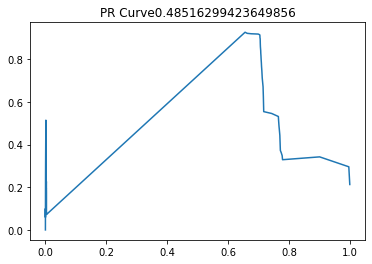

  0%|          | 1/400 [00:01<07:34,  1.14s/it]

Epoch loss :: 85.91796


  0%|          | 2/400 [00:02<07:32,  1.14s/it]

Epoch loss :: 86.00996


  1%|          | 3/400 [00:03<07:34,  1.15s/it]

Epoch loss :: 85.83918


  1%|          | 4/400 [00:04<07:43,  1.17s/it]

Epoch loss :: 85.961426


  1%|▏         | 5/400 [00:05<07:20,  1.12s/it]

Epoch loss :: 85.868065


  2%|▏         | 6/400 [00:06<07:27,  1.13s/it]

Epoch loss :: 86.06934


  2%|▏         | 7/400 [00:08<07:35,  1.16s/it]

Epoch loss :: 86.11404


  2%|▏         | 8/400 [00:09<07:32,  1.15s/it]

Epoch loss :: 86.03662


  2%|▏         | 9/400 [00:10<07:40,  1.18s/it]

Epoch loss :: 85.95237


  2%|▎         | 10/400 [00:11<07:53,  1.21s/it]

Epoch loss :: 85.8945


  3%|▎         | 11/400 [00:12<07:55,  1.22s/it]

Epoch loss :: 85.77182


  3%|▎         | 12/400 [00:14<07:54,  1.22s/it]

Epoch loss :: 86.00677


  3%|▎         | 13/400 [00:15<08:01,  1.24s/it]

Epoch loss :: 86.13415


  4%|▎         | 14/400 [00:16<08:08,  1.27s/it]

Epoch loss :: 85.93432


  4%|▍         | 15/400 [00:17<07:57,  1.24s/it]

Epoch loss :: 85.974754


  4%|▍         | 16/400 [00:19<08:11,  1.28s/it]

Epoch loss :: 85.917946


  4%|▍         | 17/400 [00:20<08:07,  1.27s/it]

Epoch loss :: 85.93494


  4%|▍         | 18/400 [00:21<08:04,  1.27s/it]

Epoch loss :: 86.07193


  5%|▍         | 19/400 [00:23<08:00,  1.26s/it]

Epoch loss :: 85.94506


  5%|▌         | 20/400 [00:24<07:58,  1.26s/it]

Epoch loss :: 85.86673


  5%|▌         | 21/400 [00:25<08:01,  1.27s/it]

Epoch loss :: 85.85691


  6%|▌         | 22/400 [00:26<08:02,  1.28s/it]

Epoch loss :: 85.94924


  6%|▌         | 23/400 [00:28<07:55,  1.26s/it]

Epoch loss :: 85.86172


  6%|▌         | 24/400 [00:29<07:54,  1.26s/it]

Epoch loss :: 85.80847


  6%|▋         | 25/400 [00:30<07:51,  1.26s/it]

Epoch loss :: 85.97965


  6%|▋         | 26/400 [00:32<07:58,  1.28s/it]

Epoch loss :: 85.77831


  7%|▋         | 27/400 [00:33<07:52,  1.27s/it]

Epoch loss :: 85.80833


  7%|▋         | 28/400 [00:34<07:49,  1.26s/it]

Epoch loss :: 86.04948


  7%|▋         | 29/400 [00:35<07:34,  1.22s/it]

Epoch loss :: 85.94906


  8%|▊         | 30/400 [00:36<07:23,  1.20s/it]

Epoch loss :: 86.01157


  8%|▊         | 31/400 [00:38<07:24,  1.20s/it]

Epoch loss :: 85.94592


  8%|▊         | 32/400 [00:39<07:45,  1.26s/it]

Epoch loss :: 85.85474


  8%|▊         | 33/400 [00:40<07:46,  1.27s/it]

Epoch loss :: 85.89059


  8%|▊         | 34/400 [00:42<07:50,  1.29s/it]

Epoch loss :: 85.90515


  9%|▉         | 35/400 [00:43<07:33,  1.24s/it]

Epoch loss :: 85.887665


  9%|▉         | 36/400 [00:44<07:09,  1.18s/it]

Epoch loss :: 85.879845


  9%|▉         | 37/400 [00:45<07:00,  1.16s/it]

Epoch loss :: 85.80833


 10%|▉         | 38/400 [00:46<07:29,  1.24s/it]

Epoch loss :: 85.93186


 10%|▉         | 39/400 [00:47<07:21,  1.22s/it]

Epoch loss :: 86.02651


 10%|█         | 40/400 [00:49<07:14,  1.21s/it]

Epoch loss :: 85.89524


 10%|█         | 41/400 [00:50<07:25,  1.24s/it]

Epoch loss :: 85.889


 10%|█         | 42/400 [00:51<07:18,  1.23s/it]

Epoch loss :: 85.99


 11%|█         | 43/400 [00:53<07:37,  1.28s/it]

Epoch loss :: 85.97581


 11%|█         | 44/400 [00:54<07:41,  1.30s/it]

Epoch loss :: 86.036095


 11%|█▏        | 45/400 [00:55<07:30,  1.27s/it]

Epoch loss :: 85.90326


 12%|█▏        | 46/400 [00:56<07:16,  1.23s/it]

Epoch loss :: 85.90234


 12%|█▏        | 47/400 [00:57<07:03,  1.20s/it]

Epoch loss :: 86.018456


 12%|█▏        | 48/400 [00:59<07:14,  1.23s/it]

Epoch loss :: 86.02273


 12%|█▏        | 49/400 [01:00<07:11,  1.23s/it]

Epoch loss :: 85.96112


 12%|█▎        | 50/400 [01:01<07:01,  1.20s/it]

Epoch loss :: 85.976295


 13%|█▎        | 51/400 [01:02<06:46,  1.16s/it]

Epoch loss :: 85.82513


 13%|█▎        | 52/400 [01:03<06:44,  1.16s/it]

Epoch loss :: 85.779625


 13%|█▎        | 53/400 [01:04<06:51,  1.18s/it]

Epoch loss :: 85.970116


 14%|█▎        | 54/400 [01:06<06:58,  1.21s/it]

Epoch loss :: 85.74708


 14%|█▍        | 55/400 [01:07<07:08,  1.24s/it]

Epoch loss :: 86.06522


 14%|█▍        | 56/400 [01:08<07:08,  1.24s/it]

Epoch loss :: 86.15359


 14%|█▍        | 57/400 [01:09<06:56,  1.21s/it]

Epoch loss :: 85.848015


 14%|█▍        | 58/400 [01:11<06:55,  1.21s/it]

Epoch loss :: 86.028694


 15%|█▍        | 59/400 [01:12<06:56,  1.22s/it]

Epoch loss :: 86.01694


 15%|█▌        | 60/400 [01:13<07:08,  1.26s/it]

Epoch loss :: 85.9759


 15%|█▌        | 61/400 [01:14<07:01,  1.24s/it]

Epoch loss :: 85.991936


 16%|█▌        | 62/400 [01:16<06:58,  1.24s/it]

Epoch loss :: 85.95211


 16%|█▌        | 63/400 [01:17<06:53,  1.23s/it]

Epoch loss :: 85.90543


 16%|█▌        | 64/400 [01:18<06:52,  1.23s/it]

Epoch loss :: 85.93191


 16%|█▋        | 65/400 [01:19<06:43,  1.20s/it]

Epoch loss :: 85.79956


 16%|█▋        | 66/400 [01:20<06:41,  1.20s/it]

Epoch loss :: 85.847496


 17%|█▋        | 67/400 [01:21<06:24,  1.15s/it]

Epoch loss :: 85.82754


 17%|█▋        | 68/400 [01:23<06:26,  1.16s/it]

Epoch loss :: 85.96726


 17%|█▋        | 69/400 [01:24<06:31,  1.18s/it]

Epoch loss :: 85.8941


 18%|█▊        | 70/400 [01:25<06:29,  1.18s/it]

Epoch loss :: 85.88584


 18%|█▊        | 71/400 [01:26<06:27,  1.18s/it]

Epoch loss :: 85.80591


 18%|█▊        | 72/400 [01:28<06:33,  1.20s/it]

Epoch loss :: 85.92129


 18%|█▊        | 73/400 [01:29<06:21,  1.17s/it]

Epoch loss :: 86.068565


 18%|█▊        | 74/400 [01:30<06:04,  1.12s/it]

Epoch loss :: 86.136116


 19%|█▉        | 75/400 [01:31<06:18,  1.17s/it]

Epoch loss :: 85.89557


 19%|█▉        | 76/400 [01:32<06:30,  1.21s/it]

Epoch loss :: 85.954865


 19%|█▉        | 77/400 [01:33<06:38,  1.23s/it]

Epoch loss :: 85.96737


 20%|█▉        | 78/400 [01:35<06:39,  1.24s/it]

Epoch loss :: 85.86578


 20%|█▉        | 79/400 [01:36<06:37,  1.24s/it]

Epoch loss :: 86.01397


 20%|██        | 80/400 [01:37<06:45,  1.27s/it]

Epoch loss :: 85.92489


 20%|██        | 81/400 [01:39<06:47,  1.28s/it]

Epoch loss :: 85.8317


 20%|██        | 82/400 [01:40<06:46,  1.28s/it]

Epoch loss :: 85.951355


 21%|██        | 83/400 [01:41<06:51,  1.30s/it]

Epoch loss :: 85.99876


 21%|██        | 84/400 [01:43<06:50,  1.30s/it]

Epoch loss :: 85.79032


 21%|██▏       | 85/400 [01:44<06:58,  1.33s/it]

Epoch loss :: 85.820946


 22%|██▏       | 86/400 [01:45<06:57,  1.33s/it]

Epoch loss :: 86.01559


 22%|██▏       | 87/400 [01:46<06:40,  1.28s/it]

Epoch loss :: 85.840576


 22%|██▏       | 88/400 [01:47<06:17,  1.21s/it]

Epoch loss :: 85.8883


 22%|██▏       | 89/400 [01:49<06:08,  1.18s/it]

Epoch loss :: 85.9939


 22%|██▎       | 90/400 [01:50<06:25,  1.24s/it]

Epoch loss :: 85.891846


 23%|██▎       | 91/400 [01:51<06:31,  1.27s/it]

Epoch loss :: 85.99072


 23%|██▎       | 92/400 [01:52<06:19,  1.23s/it]

Epoch loss :: 85.88125


 23%|██▎       | 93/400 [01:54<06:15,  1.22s/it]

Epoch loss :: 85.91439


 24%|██▎       | 94/400 [01:55<06:11,  1.21s/it]

Epoch loss :: 85.998405


 24%|██▍       | 95/400 [01:56<06:04,  1.20s/it]

Epoch loss :: 85.97309


 24%|██▍       | 96/400 [01:57<05:57,  1.18s/it]

Epoch loss :: 85.96543


 24%|██▍       | 97/400 [01:58<05:46,  1.14s/it]

Epoch loss :: 86.01099


 24%|██▍       | 98/400 [01:59<05:46,  1.15s/it]

Epoch loss :: 85.83712


 25%|██▍       | 99/400 [02:00<05:40,  1.13s/it]

Epoch loss :: 85.946434


 25%|██▌       | 100/400 [02:02<05:46,  1.16s/it]

Epoch loss :: 86.00421


 25%|██▌       | 101/400 [02:03<05:36,  1.12s/it]

Epoch loss :: 85.89044


 26%|██▌       | 102/400 [02:04<05:31,  1.11s/it]

Epoch loss :: 85.91468


 26%|██▌       | 103/400 [02:05<05:44,  1.16s/it]

Epoch loss :: 86.021324


 26%|██▌       | 104/400 [02:06<05:52,  1.19s/it]

Epoch loss :: 86.1354


 26%|██▋       | 105/400 [02:08<05:55,  1.21s/it]

Epoch loss :: 85.895515


 26%|██▋       | 106/400 [02:09<05:54,  1.21s/it]

Epoch loss :: 86.289


 27%|██▋       | 107/400 [02:10<05:48,  1.19s/it]

Epoch loss :: 85.91024


 27%|██▋       | 108/400 [02:11<05:35,  1.15s/it]

Epoch loss :: 86.037254


 27%|██▋       | 109/400 [02:12<05:31,  1.14s/it]

Epoch loss :: 85.82547


 28%|██▊       | 110/400 [02:13<05:30,  1.14s/it]

Epoch loss :: 85.9299


 28%|██▊       | 111/400 [02:14<05:37,  1.17s/it]

Epoch loss :: 85.91421


 28%|██▊       | 112/400 [02:16<05:48,  1.21s/it]

Epoch loss :: 85.93225


 28%|██▊       | 113/400 [02:17<05:43,  1.20s/it]

Epoch loss :: 85.78413


 28%|██▊       | 114/400 [02:18<05:52,  1.23s/it]

Epoch loss :: 85.92047


 29%|██▉       | 115/400 [02:20<06:04,  1.28s/it]

Epoch loss :: 85.79702


 29%|██▉       | 116/400 [02:21<06:07,  1.29s/it]

Epoch loss :: 85.84098


 29%|██▉       | 117/400 [02:22<06:00,  1.27s/it]

Epoch loss :: 85.91122


 30%|██▉       | 118/400 [02:23<05:44,  1.22s/it]

Epoch loss :: 85.8866


 30%|██▉       | 119/400 [02:25<05:42,  1.22s/it]

Epoch loss :: 85.89978


 30%|███       | 120/400 [02:26<05:36,  1.20s/it]

Epoch loss :: 85.867004


 30%|███       | 121/400 [02:27<05:23,  1.16s/it]

Epoch loss :: 85.884544


 30%|███       | 122/400 [02:28<05:23,  1.16s/it]

Epoch loss :: 85.99908


 31%|███       | 123/400 [02:29<05:25,  1.18s/it]

Epoch loss :: 85.819756


 31%|███       | 124/400 [02:30<05:17,  1.15s/it]

Epoch loss :: 85.9635


 31%|███▏      | 125/400 [02:31<05:14,  1.14s/it]

Epoch loss :: 85.89449


 32%|███▏      | 126/400 [02:33<05:26,  1.19s/it]

Epoch loss :: 85.9021


 32%|███▏      | 127/400 [02:34<05:31,  1.21s/it]

Epoch loss :: 85.90974


 32%|███▏      | 128/400 [02:35<05:37,  1.24s/it]

Epoch loss :: 85.89567


 32%|███▏      | 129/400 [02:36<05:33,  1.23s/it]

Epoch loss :: 86.12406


 32%|███▎      | 130/400 [02:38<05:30,  1.22s/it]

Epoch loss :: 85.913086


 33%|███▎      | 131/400 [02:39<05:17,  1.18s/it]

Epoch loss :: 85.984


 33%|███▎      | 132/400 [02:40<05:20,  1.20s/it]

Epoch loss :: 85.96989


 33%|███▎      | 133/400 [02:41<05:09,  1.16s/it]

Epoch loss :: 85.92743


 34%|███▎      | 134/400 [02:42<04:55,  1.11s/it]

Epoch loss :: 85.89209


 34%|███▍      | 135/400 [02:43<05:00,  1.13s/it]

Epoch loss :: 85.951256


 34%|███▍      | 136/400 [02:44<05:05,  1.16s/it]

Epoch loss :: 85.90766


 34%|███▍      | 137/400 [02:45<04:54,  1.12s/it]

Epoch loss :: 85.87103


 34%|███▍      | 138/400 [02:47<05:01,  1.15s/it]

Epoch loss :: 85.93036


 35%|███▍      | 139/400 [02:48<04:55,  1.13s/it]

Epoch loss :: 85.98376


 35%|███▌      | 140/400 [02:49<04:44,  1.09s/it]

Epoch loss :: 85.864296


 35%|███▌      | 141/400 [02:50<04:38,  1.07s/it]

Epoch loss :: 85.82627


 36%|███▌      | 142/400 [02:51<04:43,  1.10s/it]

Epoch loss :: 85.967415


 36%|███▌      | 143/400 [02:52<04:35,  1.07s/it]

Epoch loss :: 85.91758


 36%|███▌      | 144/400 [02:53<04:36,  1.08s/it]

Epoch loss :: 85.90161


 36%|███▋      | 145/400 [02:54<04:51,  1.14s/it]

Epoch loss :: 85.825905


 36%|███▋      | 146/400 [02:56<04:52,  1.15s/it]

Epoch loss :: 85.99947


 37%|███▋      | 147/400 [02:57<05:04,  1.20s/it]

Epoch loss :: 85.93283


 37%|███▋      | 148/400 [02:58<05:20,  1.27s/it]

Epoch loss :: 85.97227


 37%|███▋      | 149/400 [03:00<05:29,  1.31s/it]

Epoch loss :: 85.87199


 38%|███▊      | 150/400 [03:01<05:27,  1.31s/it]

Epoch loss :: 85.87329


 38%|███▊      | 151/400 [03:02<05:24,  1.30s/it]

Epoch loss :: 86.00379


 38%|███▊      | 152/400 [03:04<05:20,  1.29s/it]

Epoch loss :: 85.90717


 38%|███▊      | 153/400 [03:05<05:24,  1.31s/it]

Epoch loss :: 85.9638


 38%|███▊      | 154/400 [03:06<05:30,  1.34s/it]

Epoch loss :: 85.95243


 39%|███▉      | 155/400 [03:08<05:26,  1.33s/it]

Epoch loss :: 86.095116


 39%|███▉      | 156/400 [03:09<05:31,  1.36s/it]

Epoch loss :: 85.98016


 39%|███▉      | 157/400 [03:10<05:30,  1.36s/it]

Epoch loss :: 85.87952


 40%|███▉      | 158/400 [03:12<05:30,  1.37s/it]

Epoch loss :: 85.88627


 40%|███▉      | 159/400 [03:13<05:25,  1.35s/it]

Epoch loss :: 85.932274


 40%|████      | 160/400 [03:14<05:06,  1.28s/it]

Epoch loss :: 85.93722


 40%|████      | 161/400 [03:15<04:58,  1.25s/it]

Epoch loss :: 85.88053


 40%|████      | 162/400 [03:16<04:39,  1.18s/it]

Epoch loss :: 85.9989


 41%|████      | 163/400 [03:18<04:44,  1.20s/it]

Epoch loss :: 86.01229


 41%|████      | 164/400 [03:19<05:01,  1.28s/it]

Epoch loss :: 85.84736


 41%|████▏     | 165/400 [03:21<05:13,  1.33s/it]

Epoch loss :: 85.942726


 42%|████▏     | 166/400 [03:22<05:20,  1.37s/it]

Epoch loss :: 85.93796


 42%|████▏     | 167/400 [03:23<05:26,  1.40s/it]

Epoch loss :: 85.87158


 42%|████▏     | 168/400 [03:25<05:23,  1.40s/it]

Epoch loss :: 85.94342


 42%|████▏     | 169/400 [03:26<05:06,  1.33s/it]

Epoch loss :: 85.895874


 42%|████▎     | 170/400 [03:27<04:55,  1.28s/it]

Epoch loss :: 85.9999


 43%|████▎     | 171/400 [03:28<04:45,  1.25s/it]

Epoch loss :: 86.01968


 43%|████▎     | 172/400 [03:30<04:37,  1.22s/it]

Epoch loss :: 85.956566


 43%|████▎     | 173/400 [03:31<04:31,  1.20s/it]

Epoch loss :: 86.03223


 44%|████▎     | 174/400 [03:32<04:37,  1.23s/it]

Epoch loss :: 85.89414


 44%|████▍     | 175/400 [03:33<04:35,  1.22s/it]

Epoch loss :: 86.12559


 44%|████▍     | 176/400 [03:35<04:41,  1.26s/it]

Epoch loss :: 86.12292


 44%|████▍     | 177/400 [03:36<04:36,  1.24s/it]

Epoch loss :: 85.87741


 44%|████▍     | 178/400 [03:37<04:34,  1.24s/it]

Epoch loss :: 85.93534


 45%|████▍     | 179/400 [03:38<04:37,  1.26s/it]

Epoch loss :: 85.78361


 45%|████▌     | 180/400 [03:40<04:36,  1.26s/it]

Epoch loss :: 85.8661


 45%|████▌     | 181/400 [03:41<04:37,  1.27s/it]

Epoch loss :: 85.94275


 46%|████▌     | 182/400 [03:42<04:36,  1.27s/it]

Epoch loss :: 86.094185


 46%|████▌     | 183/400 [03:43<04:41,  1.30s/it]

Epoch loss :: 86.01708


 46%|████▌     | 184/400 [03:45<04:40,  1.30s/it]

Epoch loss :: 86.027916


 46%|████▋     | 185/400 [03:46<04:39,  1.30s/it]

Epoch loss :: 85.8597


 46%|████▋     | 186/400 [03:47<04:41,  1.32s/it]

Epoch loss :: 85.836914


 47%|████▋     | 187/400 [03:49<04:37,  1.30s/it]

Epoch loss :: 86.01498


 47%|████▋     | 188/400 [03:50<04:32,  1.28s/it]

Epoch loss :: 85.905174


 47%|████▋     | 189/400 [03:51<04:34,  1.30s/it]

Epoch loss :: 85.9581


 48%|████▊     | 190/400 [03:53<04:30,  1.29s/it]

Epoch loss :: 85.93579


 48%|████▊     | 191/400 [03:54<04:25,  1.27s/it]

Epoch loss :: 85.88383


 48%|████▊     | 192/400 [03:55<04:23,  1.27s/it]

Epoch loss :: 86.06565


 48%|████▊     | 193/400 [03:56<04:13,  1.23s/it]

Epoch loss :: 86.010864


 48%|████▊     | 194/400 [03:57<04:12,  1.23s/it]

Epoch loss :: 85.78945


 49%|████▉     | 195/400 [03:59<04:07,  1.21s/it]

Epoch loss :: 86.0772


 49%|████▉     | 196/400 [04:00<04:05,  1.20s/it]

Epoch loss :: 85.998604


 49%|████▉     | 197/400 [04:01<03:49,  1.13s/it]

Epoch loss :: 86.0342


 50%|████▉     | 198/400 [04:02<03:51,  1.14s/it]

Epoch loss :: 86.04424


 50%|████▉     | 199/400 [04:03<03:49,  1.14s/it]

Epoch loss :: 85.836876


 50%|█████     | 200/400 [04:04<03:45,  1.13s/it]

Epoch loss :: 85.84723


 50%|█████     | 201/400 [04:05<03:52,  1.17s/it]

Epoch loss :: 85.87772


 50%|█████     | 202/400 [04:07<03:55,  1.19s/it]

Epoch loss :: 85.9128


 51%|█████     | 203/400 [04:08<03:45,  1.15s/it]

Epoch loss :: 85.95731


 51%|█████     | 204/400 [04:09<03:46,  1.15s/it]

Epoch loss :: 85.907776


 51%|█████▏    | 205/400 [04:10<03:54,  1.20s/it]

Epoch loss :: 85.92527


 52%|█████▏    | 206/400 [04:11<03:47,  1.17s/it]

Epoch loss :: 85.86631


 52%|█████▏    | 207/400 [04:12<03:51,  1.20s/it]

Epoch loss :: 85.96015


 52%|█████▏    | 208/400 [04:14<03:55,  1.23s/it]

Epoch loss :: 85.84432


 52%|█████▏    | 209/400 [04:15<03:53,  1.22s/it]

Epoch loss :: 85.89847


 52%|█████▎    | 210/400 [04:16<03:57,  1.25s/it]

Epoch loss :: 85.874306


 53%|█████▎    | 211/400 [04:17<03:46,  1.20s/it]

Epoch loss :: 85.888405


 53%|█████▎    | 212/400 [04:19<03:41,  1.18s/it]

Epoch loss :: 85.97434


 53%|█████▎    | 213/400 [04:20<03:34,  1.15s/it]

Epoch loss :: 85.88456


 54%|█████▎    | 214/400 [04:21<03:27,  1.12s/it]

Epoch loss :: 85.9387


 54%|█████▍    | 215/400 [04:22<03:34,  1.16s/it]

Epoch loss :: 86.10732


 54%|█████▍    | 216/400 [04:23<03:41,  1.20s/it]

Epoch loss :: 85.96726


 54%|█████▍    | 217/400 [04:24<03:44,  1.22s/it]

Epoch loss :: 85.81608


 55%|█████▍    | 218/400 [04:26<03:52,  1.28s/it]

Epoch loss :: 85.88977


 55%|█████▍    | 219/400 [04:27<03:51,  1.28s/it]

Epoch loss :: 85.97646


 55%|█████▌    | 220/400 [04:28<03:49,  1.27s/it]

Epoch loss :: 85.90985


 55%|█████▌    | 221/400 [04:29<03:33,  1.19s/it]

Epoch loss :: 85.875824


 56%|█████▌    | 222/400 [04:30<03:20,  1.13s/it]

Epoch loss :: 85.82776


 56%|█████▌    | 223/400 [04:32<03:26,  1.17s/it]

Epoch loss :: 85.89384


 56%|█████▌    | 224/400 [04:33<03:28,  1.19s/it]

Epoch loss :: 85.81692


 56%|█████▋    | 225/400 [04:34<03:30,  1.20s/it]

Epoch loss :: 85.884705


 56%|█████▋    | 226/400 [04:35<03:22,  1.17s/it]

Epoch loss :: 85.923096


 57%|█████▋    | 227/400 [04:36<03:22,  1.17s/it]

Epoch loss :: 86.024086


 57%|█████▋    | 228/400 [04:38<03:30,  1.23s/it]

Epoch loss :: 85.9234


 57%|█████▋    | 229/400 [04:39<03:37,  1.27s/it]

Epoch loss :: 85.84844


In [ ]:
from sklearn.model_selection import train_test_split

F1_list = []
AUC_list = []
num_runs = 20
for i in range(num_runs):
    train_X,test_X = train_test_split(all_data,test_size = 0.5)
    anom = anom_data.sample(n = int (0.25 * len(test_X)))
    test_X = test_X.values
    train_X = train_X.values
    anom_X = anom.values

    dagmm_obj = DaGMM(
        DEVICE,
        encoder_structure_config,
        decoder_structure_config,
        n_gmm=gmm_structure_config['num_components'],
        ae_latent_dim=1,

    )
    dagmm_obj = dagmm_obj.to(DEVICE)

    dagmm_obj = train(
        dagmm_obj,
        train_X,
        num_epochs=400,
        batch_size=1024, 
        LR=0.0001
    )

    F1, auc = test(
        dagmm_obj,
        train_X,
        test_X,
        anom_X
    )
    F1_list.append(F1)
    AUC_list.append(auc)

In [65]:
anom_X.shape

(12159, 117)

  0%|          | 1/400 [00:02<14:29,  2.18s/it]

Epoch loss :: 164.64948


  0%|          | 2/400 [00:04<14:36,  2.20s/it]

Epoch loss :: 164.52959


  1%|          | 3/400 [00:06<14:30,  2.19s/it]

Epoch loss :: 164.982


  1%|          | 4/400 [00:08<14:34,  2.21s/it]

Epoch loss :: 164.63568


  1%|▏         | 5/400 [00:11<14:34,  2.21s/it]

Epoch loss :: 165.31407


  2%|▏         | 6/400 [00:13<14:37,  2.23s/it]

Epoch loss :: 165.17566


  2%|▏         | 7/400 [00:15<13:49,  2.11s/it]

Epoch loss :: 164.70465


  2%|▏         | 8/400 [00:16<12:35,  1.93s/it]

Epoch loss :: 164.68265


  2%|▏         | 9/400 [00:18<12:09,  1.87s/it]

Epoch loss :: 165.15076


  2%|▎         | 10/400 [00:20<12:43,  1.96s/it]

Epoch loss :: 165.28175


  3%|▎         | 11/400 [00:22<12:52,  1.99s/it]

Epoch loss :: 165.4966


  3%|▎         | 12/400 [00:24<13:21,  2.06s/it]

Epoch loss :: 165.02428


  3%|▎         | 13/400 [00:27<13:55,  2.16s/it]

Epoch loss :: 164.60846


  4%|▎         | 14/400 [00:29<13:20,  2.07s/it]

Epoch loss :: 164.60872


  4%|▍         | 15/400 [00:31<13:57,  2.17s/it]

Epoch loss :: 164.76689


  4%|▍         | 16/400 [00:33<13:53,  2.17s/it]

Epoch loss :: 165.31854


  4%|▍         | 17/400 [00:36<14:22,  2.25s/it]

Epoch loss :: 164.50395


  4%|▍         | 18/400 [00:37<12:31,  1.97s/it]

Epoch loss :: 164.58531


  5%|▍         | 19/400 [00:39<12:46,  2.01s/it]

Epoch loss :: 165.00954


  5%|▌         | 20/400 [00:41<12:45,  2.01s/it]

Epoch loss :: 165.24158


  5%|▌         | 21/400 [00:43<13:00,  2.06s/it]

Epoch loss :: 164.66016


  6%|▌         | 22/400 [00:44<11:21,  1.80s/it]

Epoch loss :: 164.73674


  6%|▌         | 23/400 [00:47<11:59,  1.91s/it]

Epoch loss :: 165.12195


  6%|▌         | 24/400 [00:49<12:31,  2.00s/it]

Epoch loss :: 164.78621


  6%|▋         | 25/400 [00:51<12:09,  1.95s/it]

Epoch loss :: 165.11073


  6%|▋         | 26/400 [00:53<12:04,  1.94s/it]

Epoch loss :: 164.77063


  7%|▋         | 27/400 [00:55<12:29,  2.01s/it]

Epoch loss :: 164.5284


  7%|▋         | 28/400 [00:57<12:37,  2.04s/it]

Epoch loss :: 164.6668


  7%|▋         | 29/400 [00:59<12:59,  2.10s/it]

Epoch loss :: 164.88611


  8%|▊         | 30/400 [01:01<13:07,  2.13s/it]

Epoch loss :: 164.66383


  8%|▊         | 31/400 [01:03<13:11,  2.15s/it]

Epoch loss :: 164.81781


  8%|▊         | 32/400 [01:06<13:14,  2.16s/it]

Epoch loss :: 164.97496


  8%|▊         | 33/400 [01:08<13:34,  2.22s/it]

Epoch loss :: 164.7157


  8%|▊         | 34/400 [01:10<13:21,  2.19s/it]

Epoch loss :: 164.96422


  9%|▉         | 35/400 [01:11<11:18,  1.86s/it]

Epoch loss :: 164.93951


  9%|▉         | 36/400 [01:13<11:26,  1.88s/it]

Epoch loss :: 164.90411


  9%|▉         | 37/400 [01:15<12:02,  1.99s/it]

Epoch loss :: 164.93404


 10%|▉         | 38/400 [01:18<12:17,  2.04s/it]

Epoch loss :: 164.76694


 10%|▉         | 39/400 [01:20<12:30,  2.08s/it]

Epoch loss :: 164.9724


 10%|█         | 40/400 [01:22<12:45,  2.13s/it]

Epoch loss :: 164.56293


 10%|█         | 41/400 [01:24<12:40,  2.12s/it]

Epoch loss :: 164.76575


 10%|█         | 42/400 [01:26<12:24,  2.08s/it]

Epoch loss :: 164.89827


 11%|█         | 43/400 [01:28<12:44,  2.14s/it]

Epoch loss :: 164.56831


 11%|█         | 44/400 [01:31<12:52,  2.17s/it]

Epoch loss :: 164.72054


 11%|█▏        | 45/400 [01:33<12:53,  2.18s/it]

Epoch loss :: 164.79811


 12%|█▏        | 46/400 [01:35<13:07,  2.22s/it]

Epoch loss :: 164.89401


 12%|█▏        | 47/400 [01:37<12:46,  2.17s/it]

Epoch loss :: 165.05507


 12%|█▏        | 48/400 [01:39<12:46,  2.18s/it]

Epoch loss :: 165.01192


 12%|█▏        | 49/400 [01:42<12:55,  2.21s/it]

Epoch loss :: 165.18526


 12%|█▎        | 50/400 [01:44<12:43,  2.18s/it]

Epoch loss :: 164.97179


 13%|█▎        | 51/400 [01:46<12:49,  2.21s/it]

Epoch loss :: 164.8654


 13%|█▎        | 52/400 [01:48<13:05,  2.26s/it]

Epoch loss :: 164.8681


 13%|█▎        | 53/400 [01:51<12:56,  2.24s/it]

Epoch loss :: 164.59119


 14%|█▎        | 54/400 [01:53<12:30,  2.17s/it]

Epoch loss :: 164.90822


 14%|█▍        | 55/400 [01:55<12:42,  2.21s/it]

Epoch loss :: 164.78079


 14%|█▍        | 56/400 [01:57<12:39,  2.21s/it]

Epoch loss :: 164.63991


 14%|█▍        | 57/400 [01:59<12:57,  2.27s/it]

Epoch loss :: 164.7014


 14%|█▍        | 58/400 [02:02<13:11,  2.32s/it]

Epoch loss :: 164.89256


 15%|█▍        | 59/400 [02:04<13:05,  2.30s/it]

Epoch loss :: 164.66429


 15%|█▌        | 60/400 [02:06<12:28,  2.20s/it]

Epoch loss :: 164.74922


 15%|█▌        | 61/400 [02:08<11:56,  2.11s/it]

Epoch loss :: 164.73882


 16%|█▌        | 62/400 [02:10<12:02,  2.14s/it]

Epoch loss :: 164.81187


 16%|█▌        | 63/400 [02:12<12:04,  2.15s/it]

Epoch loss :: 164.50887


 16%|█▌        | 64/400 [02:15<12:10,  2.17s/it]

Epoch loss :: 164.93428


 16%|█▋        | 65/400 [02:17<12:25,  2.22s/it]

Epoch loss :: 164.93547


 16%|█▋        | 66/400 [02:19<12:20,  2.22s/it]

Epoch loss :: 164.77922


 17%|█▋        | 67/400 [02:21<11:25,  2.06s/it]

Epoch loss :: 164.54565


 17%|█▋        | 68/400 [02:23<11:43,  2.12s/it]

Epoch loss :: 164.63885


 17%|█▋        | 69/400 [02:26<12:06,  2.19s/it]

Epoch loss :: 164.73573


 18%|█▊        | 70/400 [02:28<12:03,  2.19s/it]

Epoch loss :: 165.10643


 18%|█▊        | 71/400 [02:30<12:04,  2.20s/it]

Epoch loss :: 165.13478


 18%|█▊        | 72/400 [02:32<12:06,  2.21s/it]

Epoch loss :: 164.89238


 18%|█▊        | 73/400 [02:34<11:47,  2.16s/it]

Epoch loss :: 164.61882


 18%|█▊        | 74/400 [02:36<11:43,  2.16s/it]

Epoch loss :: 164.95781


 19%|█▉        | 75/400 [02:39<12:04,  2.23s/it]

Epoch loss :: 164.90857


 19%|█▉        | 76/400 [02:41<11:49,  2.19s/it]

Epoch loss :: 164.51022


 19%|█▉        | 77/400 [02:43<11:54,  2.21s/it]

Epoch loss :: 165.3477


 20%|█▉        | 78/400 [02:46<12:12,  2.28s/it]

Epoch loss :: 164.5302


 20%|█▉        | 79/400 [02:48<11:56,  2.23s/it]

Epoch loss :: 164.82555


 20%|██        | 80/400 [02:50<12:05,  2.27s/it]

Epoch loss :: 165.02623


 20%|██        | 81/400 [02:52<12:07,  2.28s/it]

Epoch loss :: 164.98006


 20%|██        | 82/400 [02:55<12:04,  2.28s/it]

Epoch loss :: 165.21544


 21%|██        | 83/400 [02:57<11:51,  2.25s/it]

Epoch loss :: 164.85933


 21%|██        | 84/400 [02:59<11:45,  2.23s/it]

Epoch loss :: 164.64342


 21%|██▏       | 85/400 [03:01<11:32,  2.20s/it]

Epoch loss :: 164.84155


 22%|██▏       | 86/400 [03:03<11:29,  2.20s/it]

Epoch loss :: 165.21626


 22%|██▏       | 87/400 [03:06<11:41,  2.24s/it]

Epoch loss :: 164.55695


 22%|██▏       | 88/400 [03:08<11:29,  2.21s/it]

Epoch loss :: 164.7504


 22%|██▏       | 89/400 [03:10<11:18,  2.18s/it]

Epoch loss :: 164.99394


 22%|██▎       | 90/400 [03:12<11:21,  2.20s/it]

Epoch loss :: 164.50659


 23%|██▎       | 91/400 [03:14<11:25,  2.22s/it]

Epoch loss :: 165.21744


 23%|██▎       | 92/400 [03:17<11:24,  2.22s/it]

Epoch loss :: 164.39043


 23%|██▎       | 93/400 [03:19<11:12,  2.19s/it]

Epoch loss :: 164.7017


 24%|██▎       | 94/400 [03:21<10:59,  2.15s/it]

Epoch loss :: 164.95343


 24%|██▍       | 95/400 [03:23<10:55,  2.15s/it]

Epoch loss :: 164.72383


 24%|██▍       | 96/400 [03:25<10:55,  2.16s/it]

Epoch loss :: 164.93816


 24%|██▍       | 97/400 [03:27<10:40,  2.11s/it]

Epoch loss :: 165.11082


 24%|██▍       | 98/400 [03:29<10:40,  2.12s/it]

Epoch loss :: 164.45


 25%|██▍       | 99/400 [03:32<10:54,  2.17s/it]

Epoch loss :: 164.89142


 25%|██▌       | 100/400 [03:34<10:52,  2.17s/it]

Epoch loss :: 164.65898


 25%|██▌       | 101/400 [03:36<11:05,  2.22s/it]

Epoch loss :: 165.02814


 26%|██▌       | 102/400 [03:38<11:17,  2.27s/it]

Epoch loss :: 164.70367


 26%|██▌       | 103/400 [03:41<11:09,  2.25s/it]

Epoch loss :: 164.99908


 26%|██▌       | 104/400 [03:43<10:45,  2.18s/it]

Epoch loss :: 165.13702


 26%|██▋       | 105/400 [03:44<09:55,  2.02s/it]

Epoch loss :: 165.12401


 26%|██▋       | 106/400 [03:47<10:14,  2.09s/it]

Epoch loss :: 164.93004


 27%|██▋       | 107/400 [03:49<10:17,  2.11s/it]

Epoch loss :: 164.66345


 27%|██▋       | 108/400 [03:51<09:53,  2.03s/it]

Epoch loss :: 165.09407


 27%|██▋       | 109/400 [03:53<09:43,  2.00s/it]

Epoch loss :: 164.74768


 28%|██▊       | 110/400 [03:55<09:49,  2.03s/it]

Epoch loss :: 164.93956


 28%|██▊       | 111/400 [03:57<09:49,  2.04s/it]

Epoch loss :: 164.71532


 28%|██▊       | 112/400 [03:59<09:41,  2.02s/it]

Epoch loss :: 164.9937


 28%|██▊       | 113/400 [04:00<09:12,  1.92s/it]

Epoch loss :: 165.00984


 28%|██▊       | 114/400 [04:02<09:10,  1.92s/it]

Epoch loss :: 164.71538


 29%|██▉       | 115/400 [04:04<09:28,  2.00s/it]

Epoch loss :: 164.72762


 29%|██▉       | 116/400 [04:07<09:42,  2.05s/it]

Epoch loss :: 164.90387


 29%|██▉       | 117/400 [04:09<09:40,  2.05s/it]

Epoch loss :: 164.59068


 30%|██▉       | 118/400 [04:11<10:01,  2.13s/it]

Epoch loss :: 164.89264


 30%|██▉       | 119/400 [04:13<09:56,  2.12s/it]

Epoch loss :: 164.77924


 30%|███       | 120/400 [04:15<09:44,  2.09s/it]

Epoch loss :: 164.85695


 30%|███       | 121/400 [04:17<09:48,  2.11s/it]

Epoch loss :: 164.9702


 30%|███       | 122/400 [04:19<09:28,  2.04s/it]

Epoch loss :: 164.79652


 31%|███       | 123/400 [04:21<09:25,  2.04s/it]

Epoch loss :: 164.61186


 31%|███       | 124/400 [04:23<09:29,  2.06s/it]

Epoch loss :: 165.3835


 31%|███▏      | 125/400 [04:25<09:17,  2.03s/it]

Epoch loss :: 165.01318


 32%|███▏      | 126/400 [04:27<09:18,  2.04s/it]

Epoch loss :: 164.70845


 32%|███▏      | 127/400 [04:29<09:19,  2.05s/it]

Epoch loss :: 164.6102


 32%|███▏      | 128/400 [04:32<09:31,  2.10s/it]

Epoch loss :: 165.07687


 32%|███▏      | 129/400 [04:33<08:42,  1.93s/it]

Epoch loss :: 164.76033


 32%|███▎      | 130/400 [04:35<09:08,  2.03s/it]

Epoch loss :: 164.86272


 33%|███▎      | 131/400 [04:38<09:26,  2.11s/it]

Epoch loss :: 164.77696


 33%|███▎      | 132/400 [04:40<09:39,  2.16s/it]

Epoch loss :: 164.84808


 33%|███▎      | 133/400 [04:42<09:37,  2.16s/it]

Epoch loss :: 164.99945


 34%|███▎      | 134/400 [04:44<09:18,  2.10s/it]

Epoch loss :: 164.74254


 34%|███▍      | 135/400 [04:46<09:09,  2.08s/it]

Epoch loss :: 165.00406


 34%|███▍      | 136/400 [04:48<09:25,  2.14s/it]

Epoch loss :: 165.04617


 34%|███▍      | 137/400 [04:51<09:22,  2.14s/it]

Epoch loss :: 164.75426


 34%|███▍      | 138/400 [04:53<09:19,  2.13s/it]

Epoch loss :: 164.88747


 35%|███▍      | 139/400 [04:55<09:26,  2.17s/it]

Epoch loss :: 165.01134


 35%|███▌      | 140/400 [04:57<09:30,  2.20s/it]

Epoch loss :: 164.95103


 35%|███▌      | 141/400 [04:59<09:25,  2.18s/it]

Epoch loss :: 165.00764


 36%|███▌      | 142/400 [05:01<09:10,  2.13s/it]

Epoch loss :: 164.91093


 36%|███▌      | 143/400 [05:04<09:18,  2.17s/it]

Epoch loss :: 164.61046


 36%|███▌      | 144/400 [05:06<09:18,  2.18s/it]

Epoch loss :: 164.83632


 36%|███▋      | 145/400 [05:08<09:22,  2.21s/it]

Epoch loss :: 165.15062


 36%|███▋      | 146/400 [05:10<08:55,  2.11s/it]

Epoch loss :: 164.87144


 37%|███▋      | 147/400 [05:12<08:32,  2.03s/it]

Epoch loss :: 165.06622


 37%|███▋      | 148/400 [05:13<07:32,  1.80s/it]

Epoch loss :: 164.58522


 37%|███▋      | 149/400 [05:15<07:37,  1.82s/it]

Epoch loss :: 164.89153


 38%|███▊      | 150/400 [05:17<07:58,  1.91s/it]

Epoch loss :: 164.78941


 38%|███▊      | 151/400 [05:19<08:34,  2.07s/it]

Epoch loss :: 164.69278


 38%|███▊      | 152/400 [05:22<08:50,  2.14s/it]

Epoch loss :: 164.85896


 38%|███▊      | 153/400 [05:24<08:47,  2.13s/it]

Epoch loss :: 164.96014


 38%|███▊      | 154/400 [05:26<09:06,  2.22s/it]

Epoch loss :: 164.69795


 39%|███▉      | 155/400 [05:29<09:12,  2.25s/it]

Epoch loss :: 165.19841


 39%|███▉      | 156/400 [05:31<08:59,  2.21s/it]

Epoch loss :: 164.65004


 39%|███▉      | 157/400 [05:33<08:50,  2.18s/it]

Epoch loss :: 164.7658


 40%|███▉      | 158/400 [05:35<08:55,  2.21s/it]

Epoch loss :: 164.81459


 40%|███▉      | 159/400 [05:37<08:44,  2.18s/it]

Epoch loss :: 164.62807


 40%|████      | 160/400 [05:39<08:42,  2.18s/it]

Epoch loss :: 164.85242


 40%|████      | 161/400 [05:42<08:37,  2.16s/it]

Epoch loss :: 164.55164


 40%|████      | 162/400 [05:44<08:28,  2.14s/it]

Epoch loss :: 165.32066


 41%|████      | 163/400 [05:46<08:37,  2.19s/it]

Epoch loss :: 164.54665


 41%|████      | 164/400 [05:48<08:26,  2.15s/it]

Epoch loss :: 164.76488


 41%|████▏     | 165/400 [05:50<08:17,  2.12s/it]

Epoch loss :: 164.80727


 42%|████▏     | 166/400 [05:52<08:12,  2.10s/it]

Epoch loss :: 164.47148


 42%|████▏     | 167/400 [05:54<08:07,  2.09s/it]

Epoch loss :: 164.91759


 42%|████▏     | 168/400 [05:57<08:25,  2.18s/it]

Epoch loss :: 165.12242


 42%|████▏     | 169/400 [05:59<08:22,  2.17s/it]

Epoch loss :: 164.8679


 42%|████▎     | 170/400 [06:01<08:04,  2.11s/it]

Epoch loss :: 164.62428


 43%|████▎     | 171/400 [06:03<08:30,  2.23s/it]

Epoch loss :: 165.39244


 43%|████▎     | 172/400 [06:05<08:26,  2.22s/it]

Epoch loss :: 164.98839


 43%|████▎     | 173/400 [06:08<08:18,  2.20s/it]

Epoch loss :: 164.61737


 44%|████▎     | 174/400 [06:10<08:19,  2.21s/it]

Epoch loss :: 165.09839


 44%|████▍     | 175/400 [06:12<08:19,  2.22s/it]

Epoch loss :: 165.16924


 44%|████▍     | 176/400 [06:14<07:47,  2.09s/it]

Epoch loss :: 164.84361


 44%|████▍     | 177/400 [06:16<07:38,  2.05s/it]

Epoch loss :: 164.75081


 44%|████▍     | 178/400 [06:18<07:51,  2.12s/it]

Epoch loss :: 164.59326


 45%|████▍     | 179/400 [06:20<07:48,  2.12s/it]

Epoch loss :: 164.77196


 45%|████▌     | 180/400 [06:22<07:41,  2.10s/it]

Epoch loss :: 165.23741


 45%|████▌     | 181/400 [06:25<07:55,  2.17s/it]

Epoch loss :: 164.56483


 46%|████▌     | 182/400 [06:27<07:55,  2.18s/it]

Epoch loss :: 164.60567


 46%|████▌     | 183/400 [06:29<07:47,  2.16s/it]

Epoch loss :: 164.85779


 46%|████▌     | 184/400 [06:31<07:49,  2.17s/it]

Epoch loss :: 165.1269


 46%|████▋     | 185/400 [06:33<07:53,  2.20s/it]

Epoch loss :: 164.79523


 46%|████▋     | 186/400 [06:35<07:41,  2.16s/it]

Epoch loss :: 164.57256


 47%|████▋     | 187/400 [06:37<07:34,  2.13s/it]

Epoch loss :: 164.90114


 47%|████▋     | 188/400 [06:39<07:05,  2.01s/it]

Epoch loss :: 165.10187


 47%|████▋     | 189/400 [06:42<07:21,  2.09s/it]

Epoch loss :: 164.82869


 48%|████▊     | 190/400 [06:44<07:25,  2.12s/it]

Epoch loss :: 165.038


 48%|████▊     | 191/400 [06:46<07:17,  2.09s/it]

Epoch loss :: 164.51527


 48%|████▊     | 192/400 [06:48<07:14,  2.09s/it]

Epoch loss :: 165.33261


 48%|████▊     | 193/400 [06:50<07:15,  2.11s/it]

Epoch loss :: 164.79424


 48%|████▊     | 194/400 [06:52<07:11,  2.10s/it]

Epoch loss :: 165.18277


 49%|████▉     | 195/400 [06:54<07:15,  2.12s/it]

Epoch loss :: 164.61583


 49%|████▉     | 196/400 [06:56<06:59,  2.06s/it]

Epoch loss :: 164.97176


 49%|████▉     | 197/400 [06:58<06:50,  2.02s/it]

Epoch loss :: 164.75356


 50%|████▉     | 198/400 [07:00<06:50,  2.03s/it]

Epoch loss :: 164.89658


 50%|████▉     | 199/400 [07:02<06:53,  2.06s/it]

Epoch loss :: 164.55823


 50%|█████     | 200/400 [07:04<07:04,  2.12s/it]

Epoch loss :: 164.7436


 50%|█████     | 201/400 [07:06<06:55,  2.09s/it]

Epoch loss :: 164.95947


 50%|█████     | 202/400 [07:09<06:56,  2.10s/it]

Epoch loss :: 164.74245


 51%|█████     | 203/400 [07:11<06:57,  2.12s/it]

Epoch loss :: 164.95305


 51%|█████     | 204/400 [07:13<07:08,  2.19s/it]

Epoch loss :: 164.96745


 51%|█████▏    | 205/400 [07:15<07:03,  2.17s/it]

Epoch loss :: 164.69228


 52%|█████▏    | 206/400 [07:17<06:56,  2.15s/it]

Epoch loss :: 164.69513


 52%|█████▏    | 207/400 [07:20<07:07,  2.22s/it]

Epoch loss :: 164.66745


 52%|█████▏    | 208/400 [07:22<06:52,  2.15s/it]

Epoch loss :: 164.60187


 52%|█████▏    | 209/400 [07:24<06:44,  2.12s/it]

Epoch loss :: 164.88104


 52%|█████▎    | 210/400 [07:26<06:49,  2.15s/it]

Epoch loss :: 164.77116


 53%|█████▎    | 211/400 [07:28<06:54,  2.20s/it]

Epoch loss :: 164.62772


 53%|█████▎    | 212/400 [07:30<06:46,  2.16s/it]

Epoch loss :: 164.81004


 53%|█████▎    | 213/400 [07:33<06:51,  2.20s/it]

Epoch loss :: 164.71494


 54%|█████▎    | 214/400 [07:35<06:53,  2.22s/it]

Epoch loss :: 164.8441


 54%|█████▍    | 215/400 [07:37<06:36,  2.14s/it]

Epoch loss :: 164.66039


 54%|█████▍    | 216/400 [07:39<06:32,  2.13s/it]

Epoch loss :: 164.65518


 54%|█████▍    | 217/400 [07:41<06:39,  2.18s/it]

Epoch loss :: 165.04353


 55%|█████▍    | 218/400 [07:43<06:27,  2.13s/it]

Epoch loss :: 165.02483


 55%|█████▍    | 219/400 [07:45<06:27,  2.14s/it]

Epoch loss :: 165.05675


 55%|█████▌    | 220/400 [07:48<06:24,  2.14s/it]

Epoch loss :: 164.67801


 55%|█████▌    | 221/400 [07:50<06:19,  2.12s/it]

Epoch loss :: 164.88094


 56%|█████▌    | 222/400 [07:52<06:23,  2.16s/it]

Epoch loss :: 164.70622


 56%|█████▌    | 223/400 [07:54<06:13,  2.11s/it]

Epoch loss :: 164.81334


 56%|█████▌    | 224/400 [07:56<06:04,  2.07s/it]

Epoch loss :: 164.75002


 56%|█████▋    | 225/400 [07:58<06:06,  2.09s/it]

Epoch loss :: 164.85262


 56%|█████▋    | 226/400 [08:00<06:01,  2.08s/it]

Epoch loss :: 164.92717


 57%|█████▋    | 227/400 [08:02<05:50,  2.02s/it]

Epoch loss :: 164.89845


 57%|█████▋    | 228/400 [08:04<05:36,  1.96s/it]

Epoch loss :: 164.54773


 57%|█████▋    | 229/400 [08:06<05:31,  1.94s/it]

Epoch loss :: 164.89981


 57%|█████▊    | 230/400 [08:08<05:26,  1.92s/it]

Epoch loss :: 164.69551


 58%|█████▊    | 231/400 [08:10<05:26,  1.93s/it]

Epoch loss :: 164.85947


 58%|█████▊    | 232/400 [08:12<05:46,  2.06s/it]

Epoch loss :: 164.69722


 58%|█████▊    | 233/400 [08:14<05:52,  2.11s/it]

Epoch loss :: 164.97935


 58%|█████▊    | 234/400 [08:16<05:49,  2.10s/it]

Epoch loss :: 165.27101


 59%|█████▉    | 235/400 [08:18<05:45,  2.09s/it]

Epoch loss :: 164.42773


 59%|█████▉    | 236/400 [08:20<05:40,  2.08s/it]

Epoch loss :: 165.11314


 59%|█████▉    | 237/400 [08:22<05:38,  2.08s/it]

Epoch loss :: 164.84064


 60%|█████▉    | 238/400 [08:25<05:50,  2.16s/it]

Epoch loss :: 164.63261


 60%|█████▉    | 239/400 [08:27<05:45,  2.14s/it]

Epoch loss :: 164.89671


 60%|██████    | 240/400 [08:29<05:37,  2.11s/it]

Epoch loss :: 165.07188


 60%|██████    | 241/400 [08:31<05:35,  2.11s/it]

Epoch loss :: 165.30809


 60%|██████    | 242/400 [08:33<05:40,  2.15s/it]

Epoch loss :: 165.20605


 61%|██████    | 243/400 [08:35<05:33,  2.12s/it]

Epoch loss :: 164.69458


 61%|██████    | 244/400 [08:38<05:37,  2.16s/it]

Epoch loss :: 164.9947


 61%|██████▏   | 245/400 [08:40<05:29,  2.13s/it]

Epoch loss :: 165.12172


 62%|██████▏   | 246/400 [08:42<05:23,  2.10s/it]

Epoch loss :: 164.692


 62%|██████▏   | 247/400 [08:44<05:15,  2.06s/it]

Epoch loss :: 164.92433


 62%|██████▏   | 248/400 [08:46<05:17,  2.09s/it]

Epoch loss :: 165.11784


 62%|██████▏   | 249/400 [08:48<05:28,  2.17s/it]

Epoch loss :: 164.95668


 62%|██████▎   | 250/400 [08:50<05:24,  2.16s/it]

Epoch loss :: 164.77911


 63%|██████▎   | 251/400 [08:52<05:24,  2.18s/it]

Epoch loss :: 164.72449


 63%|██████▎   | 252/400 [08:55<05:20,  2.17s/it]

Epoch loss :: 164.6475


 63%|██████▎   | 253/400 [08:57<05:17,  2.16s/it]

Epoch loss :: 164.79335


 64%|██████▎   | 254/400 [08:59<05:19,  2.19s/it]

Epoch loss :: 165.06511


 64%|██████▍   | 255/400 [09:01<05:18,  2.19s/it]

Epoch loss :: 165.201


 64%|██████▍   | 256/400 [09:03<05:13,  2.18s/it]

Epoch loss :: 165.16862


 64%|██████▍   | 257/400 [09:06<05:09,  2.16s/it]

Epoch loss :: 164.78294


 64%|██████▍   | 258/400 [09:08<05:18,  2.24s/it]

Epoch loss :: 164.75536


 65%|██████▍   | 259/400 [09:09<04:41,  2.00s/it]

Epoch loss :: 164.82439


 65%|██████▌   | 260/400 [09:11<04:33,  1.96s/it]

Epoch loss :: 164.80284


 65%|██████▌   | 261/400 [09:13<04:33,  1.97s/it]

Epoch loss :: 164.76659


 66%|██████▌   | 262/400 [09:15<04:35,  2.00s/it]

Epoch loss :: 165.1486


 66%|██████▌   | 263/400 [09:18<04:42,  2.07s/it]

Epoch loss :: 164.73329


 66%|██████▌   | 264/400 [09:20<04:45,  2.10s/it]

Epoch loss :: 164.56995


 66%|██████▋   | 265/400 [09:22<04:32,  2.02s/it]

Epoch loss :: 164.88484


 66%|██████▋   | 266/400 [09:24<04:35,  2.06s/it]

Epoch loss :: 165.06863


 67%|██████▋   | 267/400 [09:26<04:32,  2.05s/it]

Epoch loss :: 164.41643


 67%|██████▋   | 268/400 [09:28<04:36,  2.09s/it]

Epoch loss :: 164.66725


 67%|██████▋   | 269/400 [09:30<04:25,  2.03s/it]

Epoch loss :: 164.6913


 68%|██████▊   | 270/400 [09:32<04:29,  2.07s/it]

Epoch loss :: 165.1176


 68%|██████▊   | 271/400 [09:34<04:33,  2.12s/it]

Epoch loss :: 164.8279


 68%|██████▊   | 272/400 [09:36<04:33,  2.14s/it]

Epoch loss :: 164.68596


 68%|██████▊   | 273/400 [09:39<04:36,  2.17s/it]

Epoch loss :: 165.23418


 68%|██████▊   | 274/400 [09:41<04:38,  2.21s/it]

Epoch loss :: 165.04085


 69%|██████▉   | 275/400 [09:43<04:18,  2.07s/it]

Epoch loss :: 165.34479


 69%|██████▉   | 276/400 [09:45<04:15,  2.06s/it]

Epoch loss :: 164.78021


 69%|██████▉   | 277/400 [09:47<04:13,  2.06s/it]

Epoch loss :: 164.8968


 70%|██████▉   | 278/400 [09:49<04:18,  2.12s/it]

Epoch loss :: 164.58098


 70%|██████▉   | 279/400 [09:51<04:25,  2.20s/it]

Epoch loss :: 164.57292


 70%|███████   | 280/400 [09:54<04:22,  2.18s/it]

Epoch loss :: 165.27756


 70%|███████   | 281/400 [09:56<04:20,  2.19s/it]

Epoch loss :: 164.61256


 70%|███████   | 282/400 [09:58<04:16,  2.17s/it]

Epoch loss :: 165.08612


 71%|███████   | 283/400 [10:00<04:09,  2.13s/it]

Epoch loss :: 165.1758


 71%|███████   | 284/400 [10:02<04:02,  2.09s/it]

Epoch loss :: 164.82388


 71%|███████▏  | 285/400 [10:04<04:17,  2.24s/it]

Epoch loss :: 164.78966


 72%|███████▏  | 286/400 [10:06<04:02,  2.13s/it]

Epoch loss :: 164.43245


 72%|███████▏  | 287/400 [10:09<04:08,  2.20s/it]

Epoch loss :: 164.7721


 72%|███████▏  | 288/400 [10:11<04:11,  2.25s/it]

Epoch loss :: 165.23438


 72%|███████▏  | 289/400 [10:13<04:01,  2.18s/it]

Epoch loss :: 164.56418


 72%|███████▎  | 290/400 [10:15<03:59,  2.18s/it]

Epoch loss :: 164.90166


 73%|███████▎  | 291/400 [10:18<04:01,  2.21s/it]

Epoch loss :: 164.90512


 73%|███████▎  | 292/400 [10:20<03:53,  2.16s/it]

Epoch loss :: 164.79596


 73%|███████▎  | 293/400 [10:22<03:51,  2.16s/it]

Epoch loss :: 164.79364


 74%|███████▎  | 294/400 [10:24<03:55,  2.22s/it]

Epoch loss :: 164.82109


 74%|███████▍  | 295/400 [10:26<03:47,  2.17s/it]

Epoch loss :: 164.92374


 74%|███████▍  | 296/400 [10:28<03:40,  2.12s/it]

Epoch loss :: 164.65839


 74%|███████▍  | 297/400 [10:30<03:34,  2.08s/it]

Epoch loss :: 164.6838


 74%|███████▍  | 298/400 [10:32<03:35,  2.11s/it]

Epoch loss :: 165.02956


 75%|███████▍  | 299/400 [10:35<03:36,  2.14s/it]

Epoch loss :: 164.66063


 75%|███████▌  | 300/400 [10:37<03:34,  2.14s/it]

Epoch loss :: 164.92433


 75%|███████▌  | 301/400 [10:39<03:31,  2.14s/it]

Epoch loss :: 164.38477


 76%|███████▌  | 302/400 [10:41<03:26,  2.11s/it]

Epoch loss :: 164.84328


 76%|███████▌  | 303/400 [10:43<03:22,  2.09s/it]

Epoch loss :: 164.82158


 76%|███████▌  | 304/400 [10:45<03:18,  2.07s/it]

Epoch loss :: 164.93407


 76%|███████▋  | 305/400 [10:47<03:20,  2.11s/it]

Epoch loss :: 164.82747


 76%|███████▋  | 306/400 [10:49<03:17,  2.10s/it]

Epoch loss :: 164.57936


 77%|███████▋  | 307/400 [10:52<03:20,  2.16s/it]

Epoch loss :: 164.78561


 77%|███████▋  | 308/400 [10:54<03:23,  2.21s/it]

Epoch loss :: 164.83282


 77%|███████▋  | 309/400 [10:56<03:17,  2.17s/it]

Epoch loss :: 164.5241


 78%|███████▊  | 310/400 [10:58<03:15,  2.17s/it]

Epoch loss :: 164.60089


 78%|███████▊  | 311/400 [11:00<03:12,  2.16s/it]

Epoch loss :: 164.89415


 78%|███████▊  | 312/400 [11:02<03:07,  2.13s/it]

Epoch loss :: 164.77956


 78%|███████▊  | 313/400 [11:04<03:02,  2.10s/it]

Epoch loss :: 164.78917


 78%|███████▊  | 314/400 [11:06<03:00,  2.10s/it]

Epoch loss :: 165.13013


 79%|███████▉  | 315/400 [11:09<03:00,  2.13s/it]

Epoch loss :: 164.51443


 79%|███████▉  | 316/400 [11:11<02:56,  2.10s/it]

Epoch loss :: 164.93791


 79%|███████▉  | 317/400 [11:13<02:55,  2.11s/it]

Epoch loss :: 164.84796


 80%|███████▉  | 318/400 [11:15<02:57,  2.17s/it]

Epoch loss :: 165.15396


 80%|███████▉  | 319/400 [11:17<02:49,  2.10s/it]

Epoch loss :: 164.79063


 80%|████████  | 320/400 [11:19<02:39,  2.00s/it]

Epoch loss :: 164.83586


 80%|████████  | 321/400 [11:21<02:47,  2.12s/it]

Epoch loss :: 164.58412


 80%|████████  | 322/400 [11:24<02:50,  2.18s/it]

Epoch loss :: 164.52446


 81%|████████  | 323/400 [11:26<02:48,  2.19s/it]

Epoch loss :: 164.69844


 81%|████████  | 324/400 [11:28<02:44,  2.16s/it]

Epoch loss :: 165.25365


 81%|████████▏ | 325/400 [11:30<02:38,  2.11s/it]

Epoch loss :: 164.8473


 82%|████████▏ | 326/400 [11:32<02:37,  2.12s/it]

Epoch loss :: 164.79333


 82%|████████▏ | 327/400 [11:34<02:39,  2.18s/it]

Epoch loss :: 164.58513


 82%|████████▏ | 328/400 [11:37<02:39,  2.22s/it]

Epoch loss :: 164.65352


 82%|████████▏ | 329/400 [11:39<02:39,  2.24s/it]

Epoch loss :: 164.63171


 82%|████████▎ | 330/400 [11:41<02:41,  2.30s/it]

Epoch loss :: 164.67778


 83%|████████▎ | 331/400 [11:44<02:38,  2.30s/it]

Epoch loss :: 164.57184


 83%|████████▎ | 332/400 [11:46<02:31,  2.23s/it]

Epoch loss :: 164.6942


 83%|████████▎ | 333/400 [11:48<02:26,  2.19s/it]

Epoch loss :: 164.76436


 84%|████████▎ | 334/400 [11:50<02:22,  2.16s/it]

Epoch loss :: 164.90062


 84%|████████▍ | 335/400 [11:52<02:21,  2.17s/it]

Epoch loss :: 165.57143


 84%|████████▍ | 336/400 [11:54<02:17,  2.15s/it]

Epoch loss :: 164.91771


 84%|████████▍ | 337/400 [11:56<02:15,  2.16s/it]

Epoch loss :: 164.61888


 84%|████████▍ | 338/400 [11:58<02:12,  2.13s/it]

Epoch loss :: 164.42278


 85%|████████▍ | 339/400 [12:00<02:08,  2.11s/it]

Epoch loss :: 164.6237


 85%|████████▌ | 340/400 [12:03<02:09,  2.16s/it]

Epoch loss :: 165.02982


 85%|████████▌ | 341/400 [12:05<02:09,  2.19s/it]

Epoch loss :: 165.02026


 86%|████████▌ | 342/400 [12:07<02:08,  2.22s/it]

Epoch loss :: 164.5964


 86%|████████▌ | 343/400 [12:10<02:06,  2.23s/it]

Epoch loss :: 164.85378


 86%|████████▌ | 344/400 [12:12<02:05,  2.25s/it]

Epoch loss :: 164.5045


 86%|████████▋ | 345/400 [12:14<02:04,  2.26s/it]

Epoch loss :: 165.51216


 86%|████████▋ | 346/400 [12:16<01:56,  2.16s/it]

Epoch loss :: 165.12447


 87%|████████▋ | 347/400 [12:18<01:55,  2.18s/it]

Epoch loss :: 165.34901


 87%|████████▋ | 348/400 [12:20<01:53,  2.18s/it]

Epoch loss :: 164.67445


 87%|████████▋ | 349/400 [12:23<01:50,  2.17s/it]

Epoch loss :: 164.7489


 88%|████████▊ | 350/400 [12:25<01:49,  2.19s/it]

Epoch loss :: 165.00346


 88%|████████▊ | 351/400 [12:27<01:48,  2.22s/it]

Epoch loss :: 164.63873


 88%|████████▊ | 352/400 [12:29<01:48,  2.25s/it]

Epoch loss :: 165.122


 88%|████████▊ | 353/400 [12:32<01:47,  2.29s/it]

Epoch loss :: 164.91223


 88%|████████▊ | 354/400 [12:34<01:44,  2.27s/it]

Epoch loss :: 164.99733


 89%|████████▉ | 355/400 [12:36<01:36,  2.13s/it]

Epoch loss :: 164.79774


 89%|████████▉ | 356/400 [12:38<01:33,  2.13s/it]

Epoch loss :: 164.48897


 89%|████████▉ | 357/400 [12:40<01:31,  2.14s/it]

Epoch loss :: 164.8303


 90%|████████▉ | 358/400 [12:42<01:31,  2.19s/it]

Epoch loss :: 164.84526


 90%|████████▉ | 359/400 [12:45<01:30,  2.20s/it]

Epoch loss :: 164.59201


 90%|█████████ | 360/400 [12:47<01:28,  2.22s/it]

Epoch loss :: 164.73857


 90%|█████████ | 361/400 [12:49<01:29,  2.30s/it]

Epoch loss :: 164.8878


 90%|█████████ | 362/400 [12:52<01:26,  2.27s/it]

Epoch loss :: 165.07707


 91%|█████████ | 363/400 [12:54<01:22,  2.24s/it]

Epoch loss :: 164.99446


 91%|█████████ | 364/400 [12:56<01:18,  2.19s/it]

Epoch loss :: 165.05304


 91%|█████████▏| 365/400 [12:58<01:16,  2.18s/it]

Epoch loss :: 164.88506


 92%|█████████▏| 366/400 [13:00<01:14,  2.20s/it]

Epoch loss :: 164.31538


 92%|█████████▏| 367/400 [13:02<01:12,  2.19s/it]

Epoch loss :: 164.78151


 92%|█████████▏| 368/400 [13:05<01:10,  2.21s/it]

Epoch loss :: 164.71341


 92%|█████████▏| 369/400 [13:07<01:07,  2.16s/it]

Epoch loss :: 164.65132


 92%|█████████▎| 370/400 [13:09<01:04,  2.14s/it]

Epoch loss :: 164.625


 93%|█████████▎| 371/400 [13:11<01:04,  2.21s/it]

Epoch loss :: 164.56746


 93%|█████████▎| 372/400 [13:14<01:02,  2.24s/it]

Epoch loss :: 164.6238


 93%|█████████▎| 373/400 [13:16<01:00,  2.24s/it]

Epoch loss :: 164.97597


 94%|█████████▎| 374/400 [13:18<01:00,  2.31s/it]

Epoch loss :: 164.64714


 94%|█████████▍| 375/400 [13:21<00:57,  2.30s/it]

Epoch loss :: 165.08052


 94%|█████████▍| 376/400 [13:23<00:52,  2.21s/it]

Epoch loss :: 164.84814


 94%|█████████▍| 377/400 [13:25<00:51,  2.25s/it]

Epoch loss :: 164.5154


 94%|█████████▍| 378/400 [13:27<00:48,  2.22s/it]

Epoch loss :: 164.9319


 95%|█████████▍| 379/400 [13:29<00:46,  2.19s/it]

Epoch loss :: 164.61383


 95%|█████████▌| 380/400 [13:31<00:43,  2.15s/it]

Epoch loss :: 164.83357


 95%|█████████▌| 381/400 [13:33<00:38,  2.02s/it]

Epoch loss :: 164.92995


 96%|█████████▌| 382/400 [13:35<00:36,  2.04s/it]

Epoch loss :: 164.80847


 96%|█████████▌| 383/400 [13:37<00:35,  2.11s/it]

Epoch loss :: 164.80144


 96%|█████████▌| 384/400 [13:39<00:33,  2.07s/it]

Epoch loss :: 164.91595


 96%|█████████▋| 385/400 [13:41<00:31,  2.11s/it]

Epoch loss :: 164.58748


 96%|█████████▋| 386/400 [13:44<00:29,  2.13s/it]

Epoch loss :: 165.03189


 97%|█████████▋| 387/400 [13:46<00:28,  2.19s/it]

Epoch loss :: 164.66847


 97%|█████████▋| 388/400 [13:48<00:25,  2.09s/it]

Epoch loss :: 164.61375


 97%|█████████▋| 389/400 [13:50<00:23,  2.12s/it]

Epoch loss :: 164.95448


 98%|█████████▊| 390/400 [13:52<00:21,  2.11s/it]

Epoch loss :: 164.589


 98%|█████████▊| 391/400 [13:54<00:18,  2.11s/it]

Epoch loss :: 164.84023


 98%|█████████▊| 392/400 [13:56<00:16,  2.10s/it]

Epoch loss :: 165.56563


 98%|█████████▊| 393/400 [13:58<00:14,  2.08s/it]

Epoch loss :: 164.565


 98%|█████████▊| 394/400 [14:00<00:12,  2.07s/it]

Epoch loss :: 164.6548


 99%|█████████▉| 395/400 [14:02<00:10,  2.05s/it]

Epoch loss :: 164.83916


 99%|█████████▉| 396/400 [14:04<00:08,  2.04s/it]

Epoch loss :: 164.8587


 99%|█████████▉| 397/400 [14:06<00:06,  2.05s/it]

Epoch loss :: 164.64783


100%|█████████▉| 398/400 [14:09<00:04,  2.09s/it]

Epoch loss :: 165.16368


100%|█████████▉| 399/400 [14:11<00:02,  2.03s/it]

Epoch loss :: 164.6922


100%|██████████| 400/400 [14:13<00:00,  2.13s/it]

Epoch loss :: 165.13318


======================TEST MODE======================
N: 68094
phi : tensor([0.3616, 0.6384], device='cuda:0', grad_fn=<DivBackward0>)
mu :  tensor([[0.1699, 1.1182, 0.0610],
        [0.1699, 1.1185, 0.0607]], device='cuda:0', grad_fn=<DivBackward0>)
covariance : tensor([[[ 6.8215e-05,  1.1267e-05, -1.5069e-04],
         [ 1.1267e-05,  8.3597e-04, -8.2356e-04],
         [-1.5069e-04, -8.2356e-04,  1.6068e-03]],

        [[ 6.8372e-05,  1.0707e-05, -1.4995e-04],
         [ 1.0707e-05,  8.4437e-04, -8.2816e-04],
         [-1.4995e-04, -8.2816e-04,  1.6089e-03]]], device='cuda:0',
       grad_fn=<DivBackward0>)
Size of test  48639
test_energy (48639,)
(12159,)
(60798,) (60798,)
Min, Max 0.0 0.9999999484507917
Num selected  12160
Precision 0.7682565789473684  Recall 0.768319763138416
>> 0.7682876697441481
AUC : 0.6791 


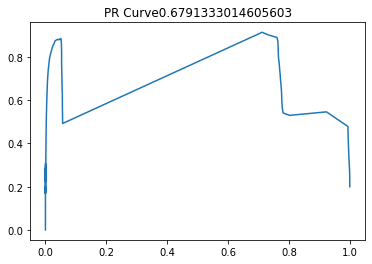